# Матчинг товаров

**Цель работы:** разработать алгоритм, который для всех товаров из validation.csv предложит несколько вариантов наиболее похожих товаров из base.csv. 

**Метрика качетсва алгоритма:** accuracy@5.
$$
accuracy@5 = 100 * \frac{\text{кол-во верно определённых похожих объектов из 5 возможных}} {5}
$$

**Входные данные:**

- base.csv - анонимизированный набор товаров. Каждый товар представлен как уникальный id (0-base, 1-base, 2-base) и вектор признаков размерностью 72.

- train.csv - обучающий датасет. Каждая строчка - один товар, для которого известен уникальный id (0-query, 1-query, …) , вектор признаков И id товара из base.csv, который максимально похож на него (по мнению экспертов).

- validation.csv - датасет с товарами (уникальный id и вектор признаков), для которых надо найти наиболее близкие товары из base.csv

- validation_answer.csv - правильные ответы к предыдущему файлу.

**План работы**:
1. [x] Открыть и ознакомиться с файлами данных.
2. [x] Произвести предобработку и исследовательский анализ данных
    - [x] Проверить данные и откорректировать их, если потребуется
    - [x] Провести исследовательский анализ представленных данныхи
    - [x] избавиться от лишних признаков при наличии
4. [x] Разработать алгоритм матчинга
5. [x] Провести оценку качества матчинга метрикой accuracy@5 на валидационной выборке
6. [x] Написать общий вывод

## 1. Знакомство с данными

Импортируем все необходимые для работы библиотеки.

In [1]:
import pandas as pd
import numpy as np
import faiss
import sweetviz as sv
import matplotlib.pyplot as plt
import seaborn as sns
import phik

from itertools import product
from time import  perf_counter
from sklearn.cluster import KMeans
from scipy.stats import zscore
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.metrics import silhouette_score

Откроем представленные файлы с данными.

In [2]:
df_base = pd.read_csv('datasets/base.csv', index_col=0)
df_train = pd.read_csv('datasets/train.csv', index_col=0)
df_valid = pd.read_csv('datasets/validation.csv', index_col=0)
df_valid_answer = pd.read_csv('datasets/validation_answer.csv', index_col=0)

Рассмотрим представленные данные.

In [3]:
print(df_base.info())
df_base.head(10)

<class 'pandas.core.frame.DataFrame'>
Index: 2918139 entries, 0-base to 4744766-base
Data columns (total 72 columns):
 #   Column  Dtype  
---  ------  -----  
 0   0       float64
 1   1       float64
 2   2       float64
 3   3       float64
 4   4       float64
 5   5       float64
 6   6       float64
 7   7       float64
 8   8       float64
 9   9       float64
 10  10      float64
 11  11      float64
 12  12      float64
 13  13      float64
 14  14      float64
 15  15      float64
 16  16      float64
 17  17      float64
 18  18      float64
 19  19      float64
 20  20      float64
 21  21      float64
 22  22      float64
 23  23      float64
 24  24      float64
 25  25      float64
 26  26      float64
 27  27      float64
 28  28      float64
 29  29      float64
 30  30      float64
 31  31      float64
 32  32      float64
 33  33      float64
 34  34      float64
 35  35      float64
 36  36      float64
 37  37      float64
 38  38      float64
 39  39      float64


0          1          2          3           4           5  \
Id                                                                            
0-base -115.083890  11.152912 -64.426760 -118.88089  216.482440 -104.698060   
1-base  -34.562202  13.332763 -69.787610 -166.53348   57.680607  -86.098370   
2-base  -54.233746   6.379371 -29.210136 -133.41383  150.895830  -99.435326   
3-base  -87.520130   4.037884 -87.803030 -185.06763   76.369540  -58.985165   
4-base  -72.743850   6.522049  43.671265 -140.60803    5.820023 -112.074080   
5-base  -50.510876   6.740296 -81.952030 -142.06926  129.064470 -121.037380   
6-base -132.349780  12.640369 -80.635895 -137.11795   89.345490  -94.853520   
7-base  -80.561770   9.547482 -44.353603 -141.60060  133.501530  -72.643170   
8-base -110.159720   5.319833   8.020306 -172.44500   79.661644 -100.075910   
9-base  -70.979260   4.714583 -88.550476 -188.70183  137.075880 -115.666030   

                 6          7           8           9  ...          62  \
Id                                                     ...               
0-base -469.070588  44.348083  120.915344  181.449700  ...  -42.808693   
1-base  -85.076666 -35.637436  119.718636  195.234190  ... -117.767525   
2-base   52.554795  62.381706  128.951450  164.381470  ...  -76.397800   
3-base -383.182845 -33.611237  122.031910  136.233580  ...  -70.647940   
4-base -397.711282  45.182500  122.167180  112.119064  ...  -57.199104   
5-base -365.401703  79.924280  124.752650  102.136750  ... -103.298900   
6-base -462.933977  91.356030  126.557274  147.394900  ...  -55.650047   
7-base -484.413795  -6.601168  122.312370  103.568220  ...  -55.613580   
8-base   -2.583556  28.758438  122.134224  174.900270  ...  -54.116820   
9-base -209.702523  63.176735  114.353775  117.680900  ...  -34.780470   

               63         64          65         66         67          68  \
Id                                                                           
0-base  38.800827 -151.76218  -74.389090  63.666340  -4.703861   92.933610   
1-base  41.100000 -157.82940  -94.446806  68.202110  24.346846  179.937930   
2-base  46.011803 -207.14442  127.325570  65.566180  66.325680   81.073490   
3-base  -6.358921 -147.20105  -37.692750  66.202890 -20.566910  137.206940   
4-base  56.642403 -159.35184   85.944724  66.766320  -2.505783   65.315285   
5-base  28.675972 -208.37845  -78.293455  66.580765  70.894360   30.805370   
6-base  29.008305 -138.24612  156.300510  67.054200 -25.324776   85.734146   
7-base  55.202328 -179.15207   48.050861  66.357260  26.573547  115.890150   
8-base  36.942806 -133.81061  -23.802479  69.412280 -51.071934   91.097830   
9-base  55.108017 -168.94844  -36.150143  67.762600  49.744743  -16.176880   

                69           70         71  
Id                                          
0-base  115.269190  -112.756640 -60.830353  
1-base  116.834000   -84.888941 -59.524610  
2-base  116.594154 -1074.464888 -32.527206  
3-base  117.474100 -1074.464888 -72.915490  
4-base  135.051590 -1074.464888   0.319401  
5-base  134.891560  -913.638206 -30.293541  
6-base  138.853520 -1070.516278  -2.041809  
7-base  110.674900 -1074.464888 -69.883660  
8-base  108.008660  -426.686160 -12.405426  
9-base  139.030990  -440.837882 -98.691440  

[10 rows x 72 columns]

In [4]:
print(df_train.info())
df_train.head(10)

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 0-query to 99999-query
Data columns (total 73 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   0       100000 non-null  float64
 1   1       100000 non-null  float64
 2   2       100000 non-null  float64
 3   3       100000 non-null  float64
 4   4       100000 non-null  float64
 5   5       100000 non-null  float64
 6   6       100000 non-null  float64
 7   7       100000 non-null  float64
 8   8       100000 non-null  float64
 9   9       100000 non-null  float64
 10  10      100000 non-null  float64
 11  11      100000 non-null  float64
 12  12      100000 non-null  float64
 13  13      100000 non-null  float64
 14  14      100000 non-null  float64
 15  15      100000 non-null  float64
 16  16      100000 non-null  float64
 17  17      100000 non-null  float64
 18  18      100000 non-null  float64
 19  19      100000 non-null  float64
 20  20      100000 non-null  float64
 21  21  

0          1           2          3           4           5  \
Id                                                                              
0-query  -53.882748  17.971436  -42.117104 -183.93668  187.517490  -87.144930   
1-query  -87.776370   6.806268  -32.054546 -177.26039  120.803330  -83.810590   
2-query  -49.979565   3.841486 -116.118590 -180.40198  190.128430  -50.837620   
3-query  -47.810562   9.086598 -115.401695 -121.01136   94.652840 -109.255410   
4-query  -79.632126  14.442886  -58.903397 -147.05254   57.127068  -16.239529   
5-query  -92.844185   2.975510  -61.760483 -171.67546  144.798370  -58.685143   
6-query -127.996580   9.672705  -37.678320 -141.41304  119.940926  -76.850460   
7-query  -59.506752   7.959120   21.068153 -142.99788  128.157990  -92.496300   
8-query -111.359276   6.414694  -88.023330 -131.79814  157.491360  -83.075620   
9-query  -75.485540   9.759681  -66.438310 -159.26770  110.319880  -65.563866   

                  6          7           8           9  ...         63  \
Id                                                      ...              
0-query -347.360606  38.307602  109.085560   30.413513  ...  70.107360   
1-query  -94.572749 -78.433090  124.915900  140.331070  ...   4.669178   
2-query   26.943937 -30.447489  125.771164  211.607820  ...  78.039764   
3-query -775.150134  79.186520  124.003100  242.650650  ...  44.515266   
4-query -321.317964  45.984676  125.941284  103.392670  ...  45.028910   
5-query  104.112909  75.844580  118.336230   81.981125  ...  12.807585   
6-query  -15.455417  75.031220  128.762990  266.939580  ...  65.676480   
7-query -143.453758  10.710561  131.086790   71.491560  ...  49.263610   
8-query -759.626065  49.599327  120.683470   87.519910  ...  45.634857   
9-query -325.035875 -77.376080  127.402720  173.257580  ...  17.841938   

                64          65         66          67          68          69  \
Id                                                                              
0-query -155.80257 -101.965943  65.903790   34.457500   62.642094  134.763600   
1-query -151.69771   -1.638704  68.170876   25.096191   89.974976  130.589630   
2-query -169.14620   82.144186  66.008220   18.400496  212.409730  121.931470   
3-query -145.41675   93.990981  64.131350  106.061920   83.178760  118.277725   
4-query -196.09207 -117.626337  66.926220   42.456170   77.621765   92.479930   
5-query -137.96362   86.282088  64.678535   64.527600   64.664440  126.914600   
6-query -145.51813  139.211140  69.942120   21.280258   76.636410   85.143050   
7-query -203.78833 -101.989379  67.291770   44.437595   45.183838  150.288530   
8-query -136.84851  117.466574  68.664635  -19.192120   54.241932   92.495636   
9-query -129.49008 -142.201450  68.498550  -58.113903  -13.233955  114.562810   

                  70         71        Target  
Id                                             
0-query  -415.750254 -25.958572   675816-base  
1-query -1035.092211 -51.276833   366656-base  
2-query -1074.464888 -22.547178  1447819-base  
3-query -1074.464888 -19.902788  1472602-base  
4-query -1074.464888 -21.149351   717819-base  
5-query  -800.428664 -30.197390  2381316-base  
6-query   -44.371931 -15.524637   773187-base  
7-query -1074.464888 -66.052086  2488580-base  
8-query    11.012047 -61.062813    24129-base  
9-query -1074.464888  31.882130   775706-base  

[10 rows x 73 columns]

In [5]:
print(df_valid.info())
df_valid.head(10)

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 100000-query to 199999-query
Data columns (total 72 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   0       100000 non-null  float64
 1   1       100000 non-null  float64
 2   2       100000 non-null  float64
 3   3       100000 non-null  float64
 4   4       100000 non-null  float64
 5   5       100000 non-null  float64
 6   6       100000 non-null  float64
 7   7       100000 non-null  float64
 8   8       100000 non-null  float64
 9   9       100000 non-null  float64
 10  10      100000 non-null  float64
 11  11      100000 non-null  float64
 12  12      100000 non-null  float64
 13  13      100000 non-null  float64
 14  14      100000 non-null  float64
 15  15      100000 non-null  float64
 16  16      100000 non-null  float64
 17  17      100000 non-null  float64
 18  18      100000 non-null  float64
 19  19      100000 non-null  float64
 20  20      100000 non-null  float64
 21

0          1          2          3           4  \
Id                                                                      
100000-query  -57.372734   3.597752 -13.213642 -125.92679  110.745940   
100001-query  -53.758705  12.790300 -43.268543 -134.41762  114.449910   
100002-query  -64.175095  -3.980927  -7.679249 -170.16093   96.446160   
100003-query  -99.286860  16.123936   9.837166 -148.06044   83.697080   
100004-query  -79.532920  -0.364173 -16.027431 -170.88495  165.453920   
100005-query  -89.745360   6.317698 -80.744650 -114.53197  153.960340   
100006-query  -64.514260   7.711647 -28.726236 -220.05089  186.177460   
100007-query -119.026850   7.536469 -62.973827 -142.94609  150.376110   
100008-query -100.618990  10.874402 -59.983580 -147.85175   86.138500   
100009-query  -58.379074  12.812809 -37.571396 -186.67310   89.644264   

                       5           6           7           8           9  ...  \
Id                                                                        ...   
100000-query  -81.279594 -461.003172  139.815720  112.880980   75.215750  ...   
100001-query  -90.520130 -759.626065   63.995087  127.117905   53.128998  ...   
100002-query  -62.377740 -759.626065   87.477554  131.270110  168.920320  ...   
100003-query -133.729720   58.576403  -19.046660  115.042404   75.206730  ...   
100004-query  -28.291668   33.931936   34.411217  128.903980  102.086914  ...   
100005-query  -74.897130 -208.928691  -32.214005  115.582855   61.603172  ...   
100006-query  -42.254353   96.324664  -30.496332  109.519530  217.348480  ...   
100007-query  -92.343550 -530.124724   24.280703  124.623260  119.622160  ...   
100008-query  -90.452470 -638.720433  111.696850  120.869210  125.254510  ...   
100009-query  -43.858597 -394.429315   -1.023273  113.776436   26.608970  ...   

                      62         63         64          65        66  \
Id                                                                     
100000-query  -75.513020  52.830902 -143.43945   59.051935  69.28224   
100001-query  -79.441830  29.185436 -168.60590  -82.872443  70.76560   
100002-query -134.795410  37.368730 -159.66231 -119.232725  67.71044   
100003-query  -77.236110  44.100494 -132.53012 -106.318982  70.88396   
100004-query -123.770250  45.635944 -134.25893   13.735359  70.61763   
100005-query  -64.934890  37.824436 -153.04173 -131.257912  68.26281   
100006-query  -31.122826  11.672802 -112.34755  183.939297  67.22618   
100007-query -121.699980  49.379295 -211.29207   37.299723  68.56667   
100008-query  -68.627860  76.054110 -176.23720  173.788344  68.73241   
100009-query  -56.836964  69.649020 -206.33858  -26.645270  68.19587   

                      67          68          69           70          71  
Id                                                                         
100000-query   61.927513  111.592530  115.140656 -1099.130485 -117.079360  
100001-query  -65.975950   97.077160  123.391640  -744.442332  -25.009320  
100002-query   86.002060  137.636410  141.081630  -294.052271  -70.969604  
100003-query   23.577892  133.183960  143.252940  -799.363667  -89.392670  
100004-query   15.332115  154.568120  101.700640 -1171.892332 -125.307890  
100005-query   56.239280  120.646900   76.342550 -1156.992950  -72.146390  
100006-query   65.571060   -6.655426   95.882780 -1176.878727  -37.918420  
100007-query   21.038134   37.364270  116.667170 -1129.242913  -87.194520  
100008-query  222.442140  -38.008790  111.531290 -1231.711711  -85.407120  
100009-query  -41.897000  151.713680  119.582800  -729.465551  -70.948770  

[10 rows x 72 columns]

In [6]:
print(df_valid_answer.info())
df_valid_answer.head(10)

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 100000-query to 199999-query
Data columns (total 1 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   Expected  100000 non-null  object
dtypes: object(1)
memory usage: 1.5+ MB
None


Expected
Id                        
100000-query  2676668-base
100001-query    91606-base
100002-query   472256-base
100003-query  3168654-base
100004-query    75484-base
100005-query  1905037-base
100006-query   306584-base
100007-query  1533713-base
100008-query  2796017-base
100009-query  1777304-base

**Вывод по первому шагу:** открыли и изучили таблицы с данными.

Для работы представлены четыре таблицы:
- base.csv содержит 72 обезличенных признака типа float64 и 2918139 строк.
- train.csv содержит 72 обезличенных признака типа float64 и размеченный целевой признак типа object; и 100000 строк. На ней будем производить тренировку алгоритма.
- validation.csv содержит 72 обезличенных признака типа float64; и 100000 строк. Для данной выборки мы будем искать соответствия в base.csv.
- validation_answer.csv содержит ожидаемое значение матчинга типа object; и 100000 строк. Данная таблица необходима для оценки метрики.

На первый взгляд пропуски в таблицах отсутствуют. Далее перейдем к предобработке и исследовательскому анализу данных.

## 2. Предобработка и исследовательский анализ данных.

* Для начала выполним предобработку

Оптимизируем размеры датафреймов, изменив разрядность `float` с 64 до 32.

In [7]:
def memory_optimization(df):
    for column in df.columns:
        if df[column].dtype == 'float64':
            df[column] = df[column].astype('float32')
    return (df.memory_usage(index=True).sum() / 1000000)

In [8]:
memory = []
memory.append(round(memory_optimization(df_base), 2))
memory.append(round(memory_optimization(df_train), 2))
memory.append(round(memory_optimization(df_valid), 2))
pd.DataFrame(memory, index=['base', 'train', 'validation'], columns=['size, MB'])

size, MB
base          863.77
train          30.40
validation     29.60

Данное решение позволило сократить размер каждого набора данных примерно вдвое.

Далее рассмотрим данные в `train` на предмет наличия явных дубликатов в признаках.

In [9]:
df_train.drop(['Target'], axis=1).duplicated().sum()

0

Явные дубликаты отсутстсвуют.

Выделим обучающие и целевой признаки в тренировочном датафрейме.

In [10]:
df_train_dt = df_train.drop('Target', axis=1)
target = df_train['Target']

После чего перейдем к поиску аномалий.

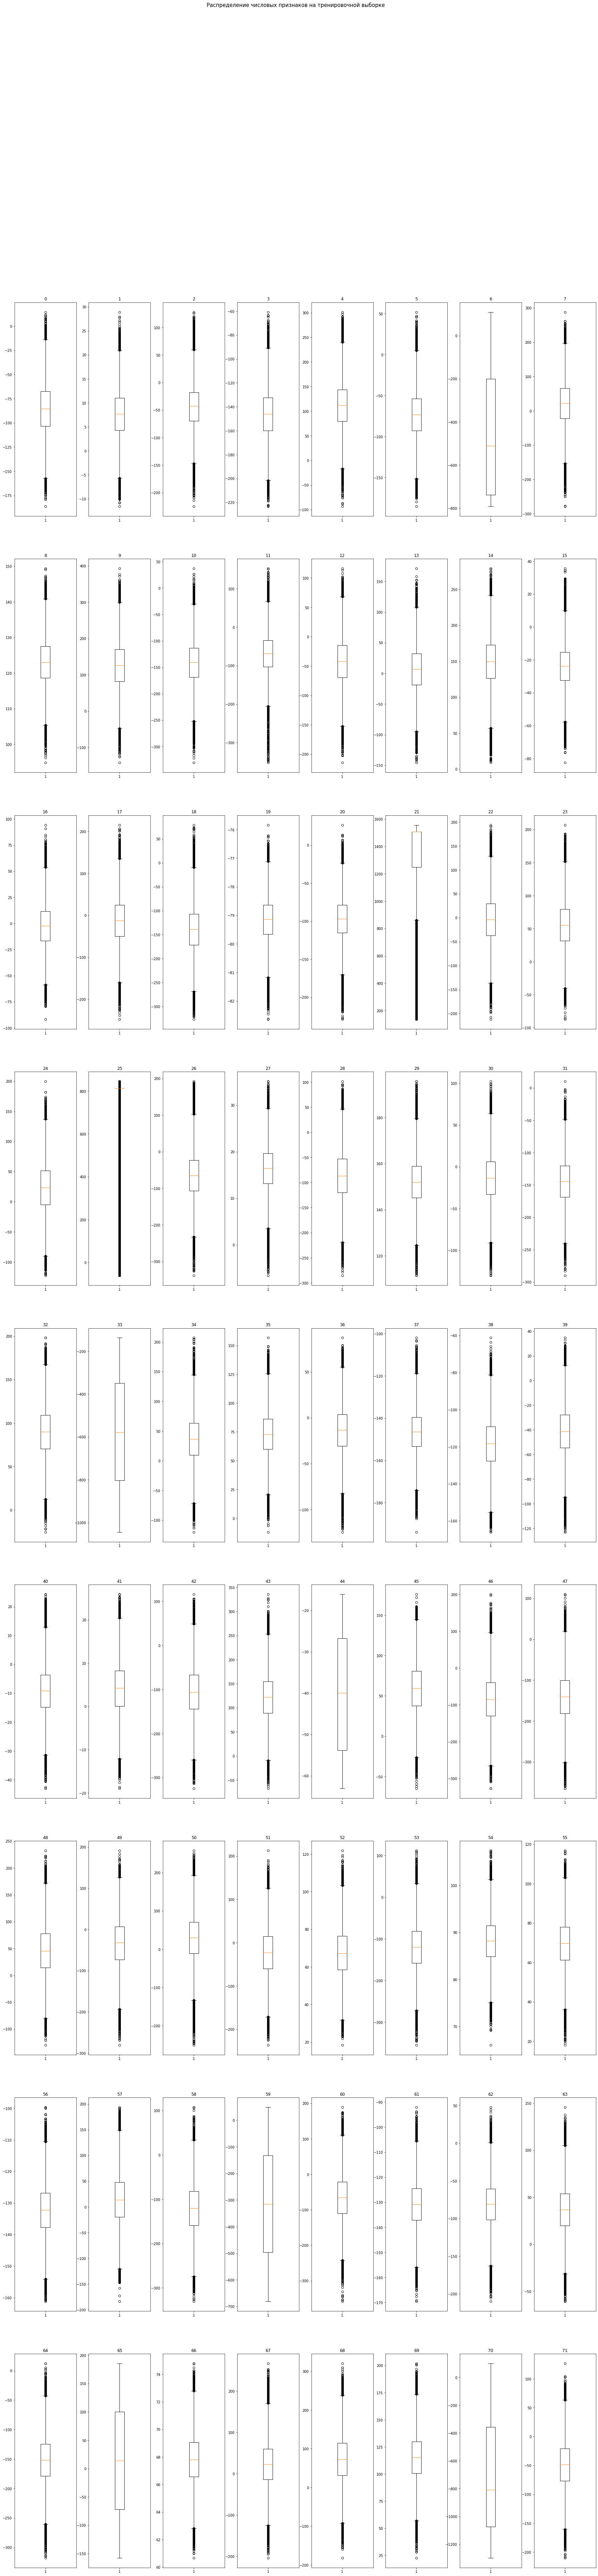

In [11]:
fig, axs = plt.subplots(9, 8)
ax = axs.ravel()
plt.figure
fig.suptitle('Распределение числовых признаков на тренировочной выборке', fontsize=15)
fig.set_size_inches(30, 120)
for i, num in enumerate(df_train_dt.columns.tolist()):
    ax[i].boxplot(df_train[num])
    ax[i].set_title(num)
plt.show()

Избавимся от выбросов, заменив их на средние значения.

In [12]:
n_sigma = 2.7

df_base.mask(~(zscore(df_base).abs().lt(n_sigma)), inplace=True)
df_base = df_base.apply(lambda x: x.fillna(x.mean()))

df_valid.mask(~(zscore(df_valid).abs().lt(n_sigma)), inplace=True)
df_valid = df_valid.apply(lambda x: x.fillna(x.mean()))

df_train_dt.mask(~(zscore(df_train_dt).abs().lt(n_sigma)), inplace=True)
df_train_dt = df_train_dt.apply(lambda x: x.fillna(x.mean()))

* Проведем исследовательский анализ данных при помощи библиотеки `sweetviz`.

                                             |                                             | [  0%]   00:00 ->…


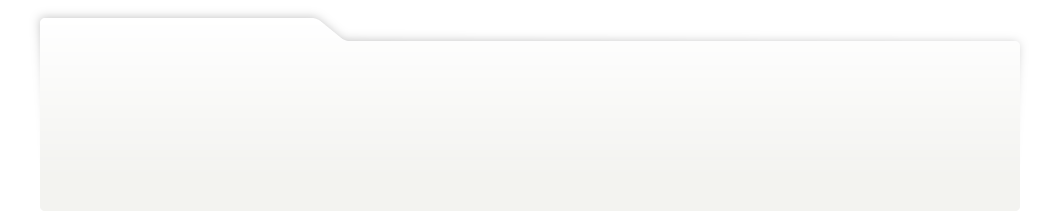
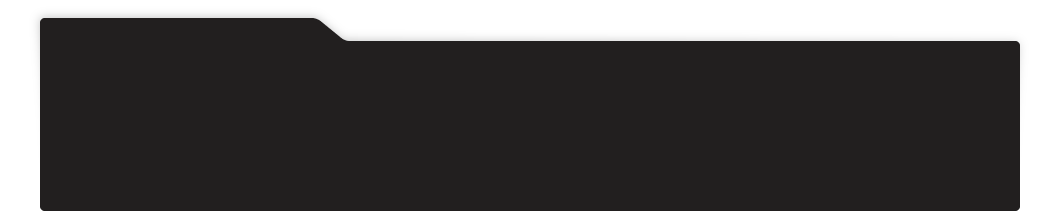
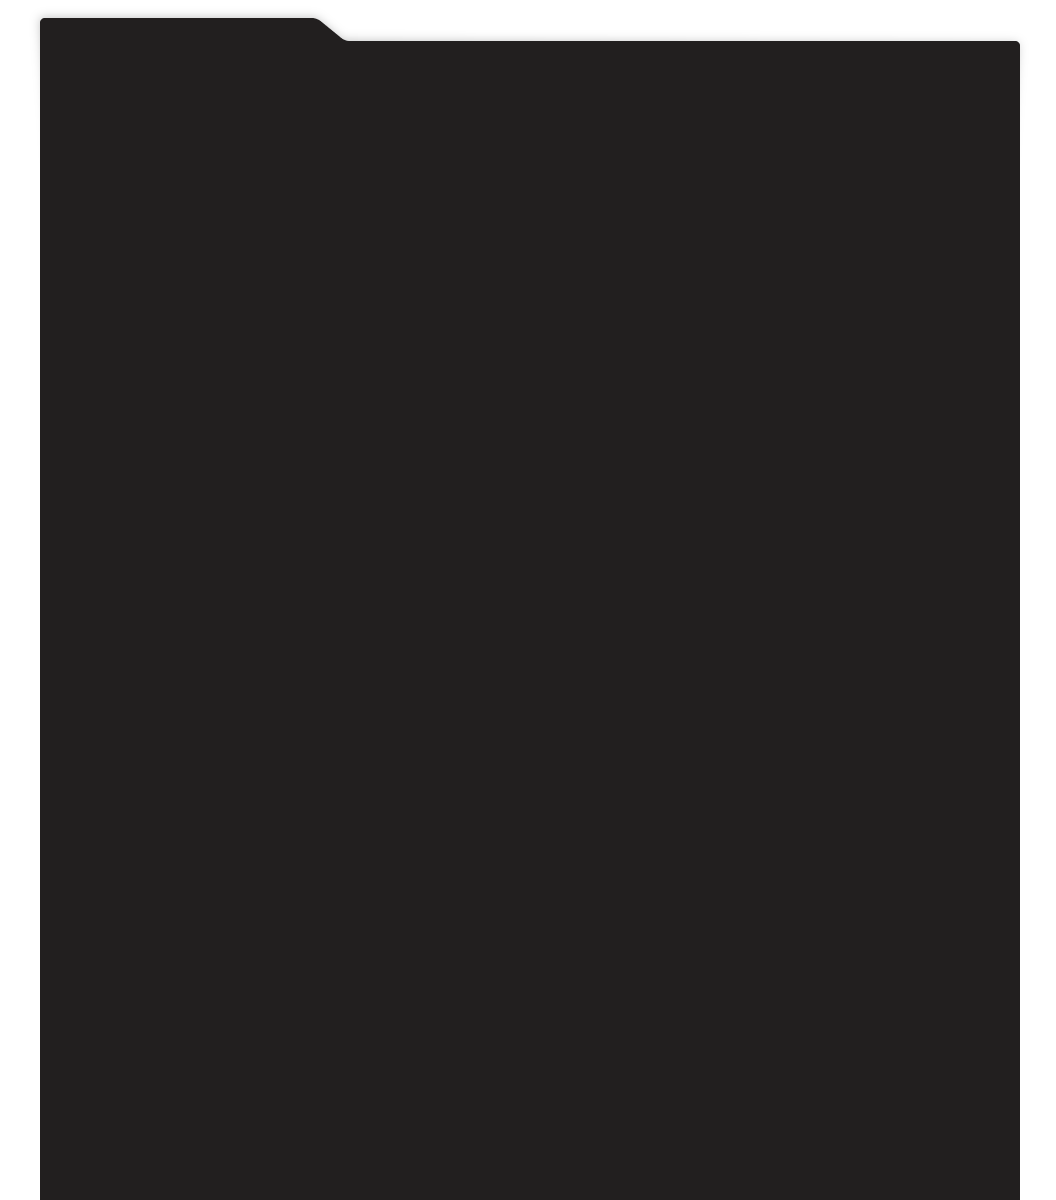
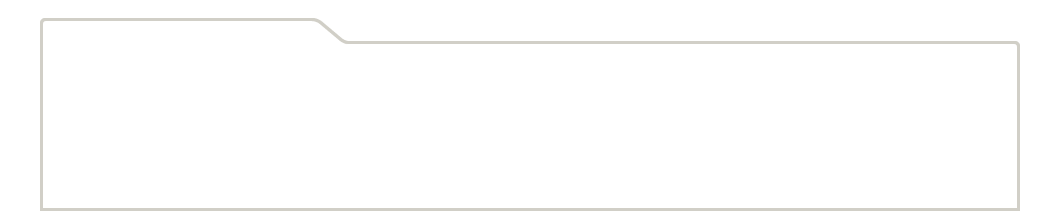
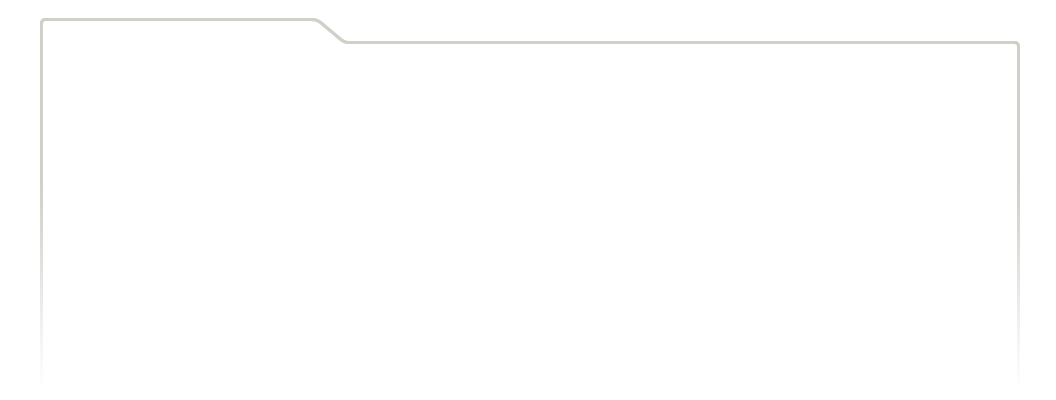
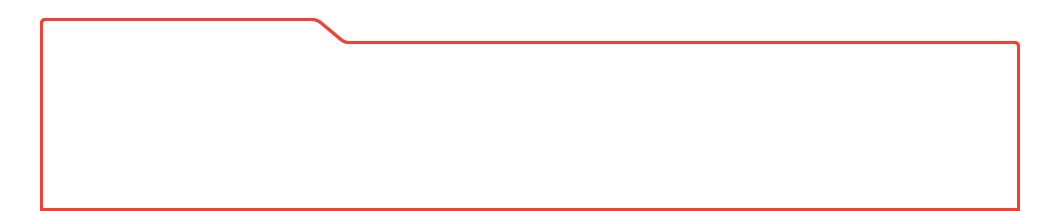
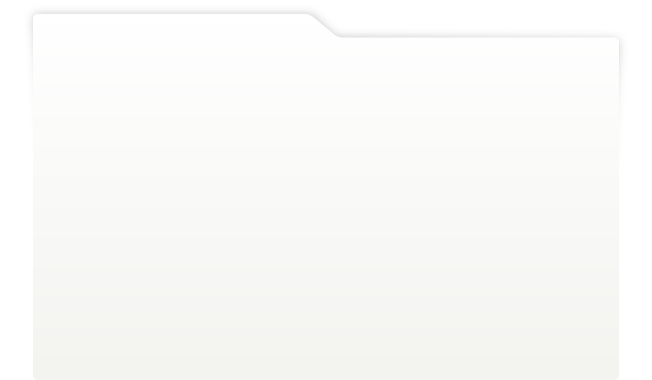
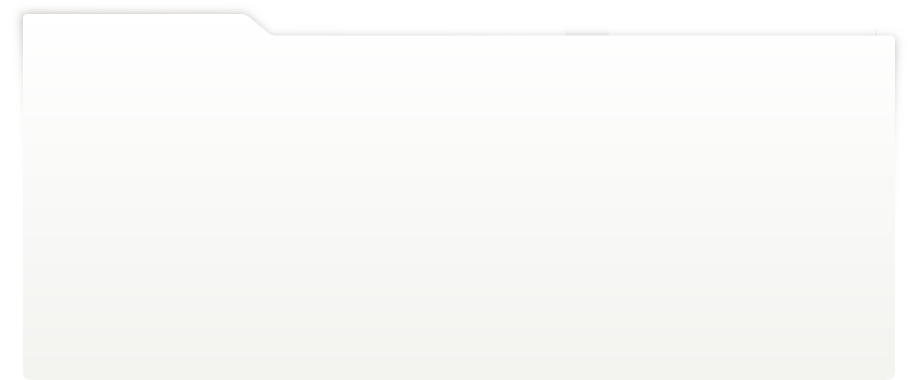
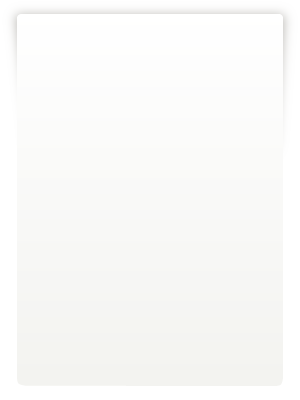
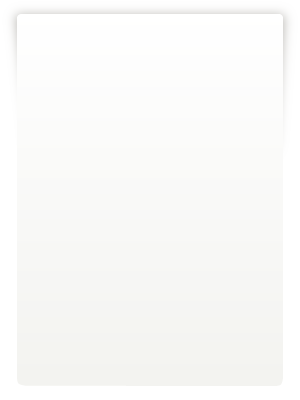
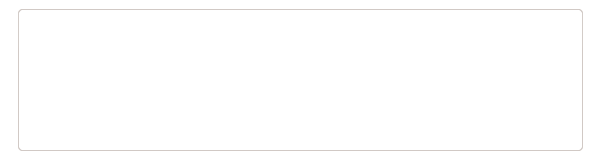
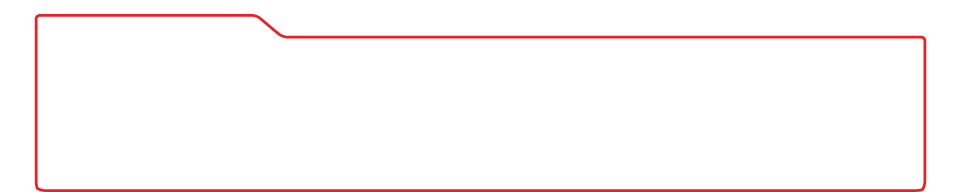
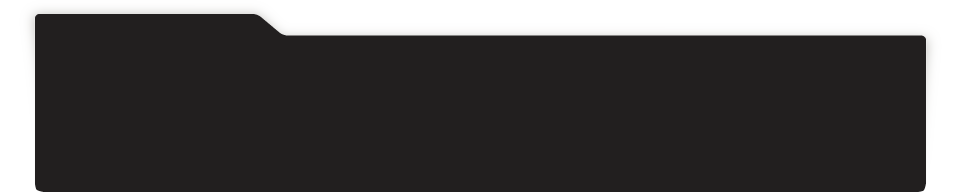
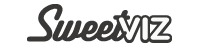
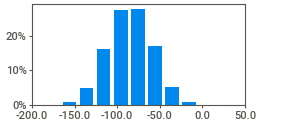
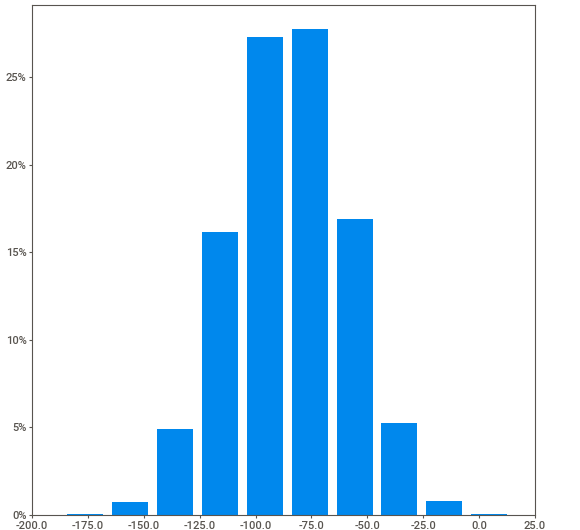
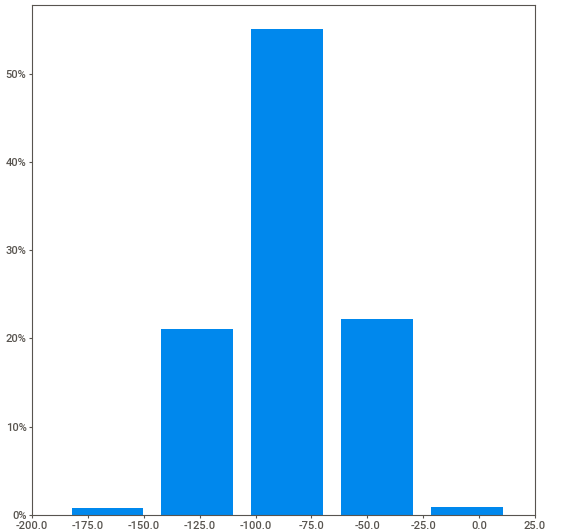
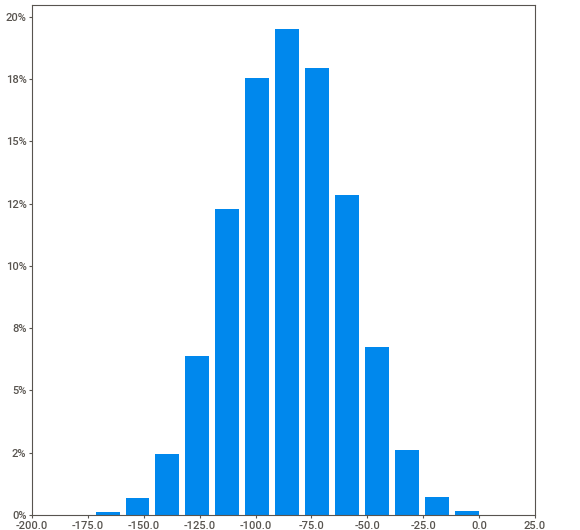
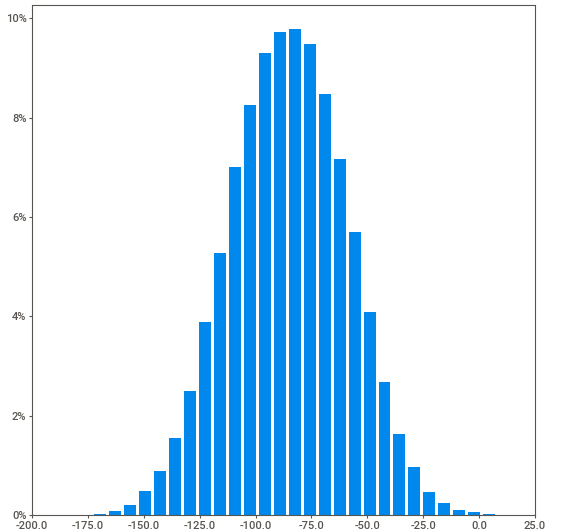
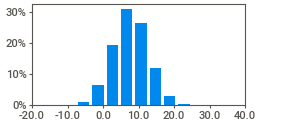
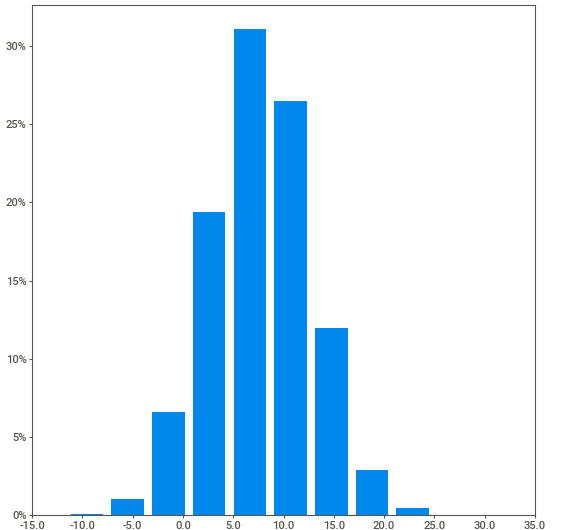
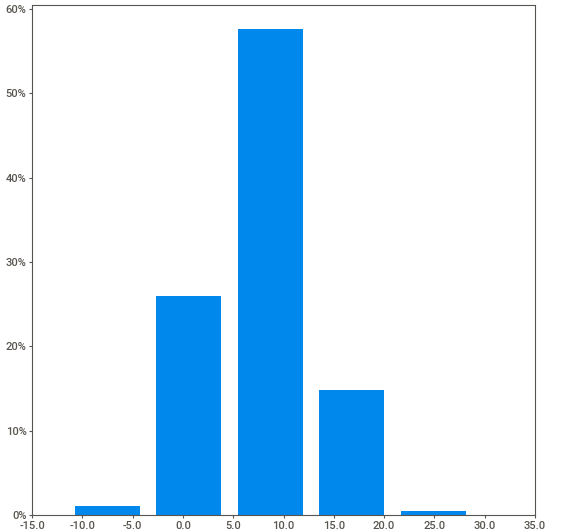
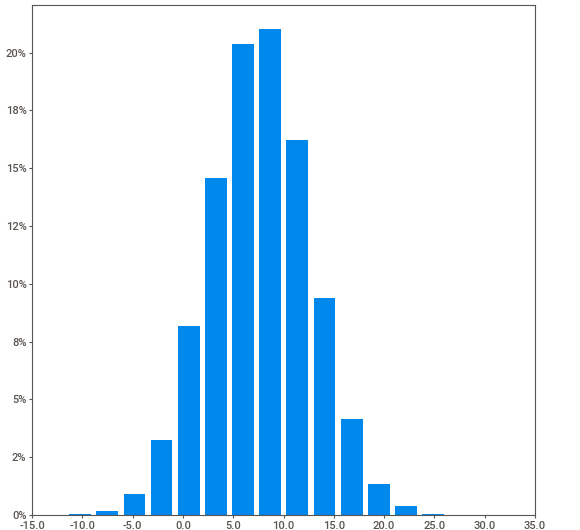
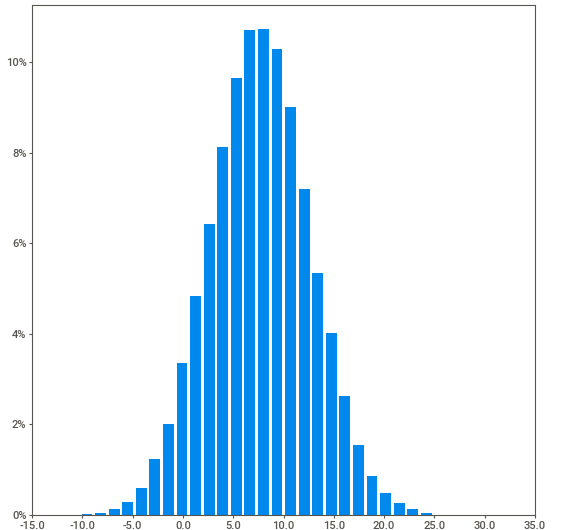
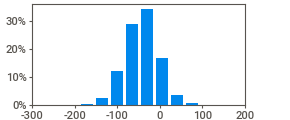
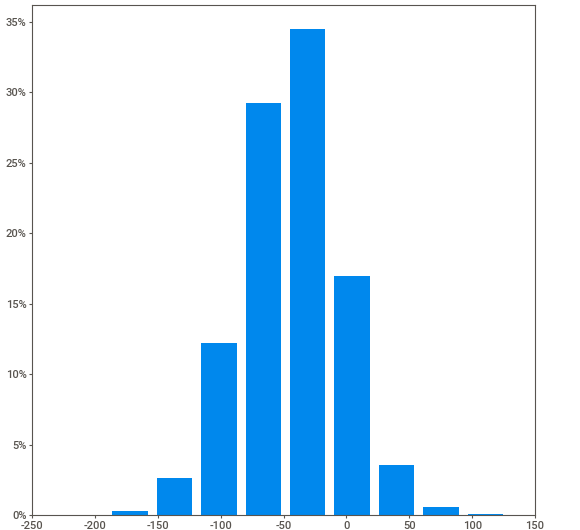
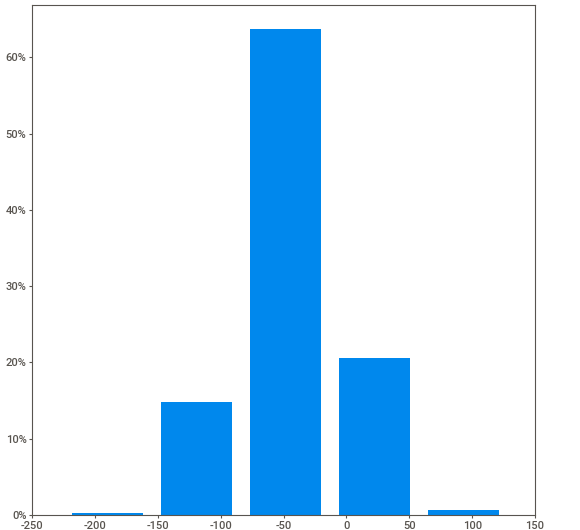
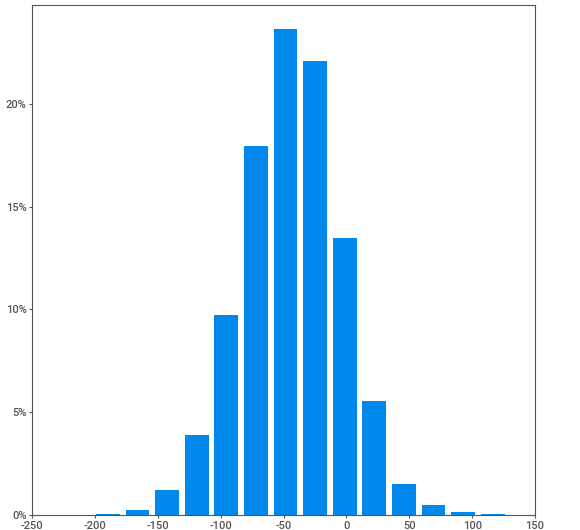
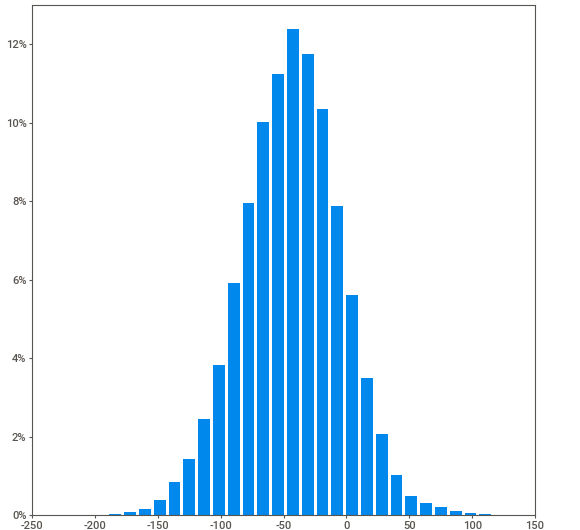
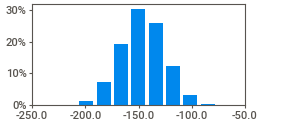
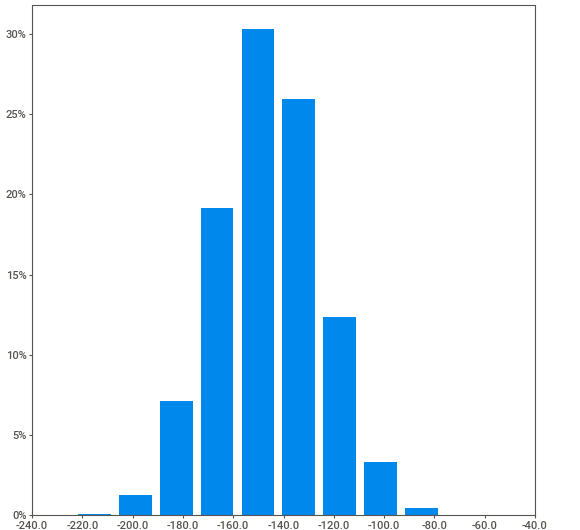
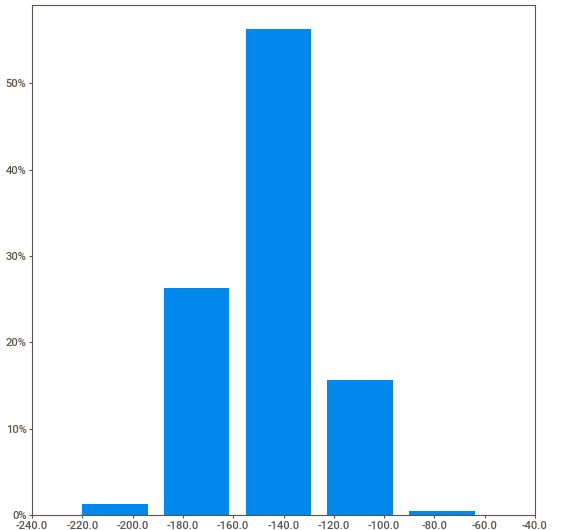
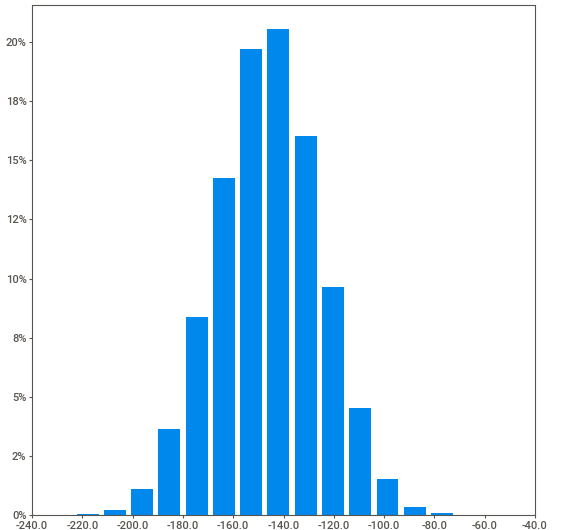
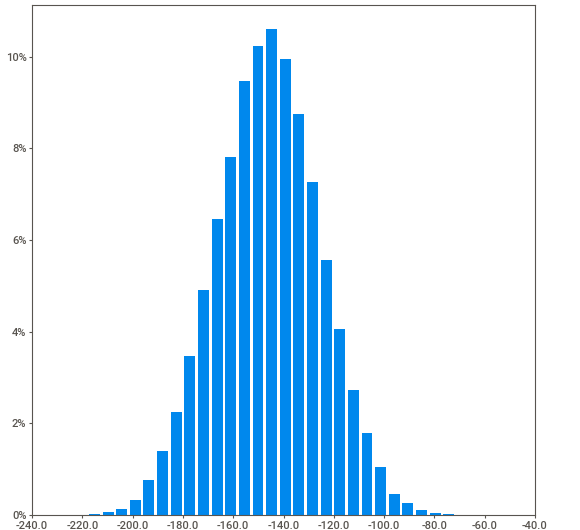
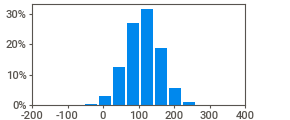
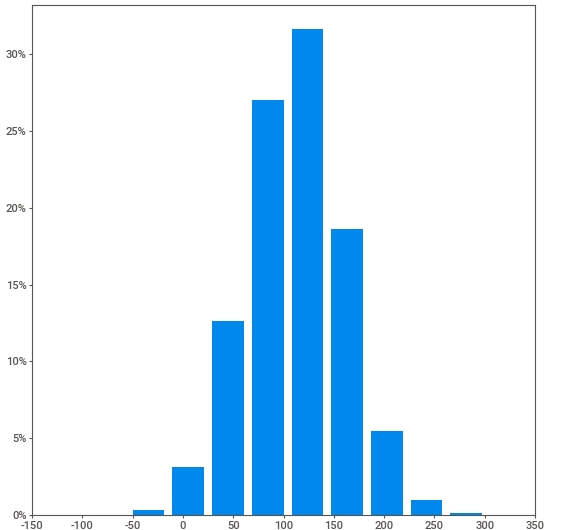
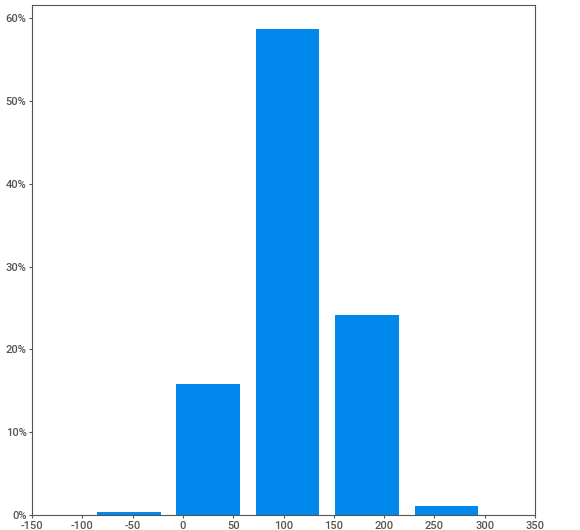
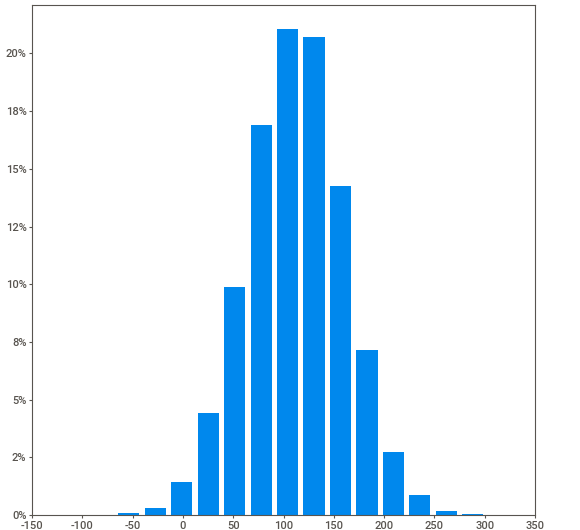
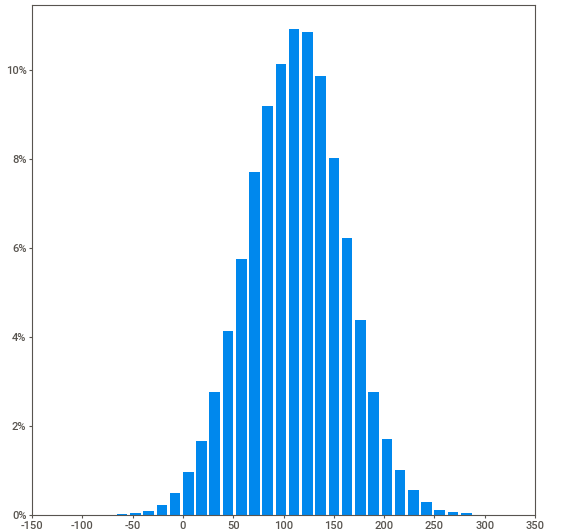
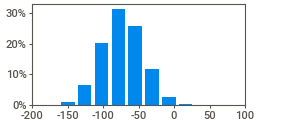
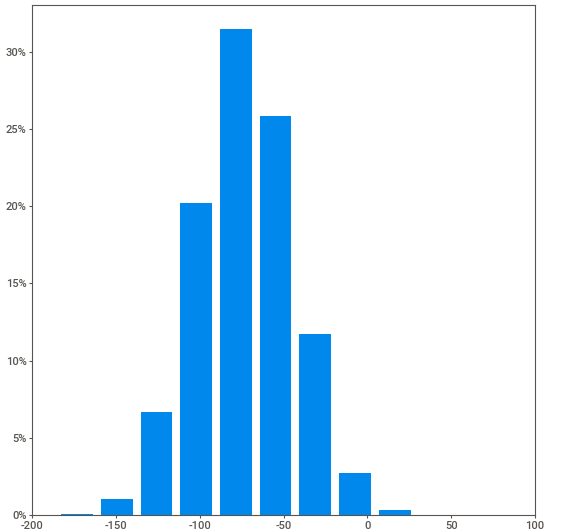
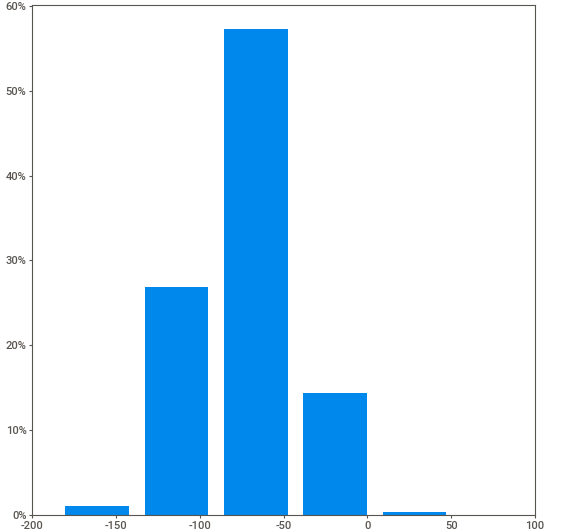
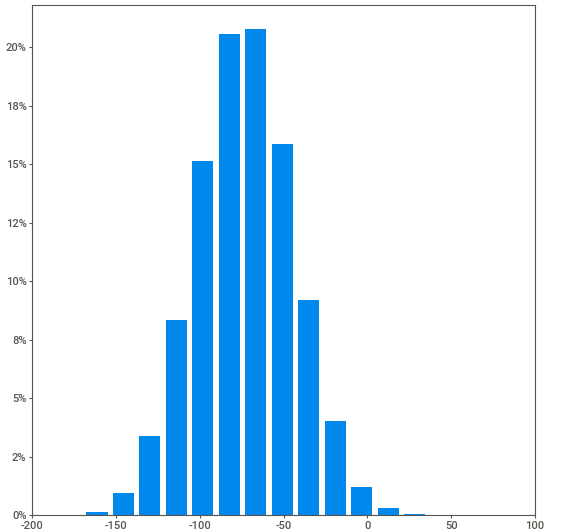
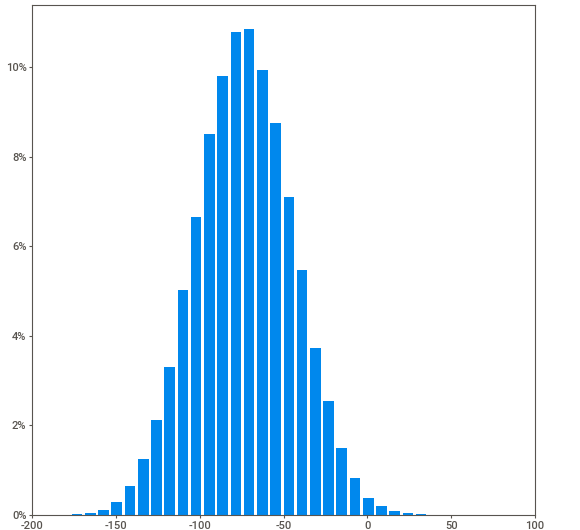
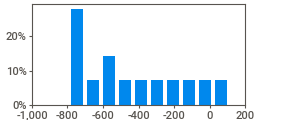
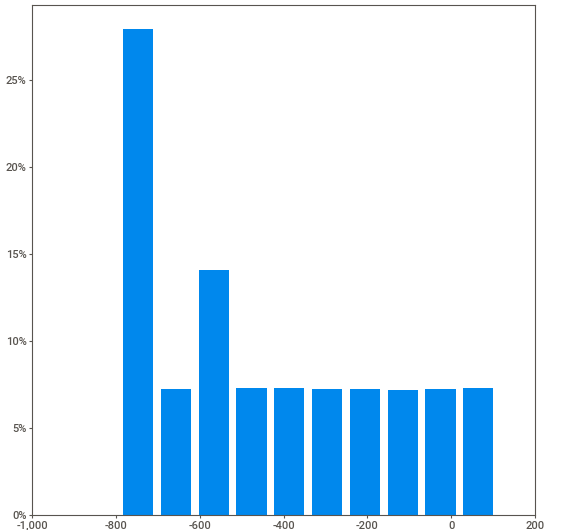
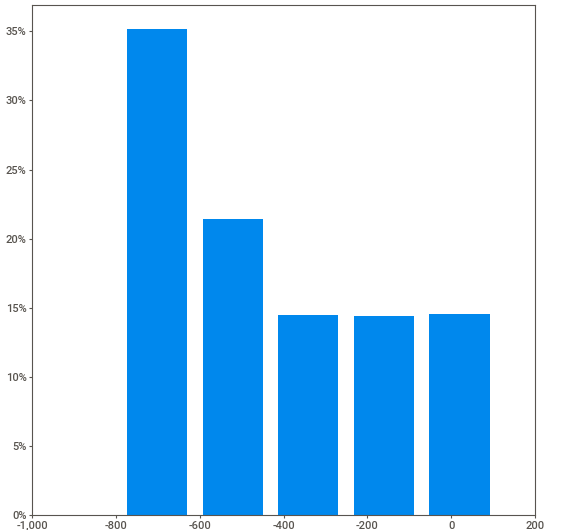
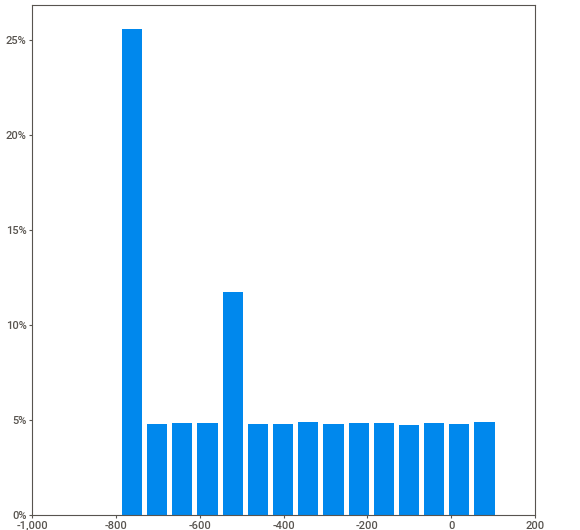
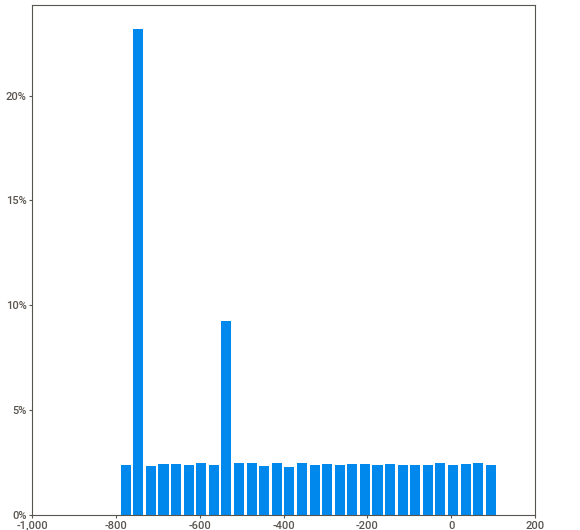
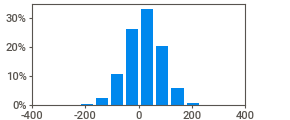
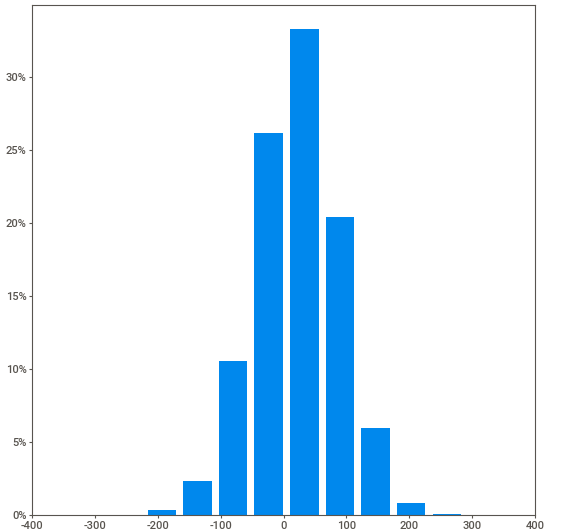
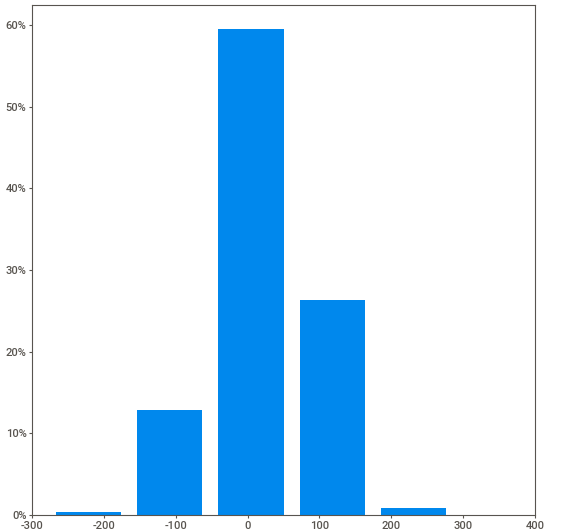
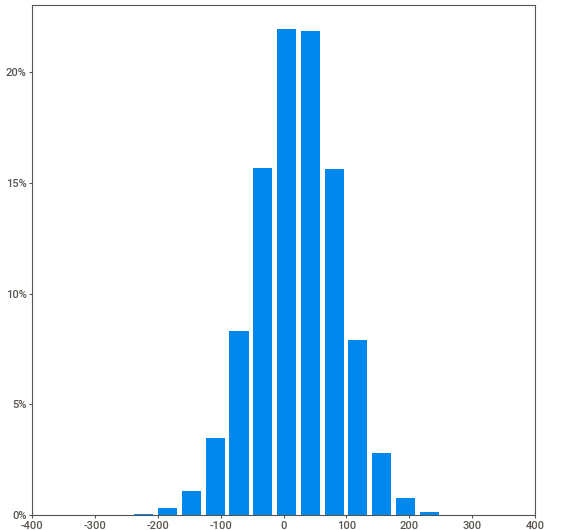
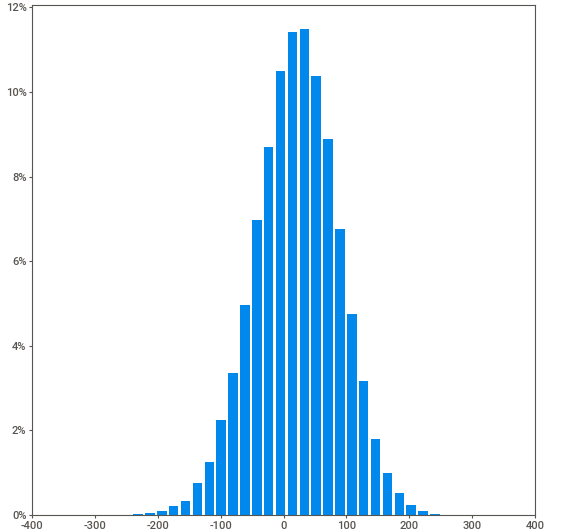
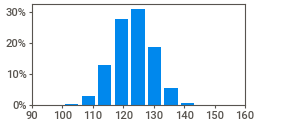
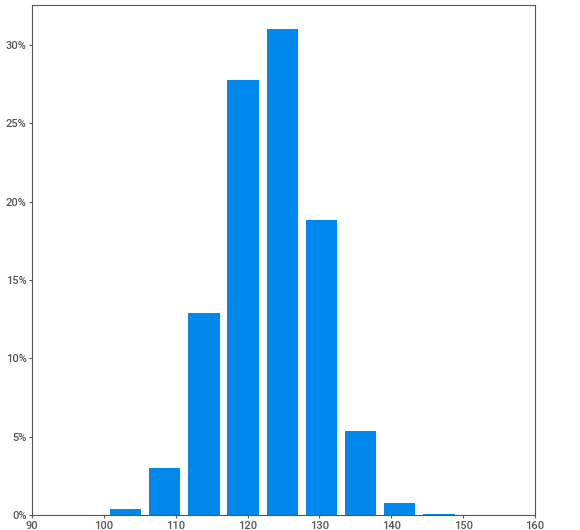
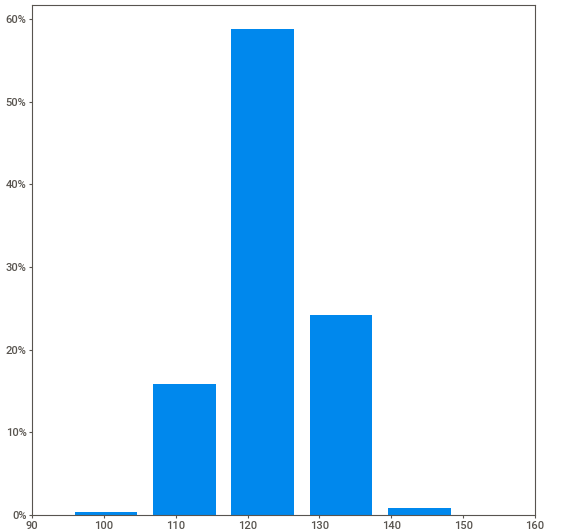
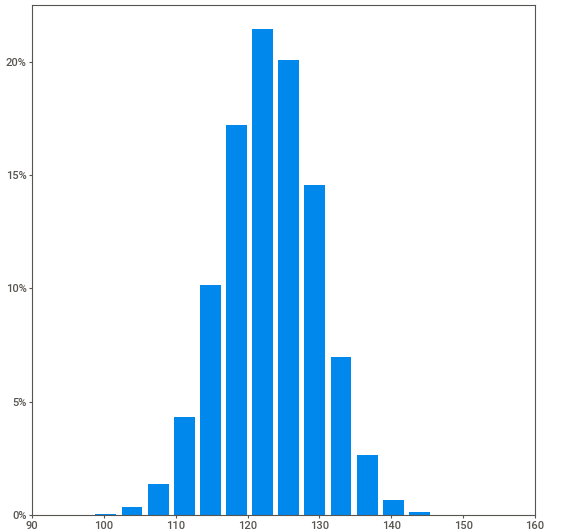
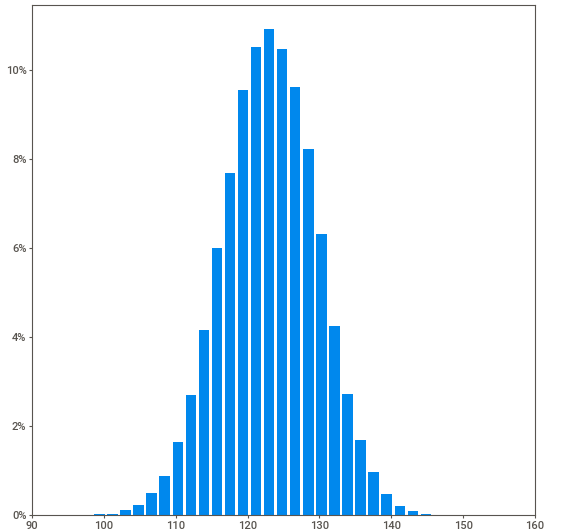
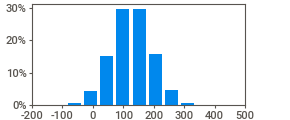
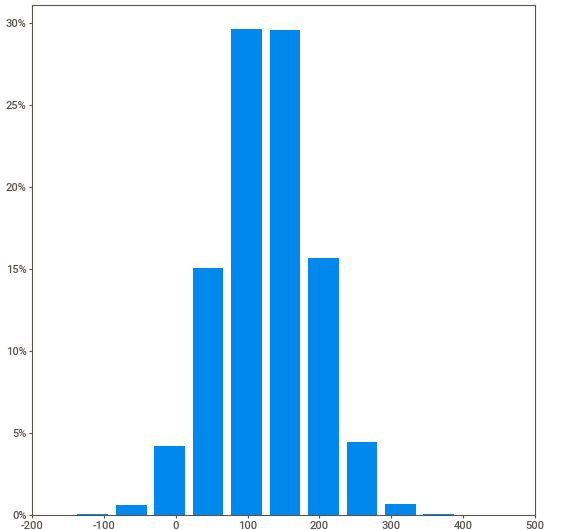
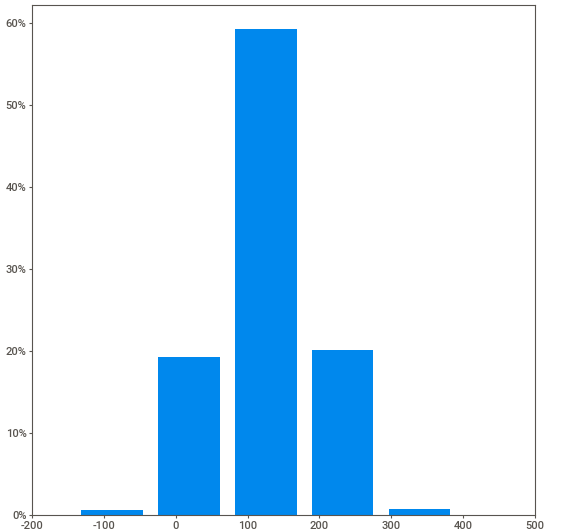
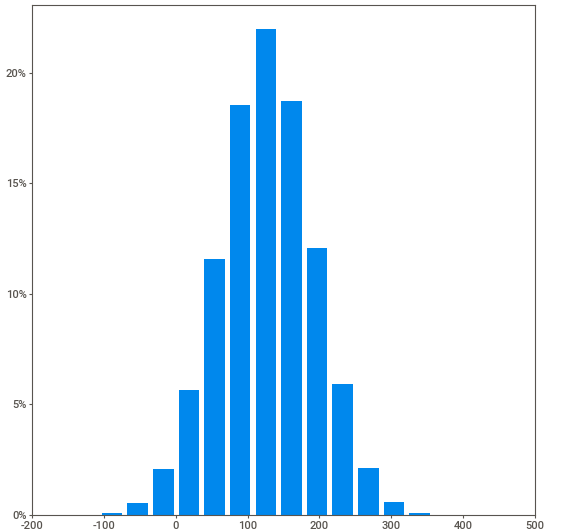
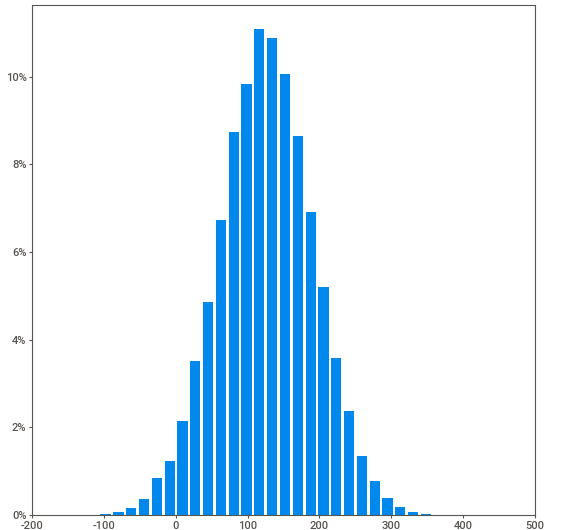
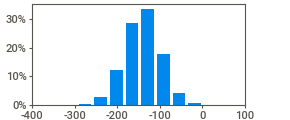
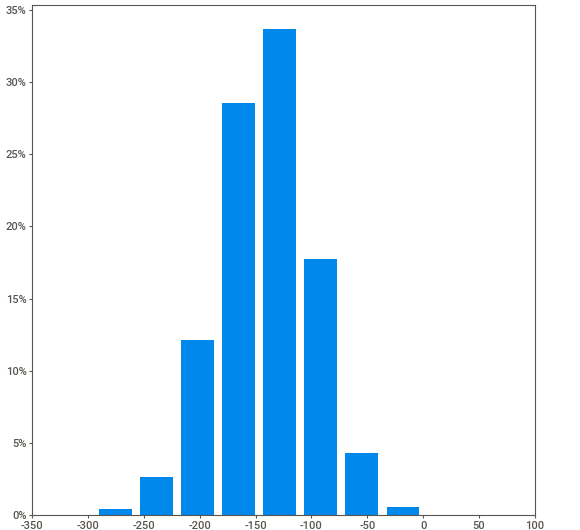
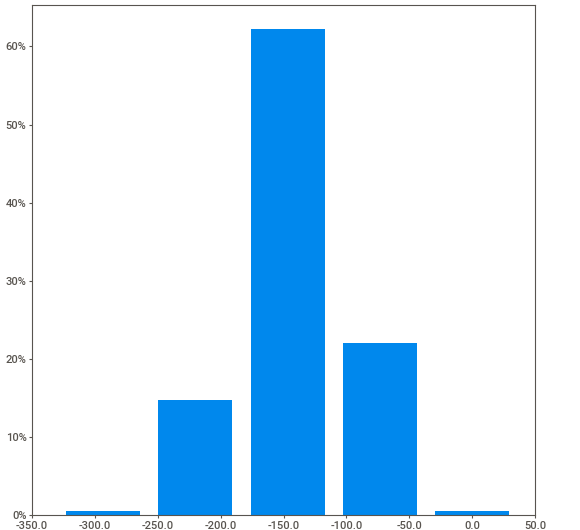
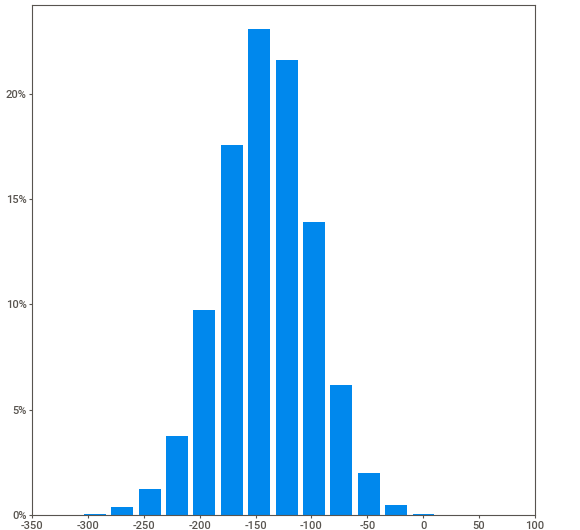
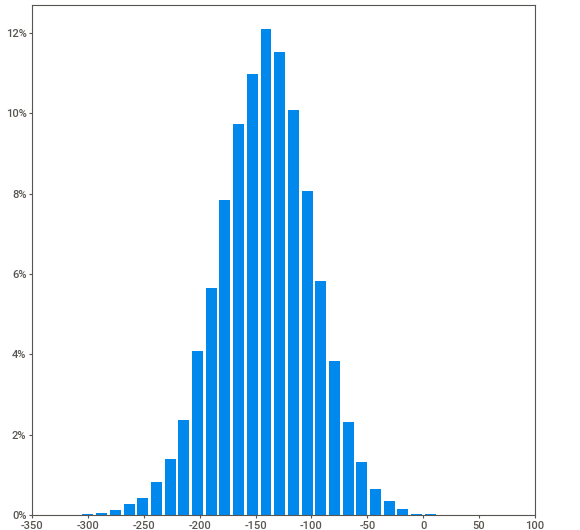
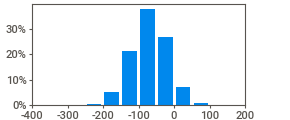
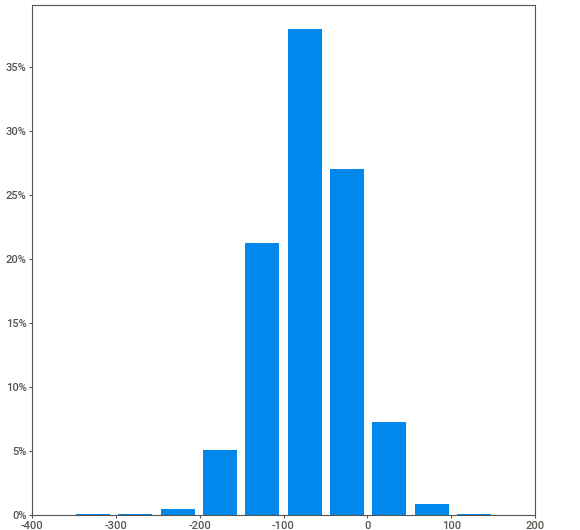
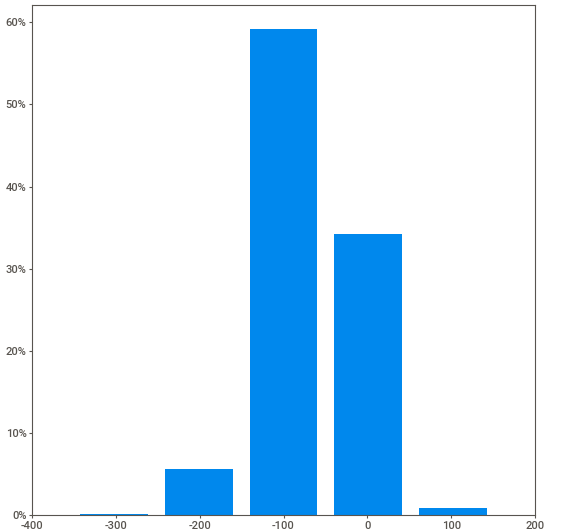
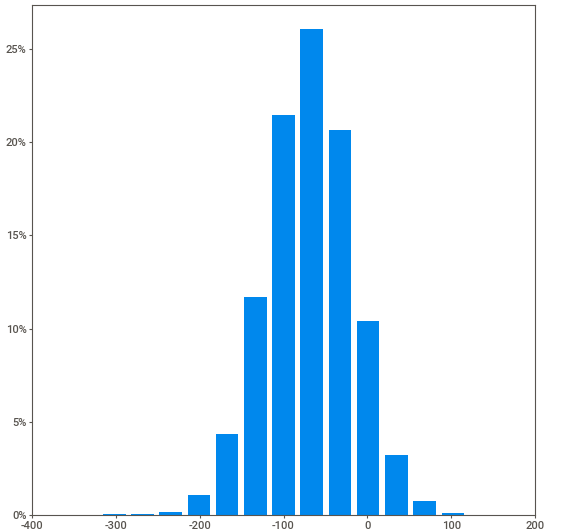
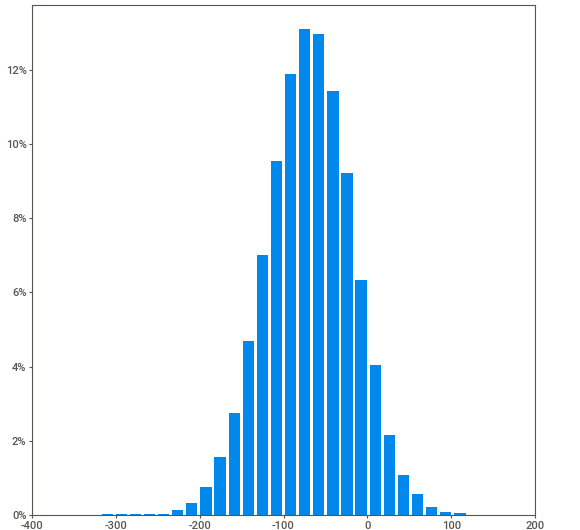
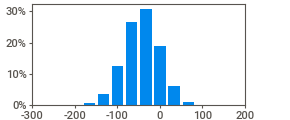
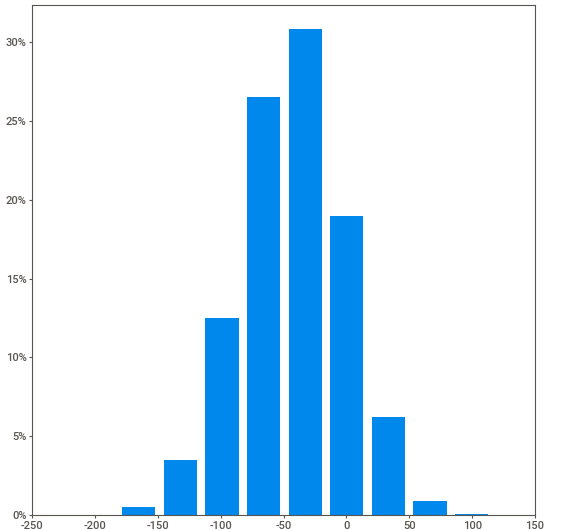
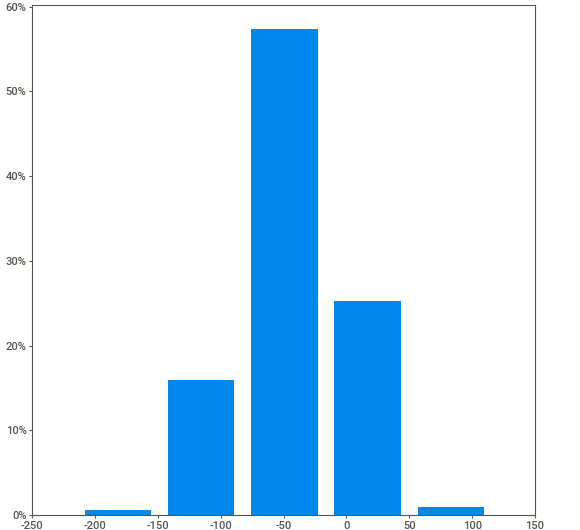
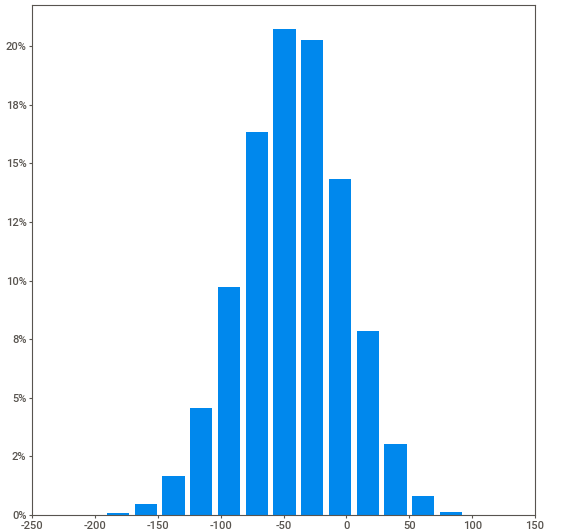
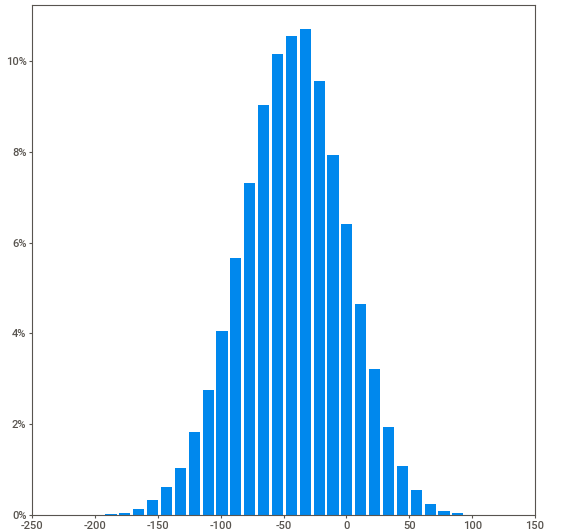
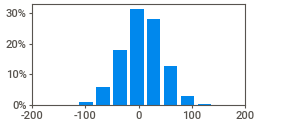
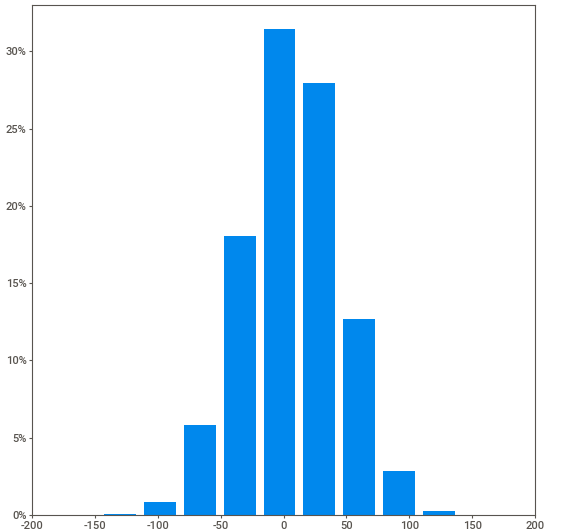
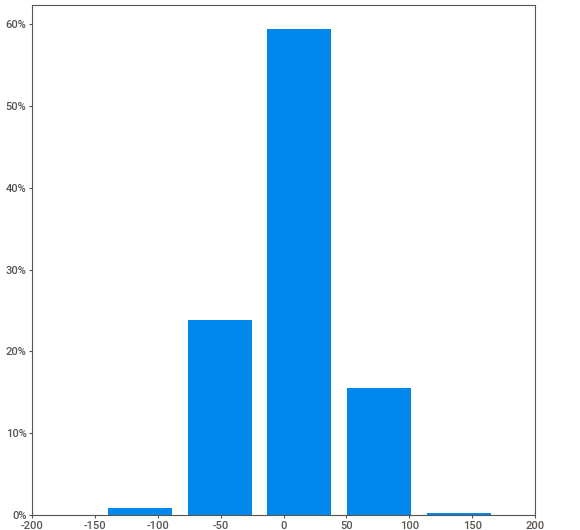
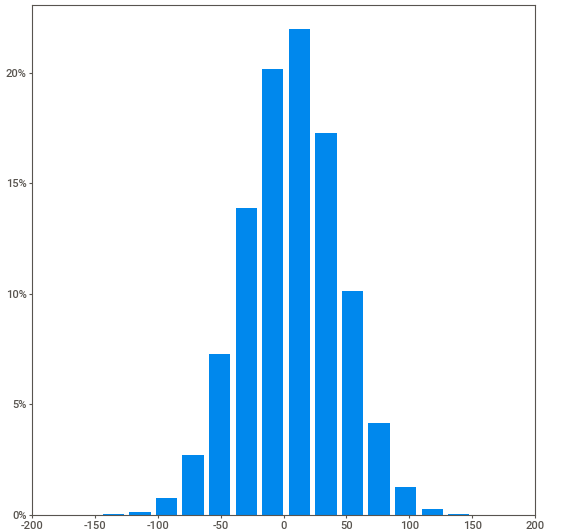
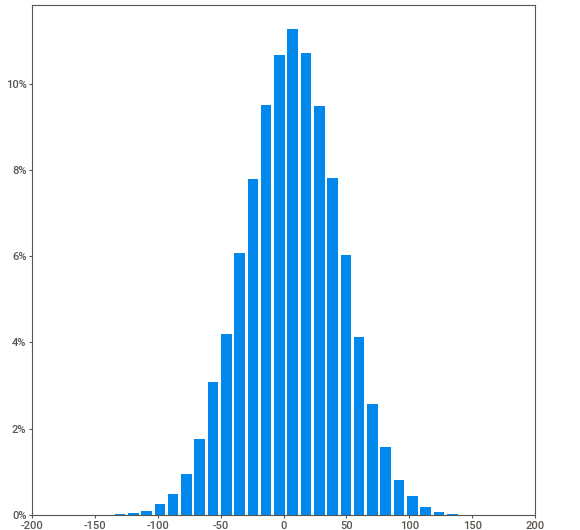
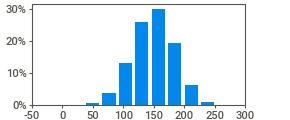
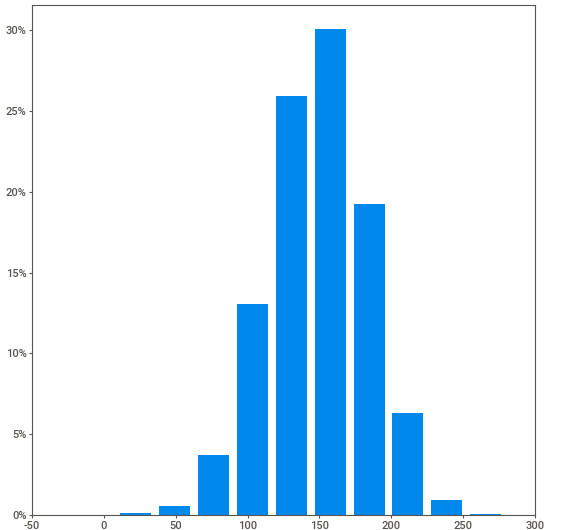
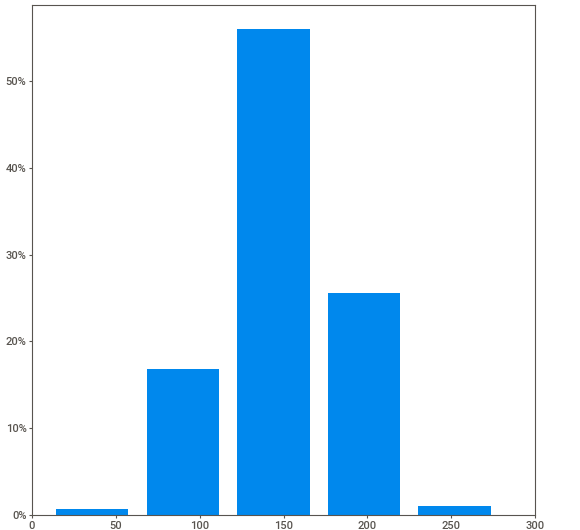
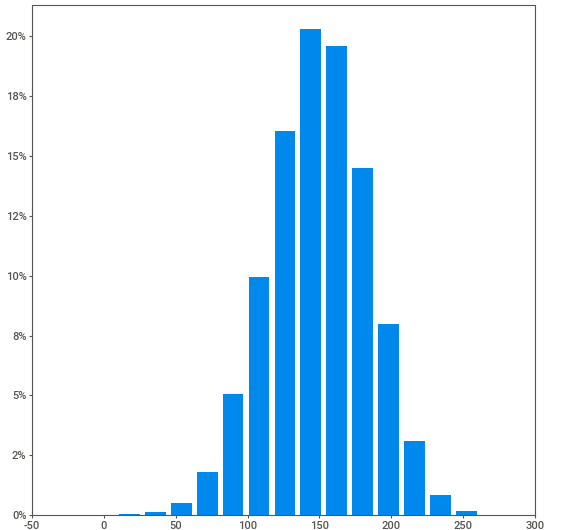
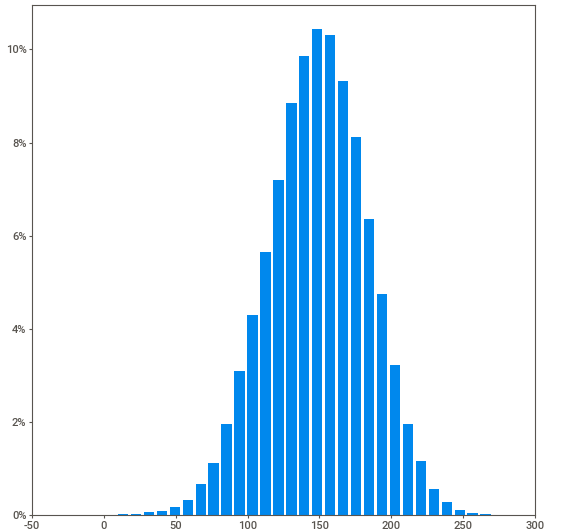
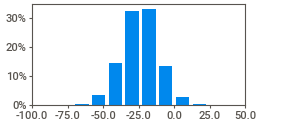
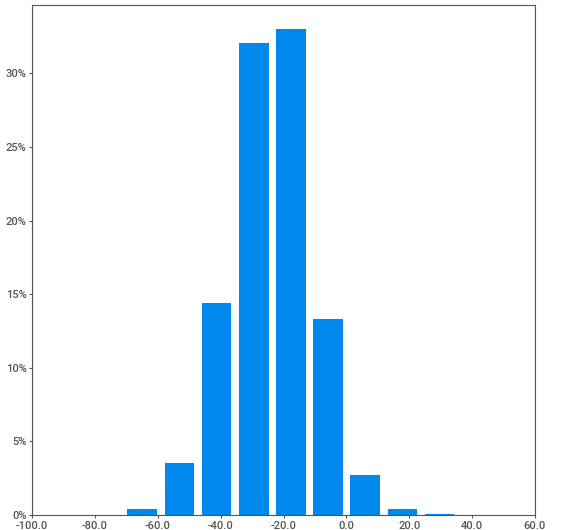
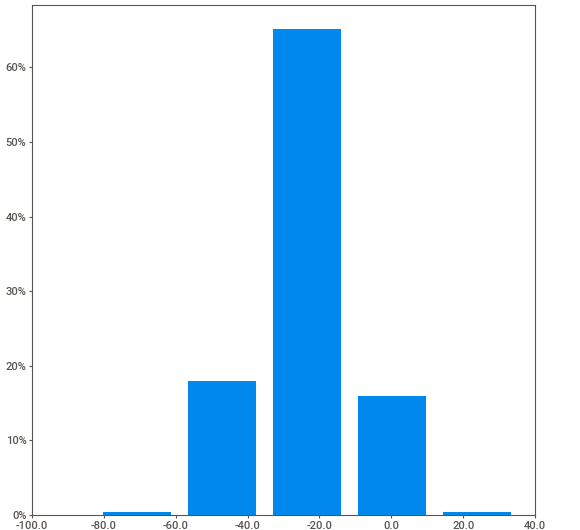
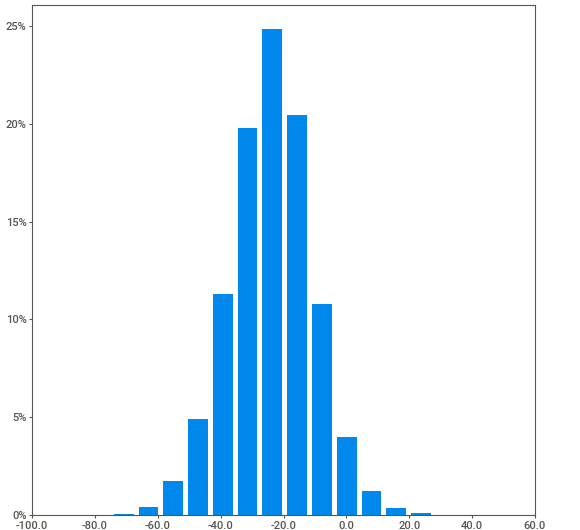
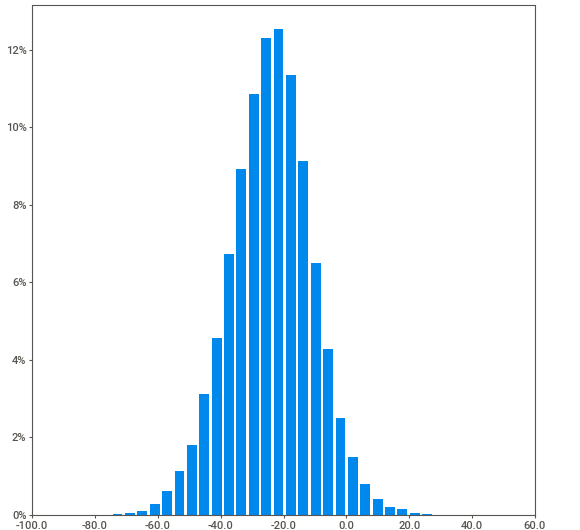
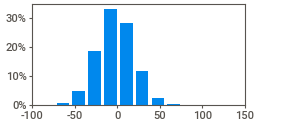
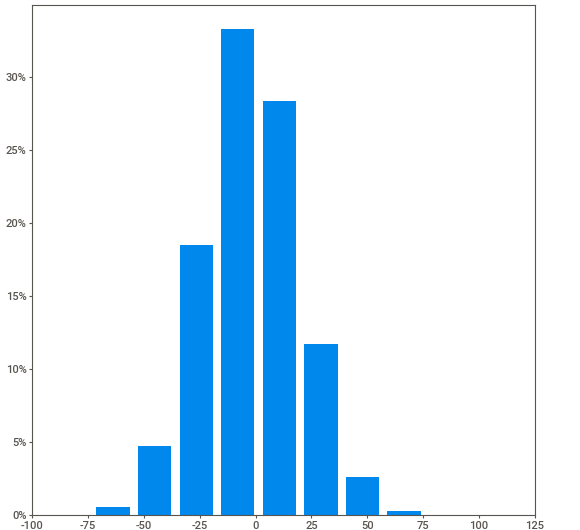
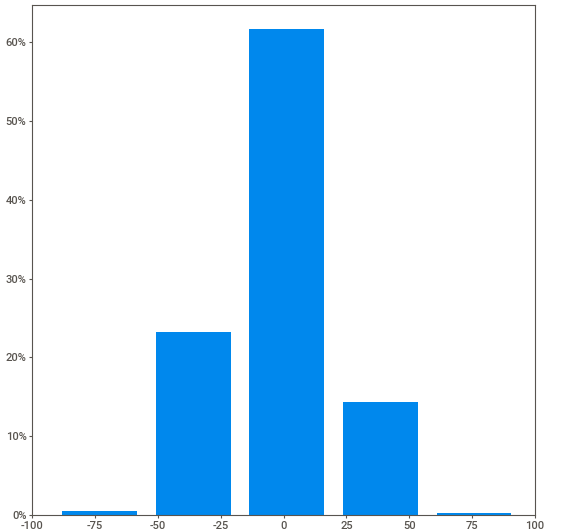
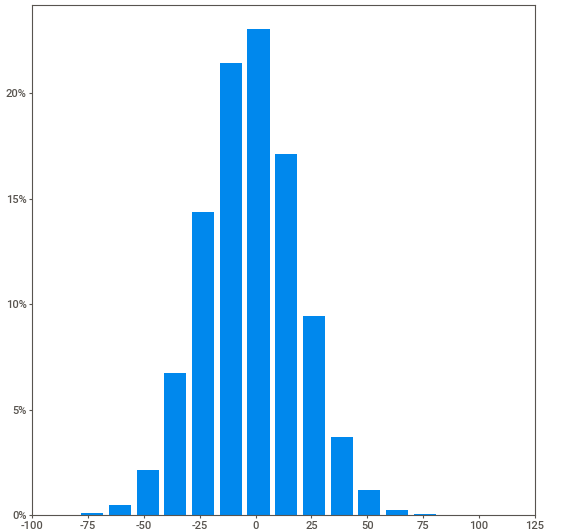
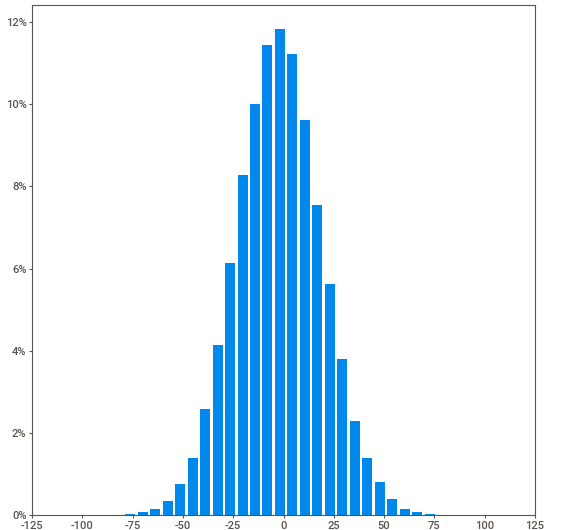
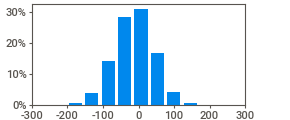
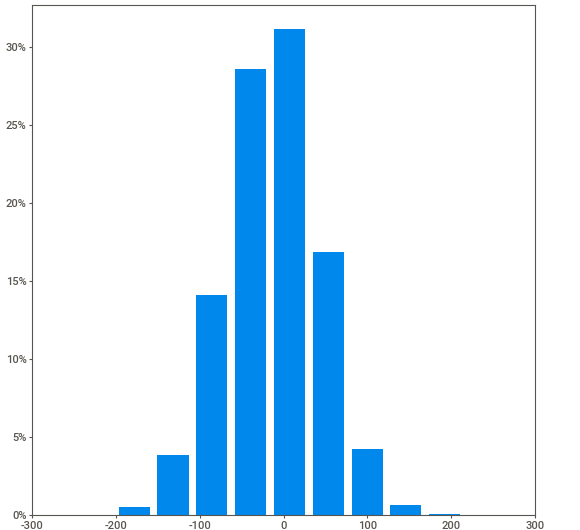
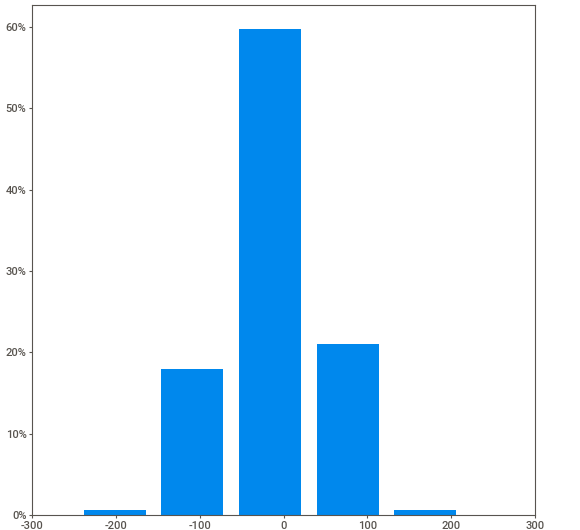
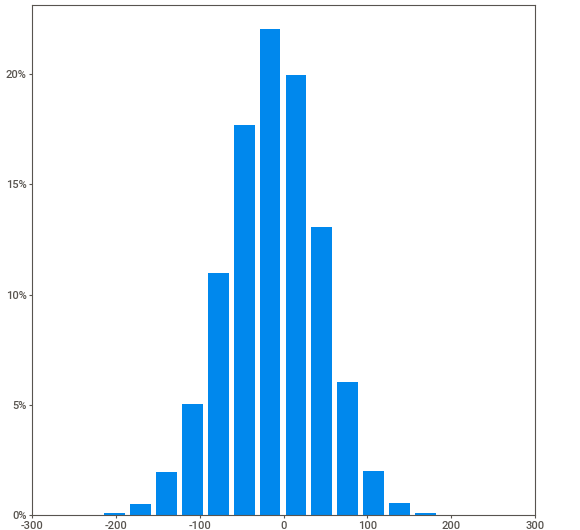
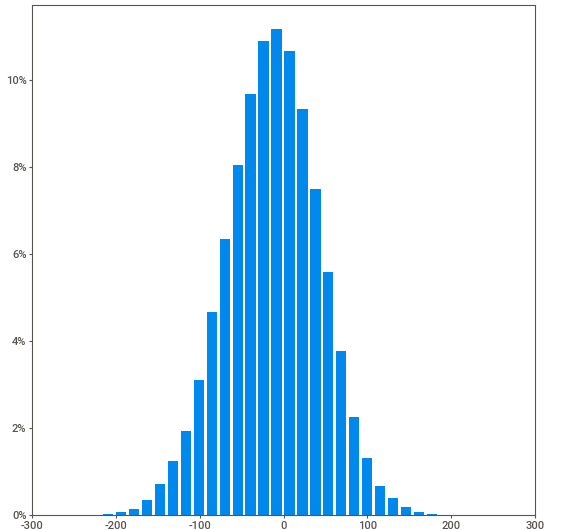
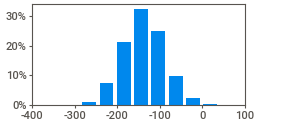
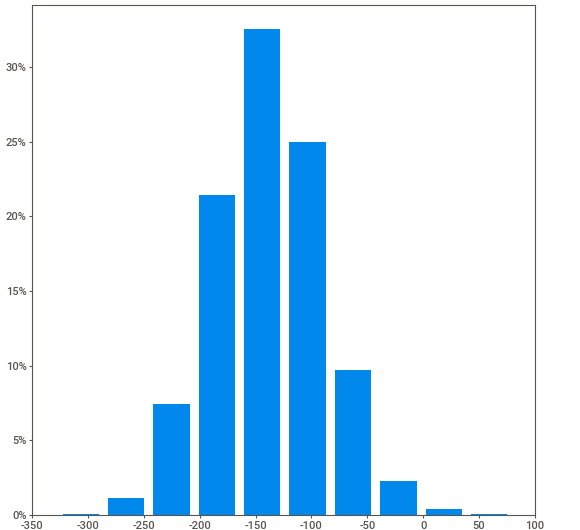
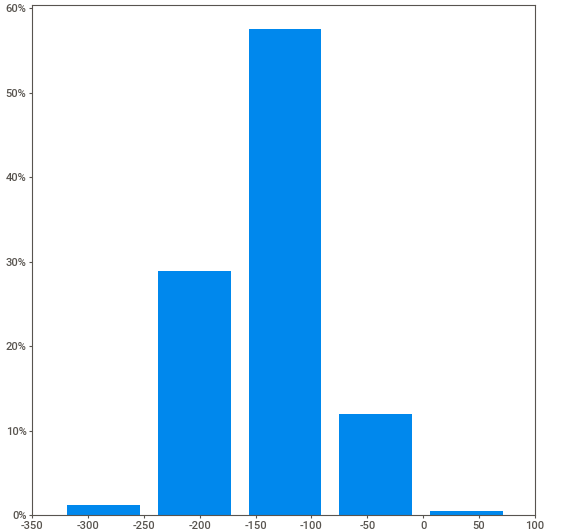
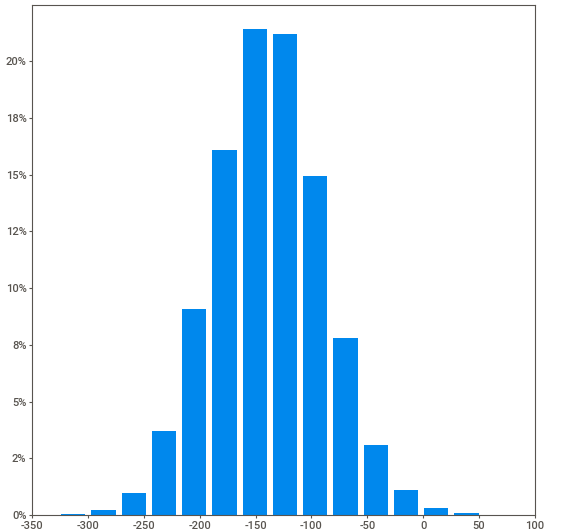
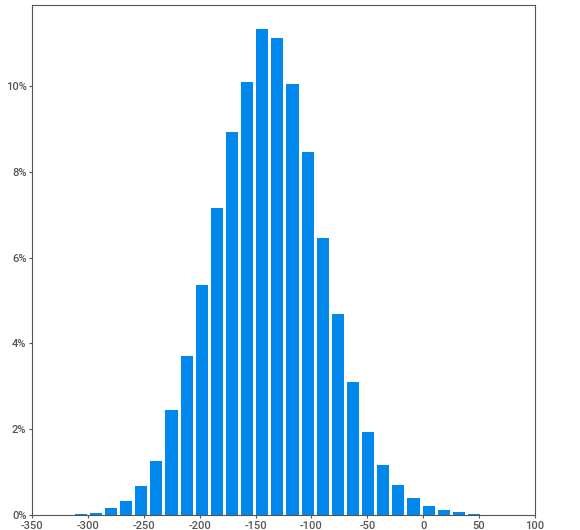
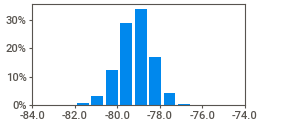
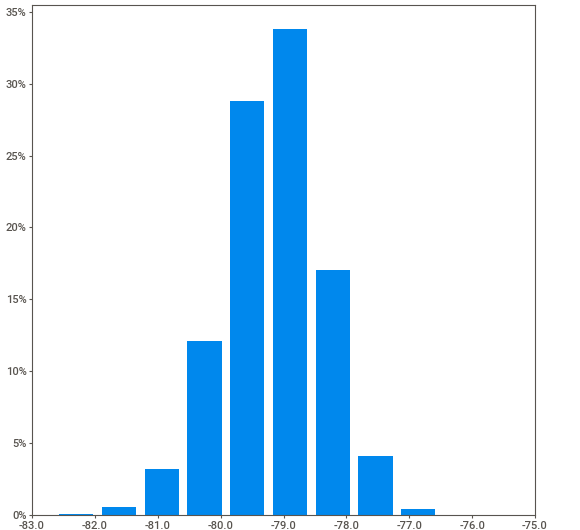
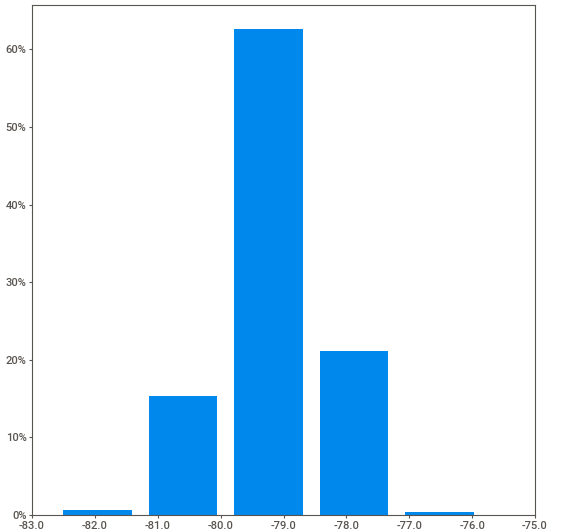
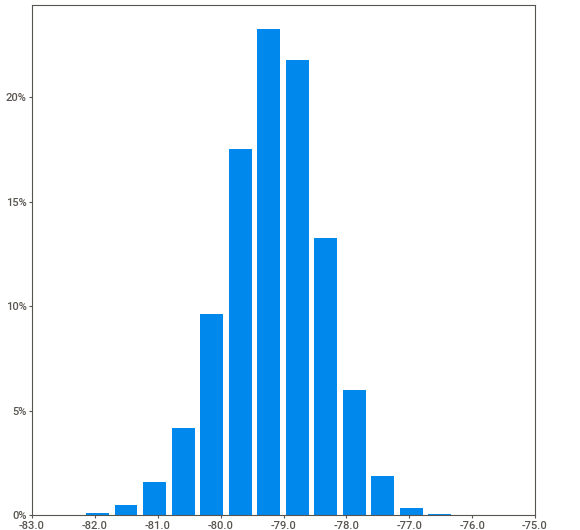
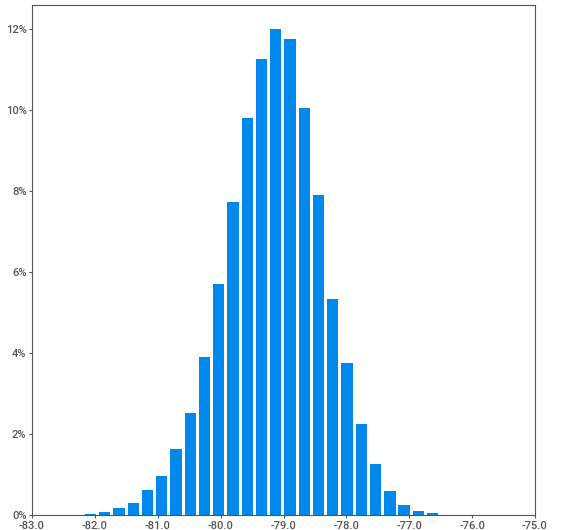
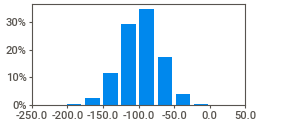
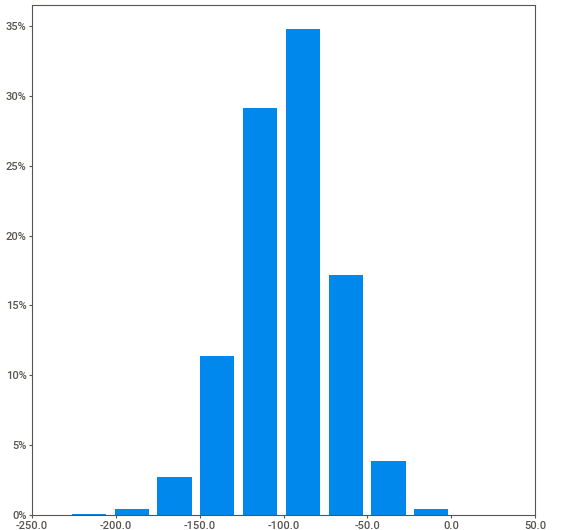
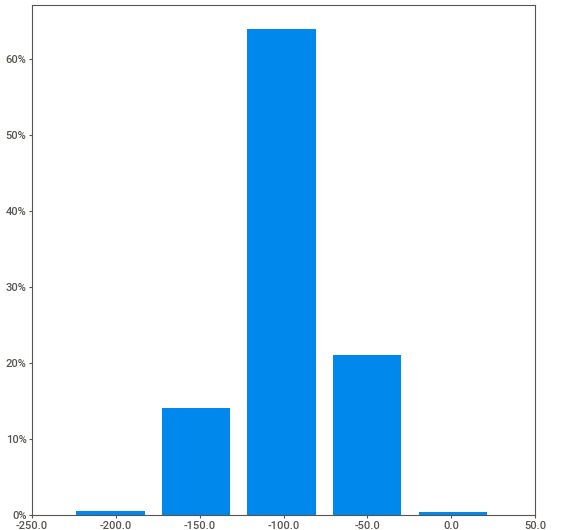
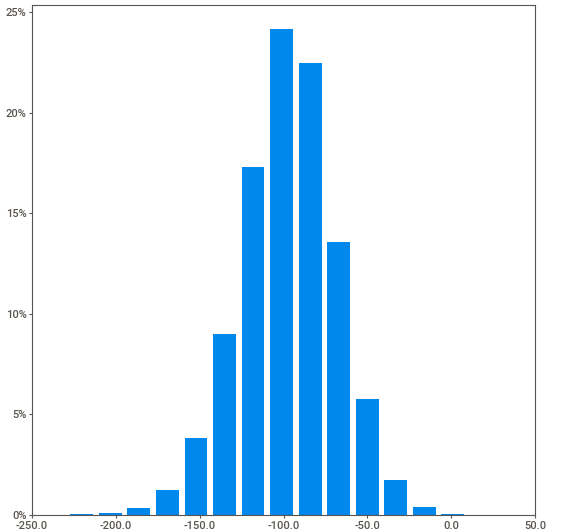
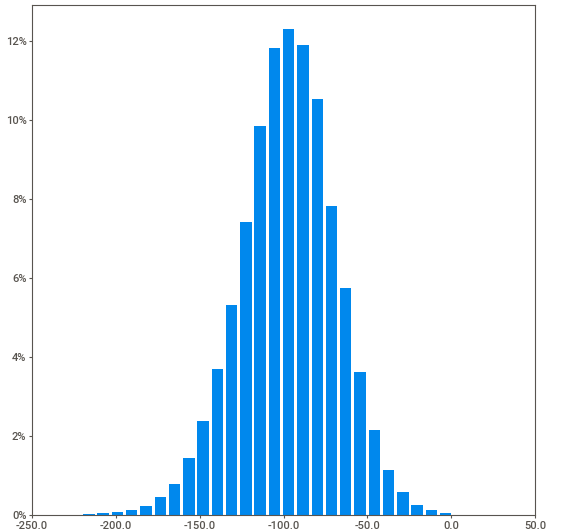
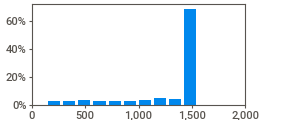
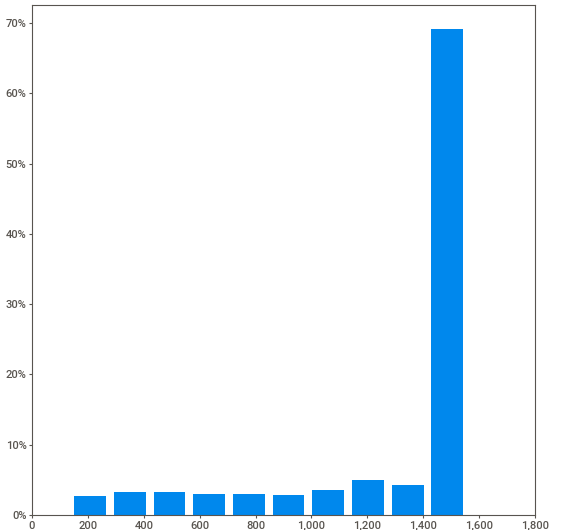
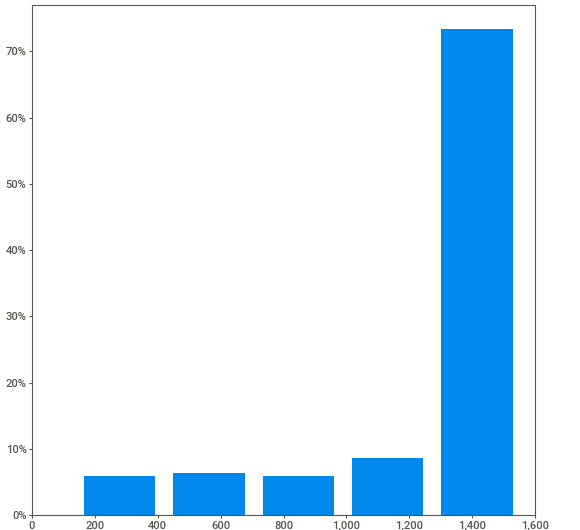
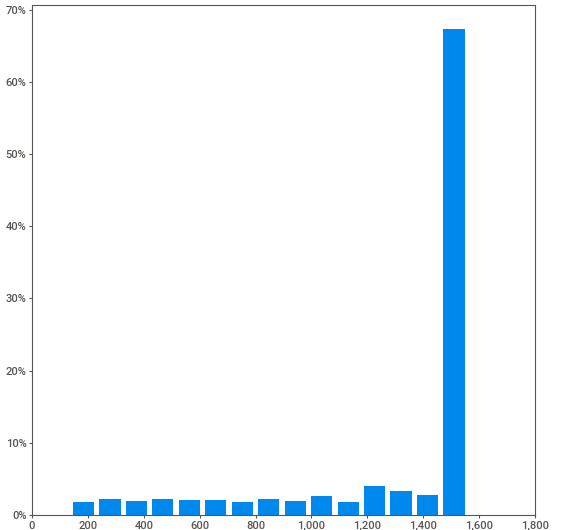
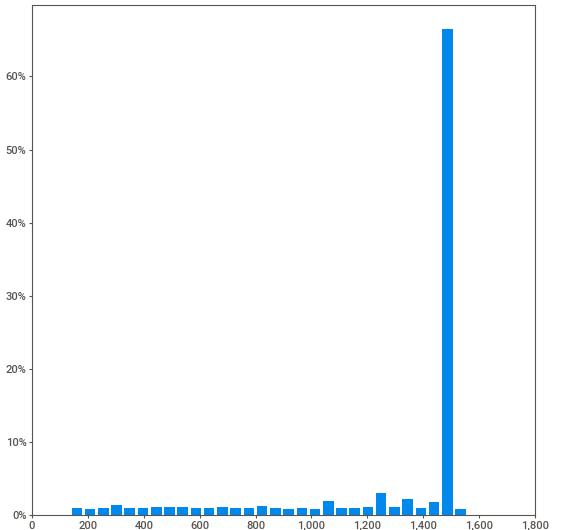
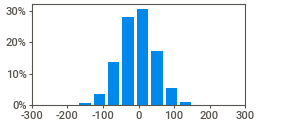
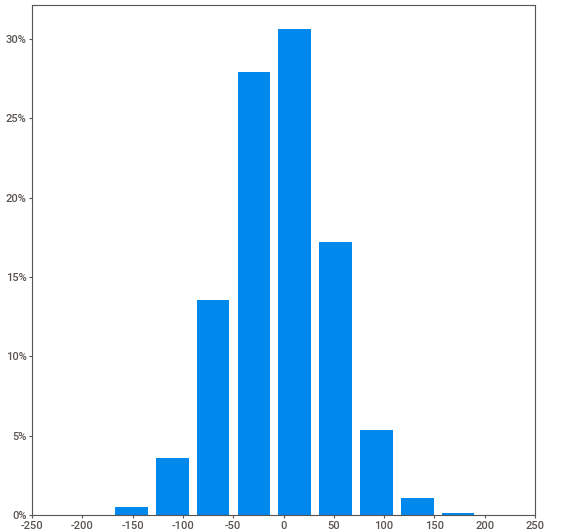
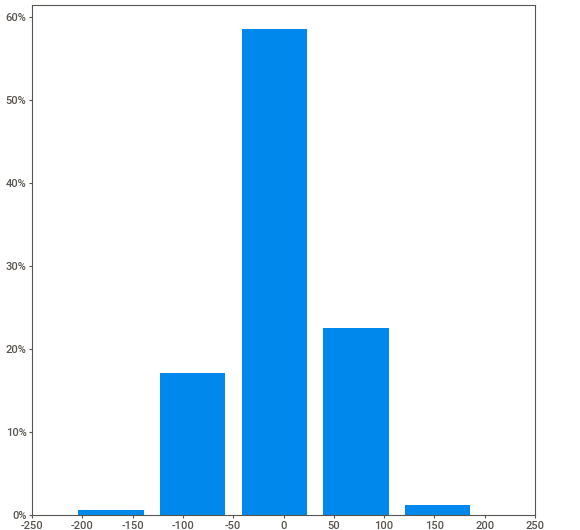
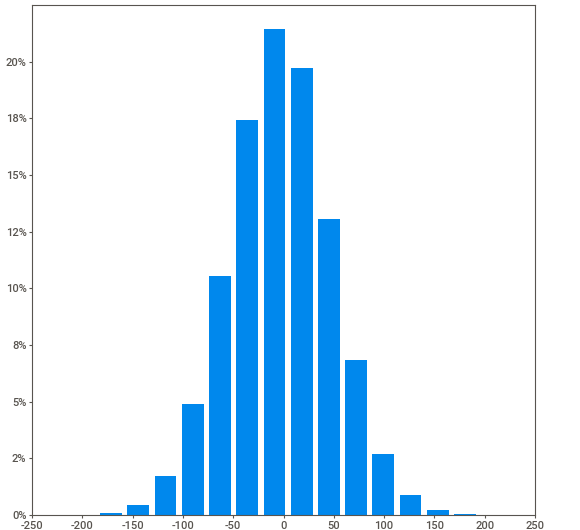
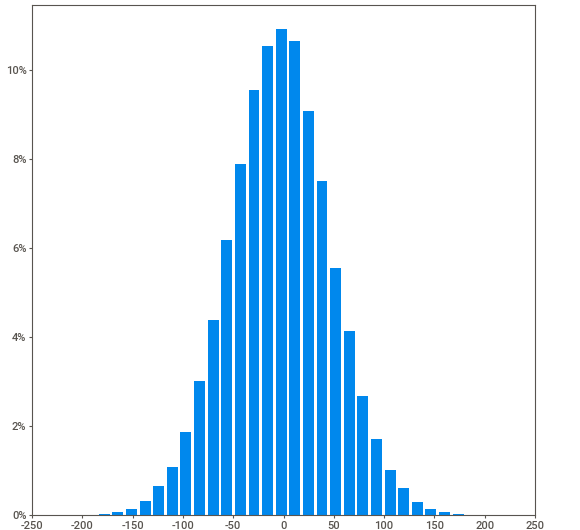
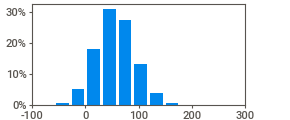
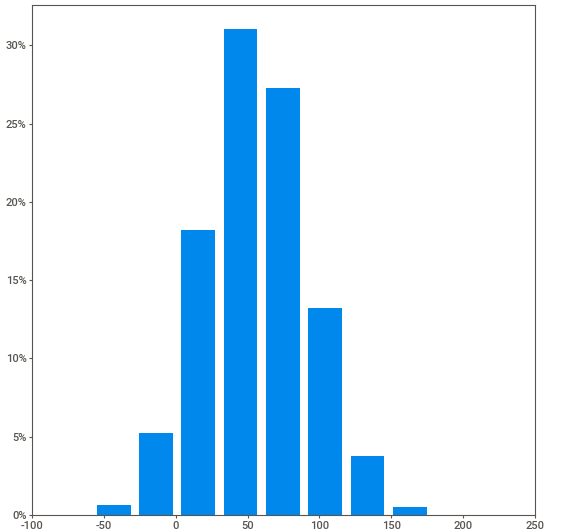
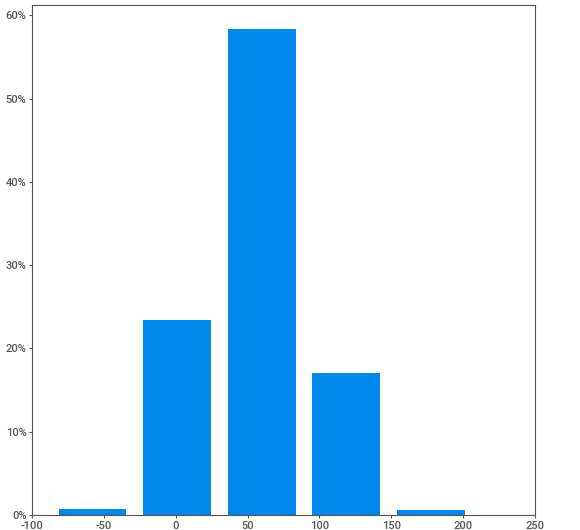
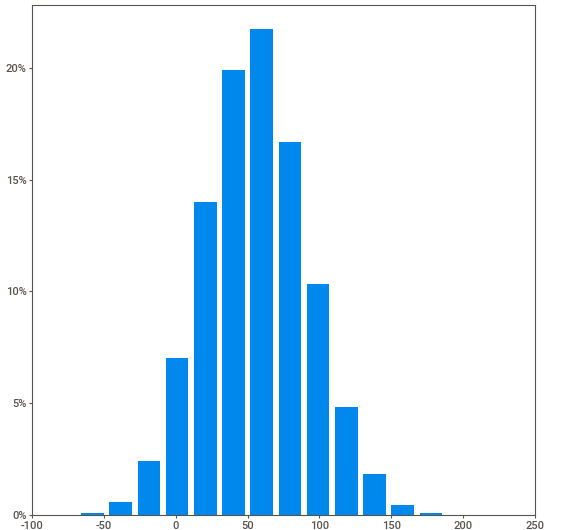
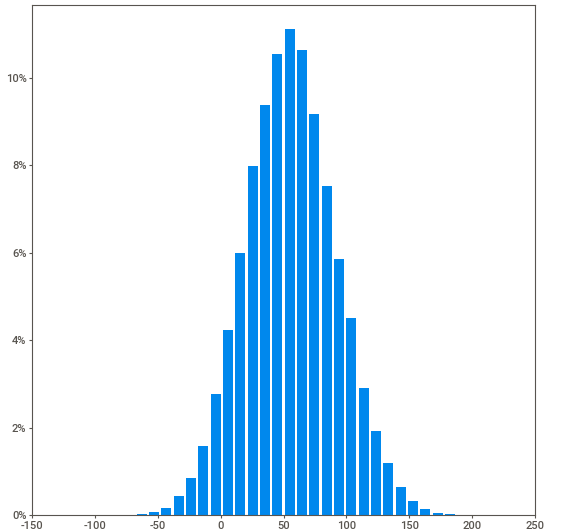
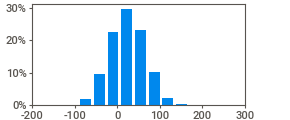
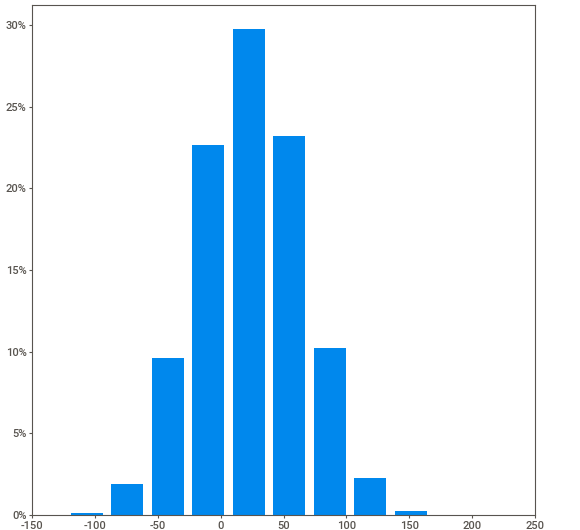
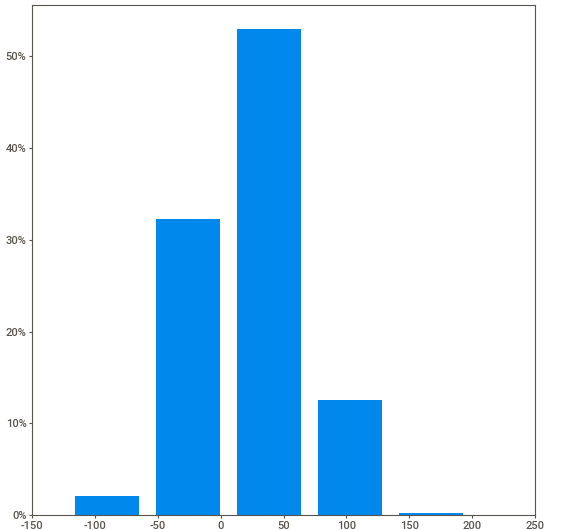
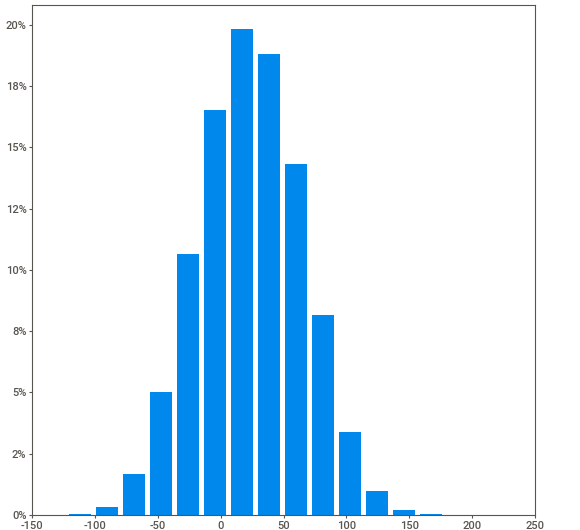
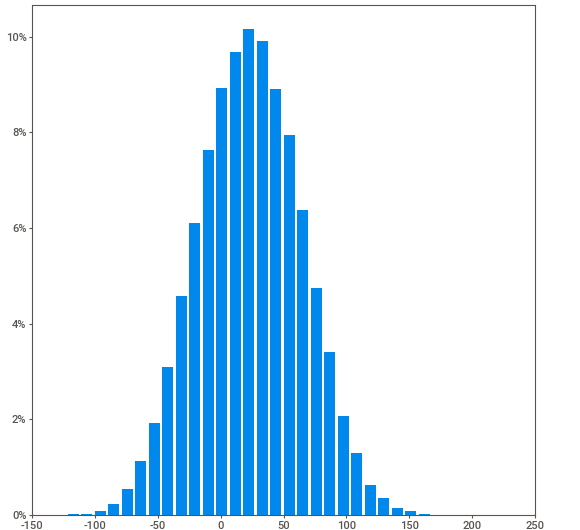
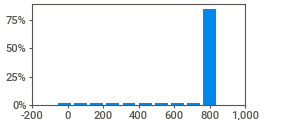
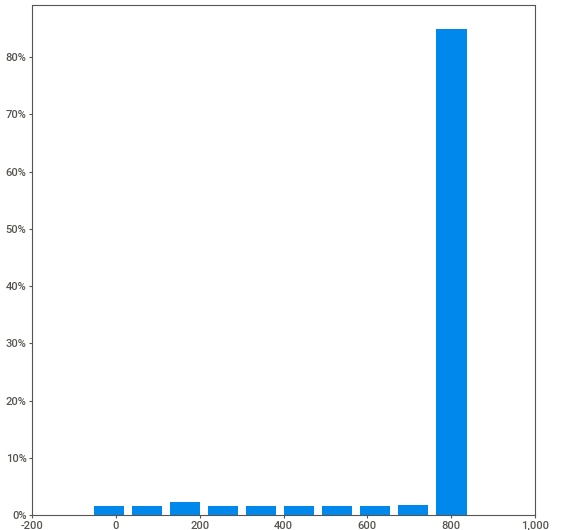
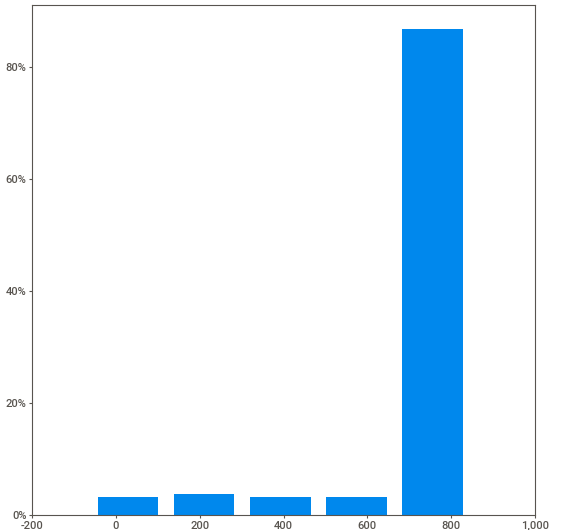
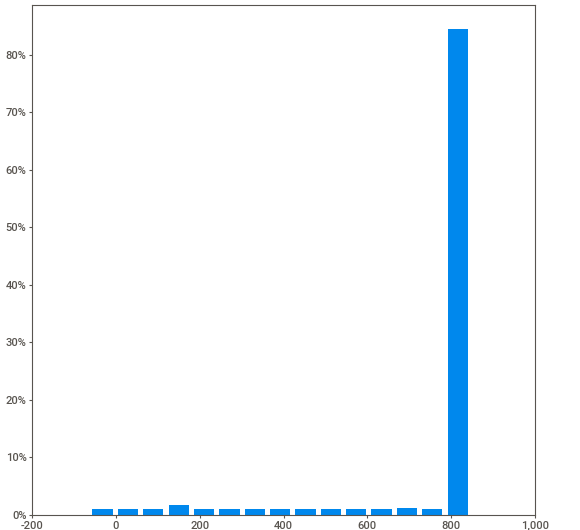
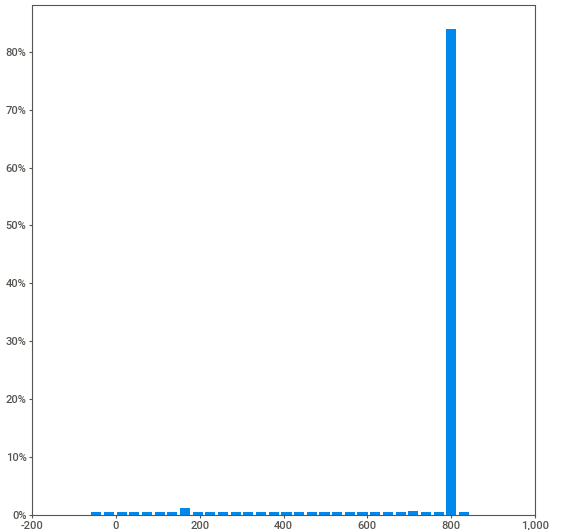
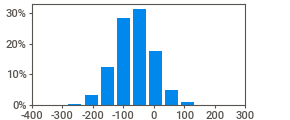
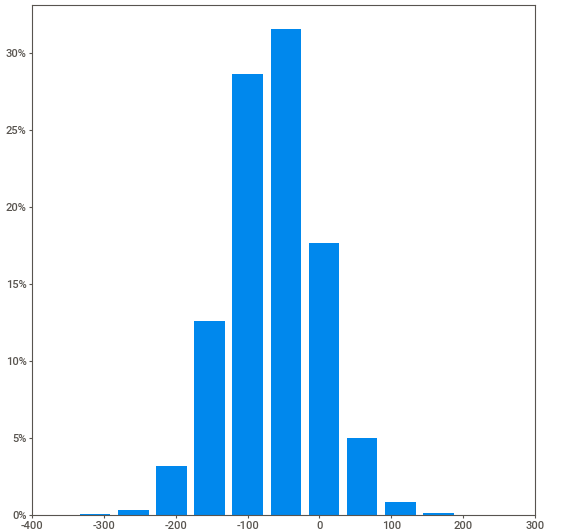
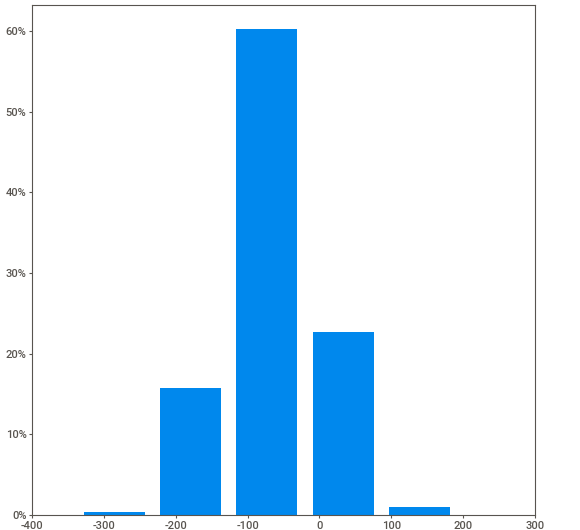
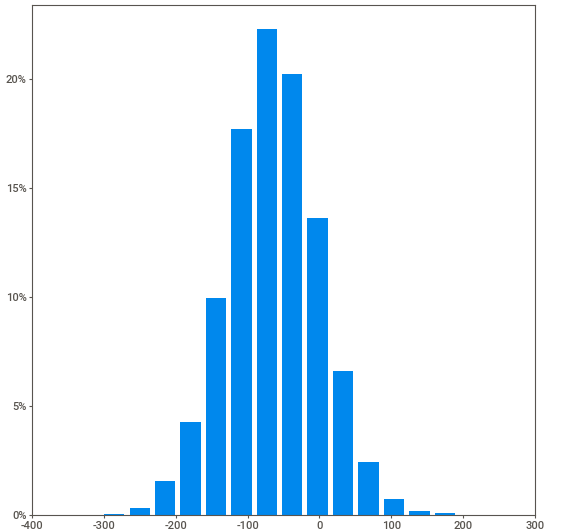
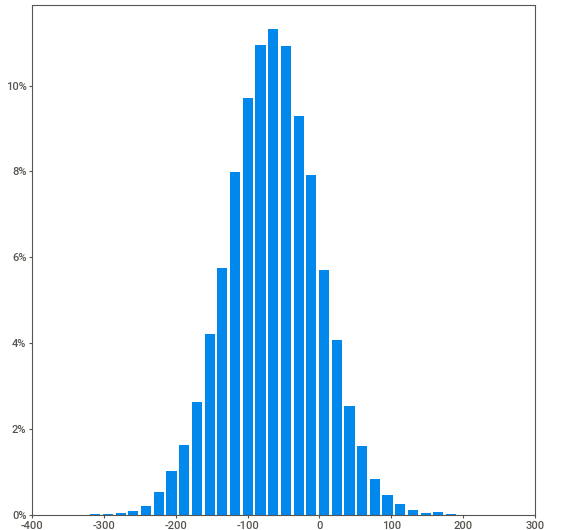
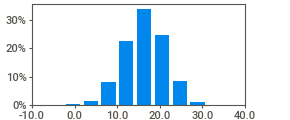
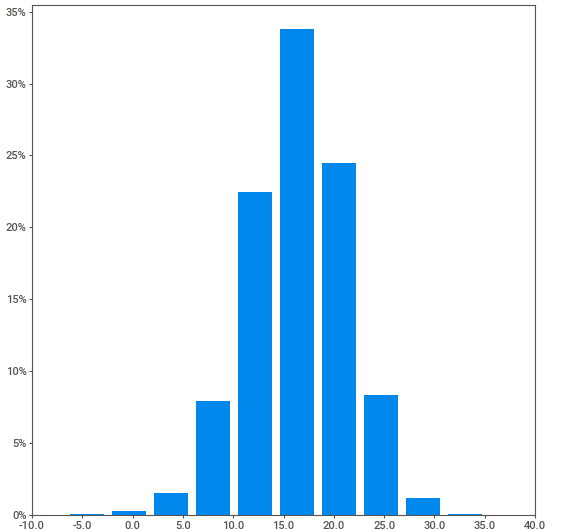
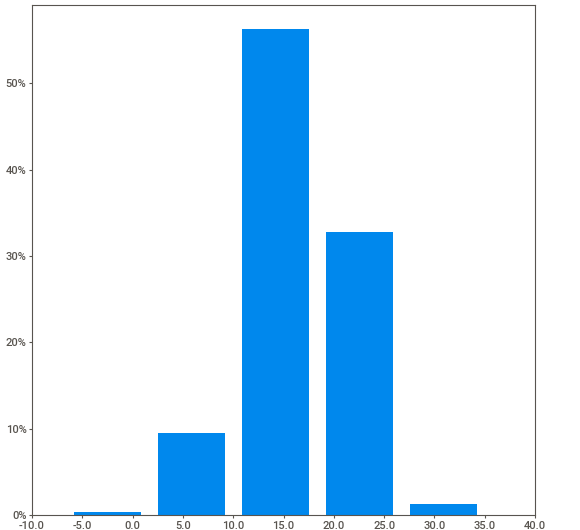
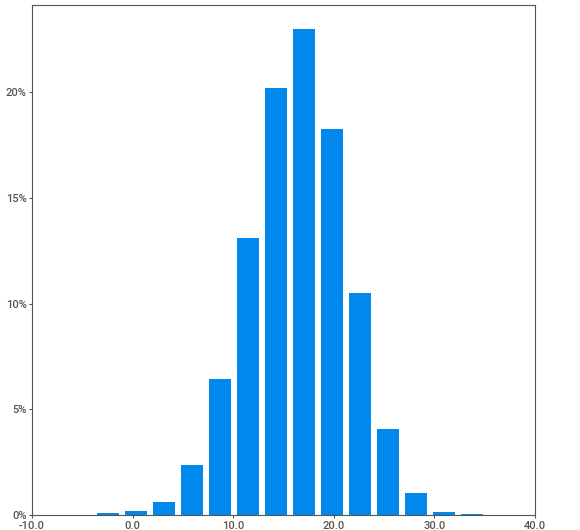
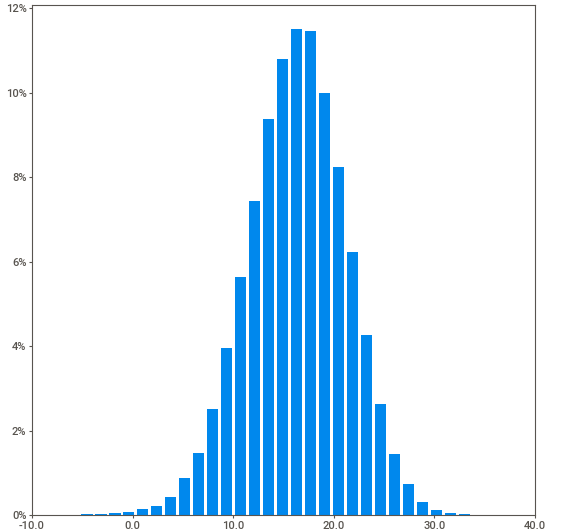
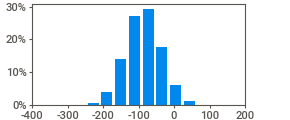
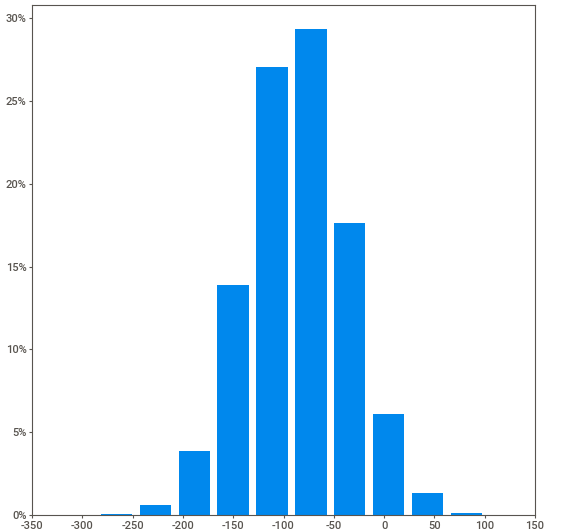
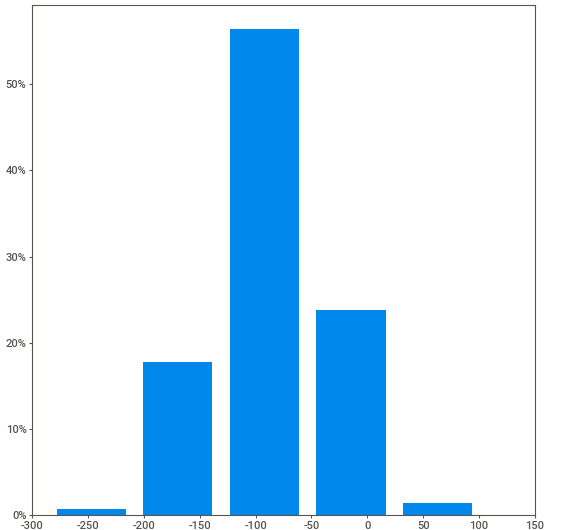
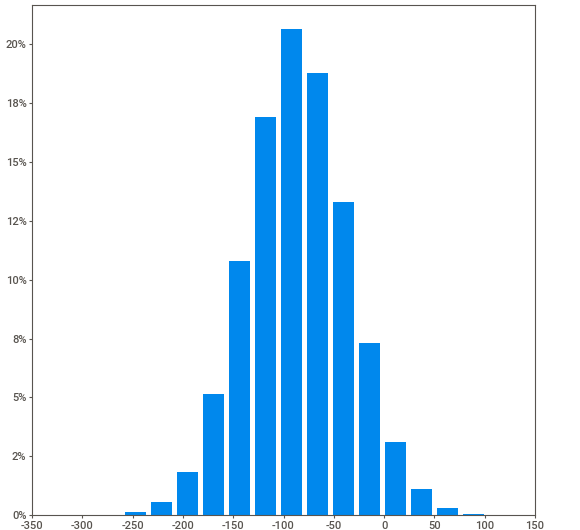
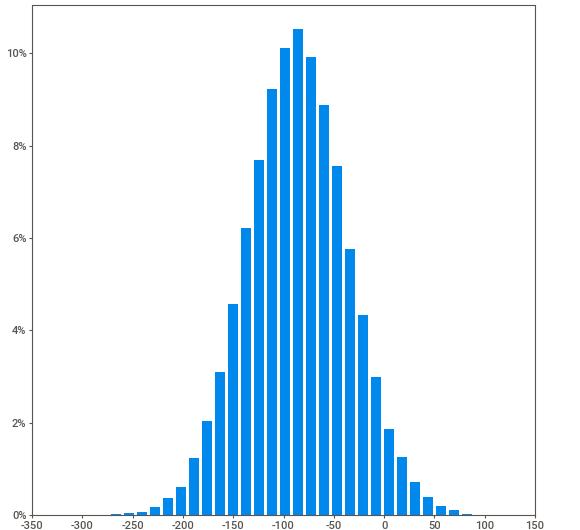
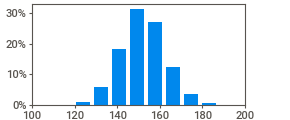
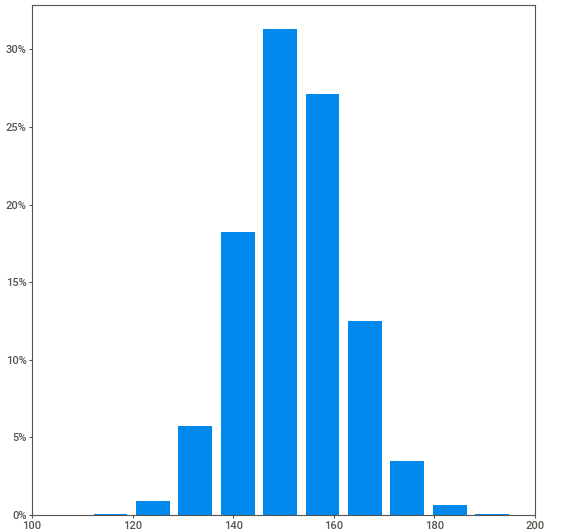
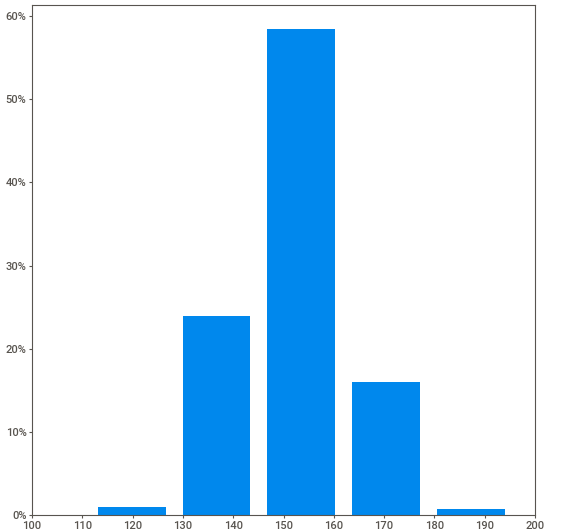
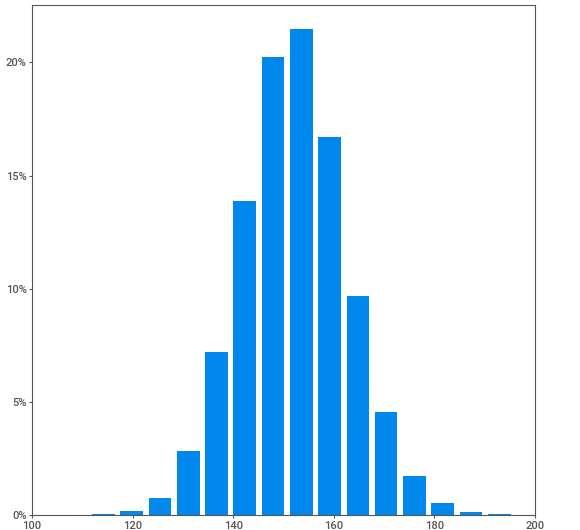
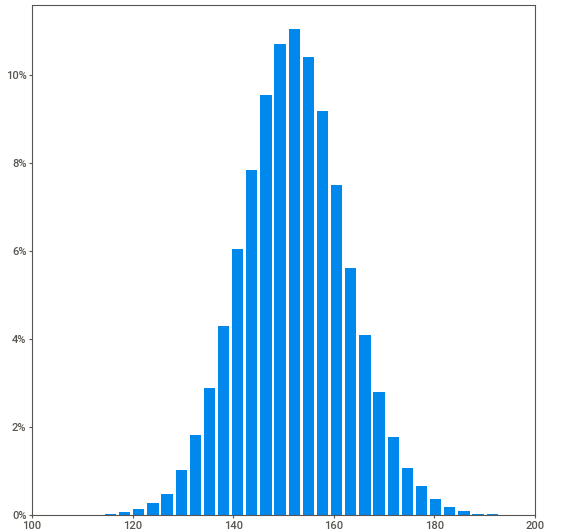
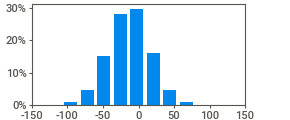
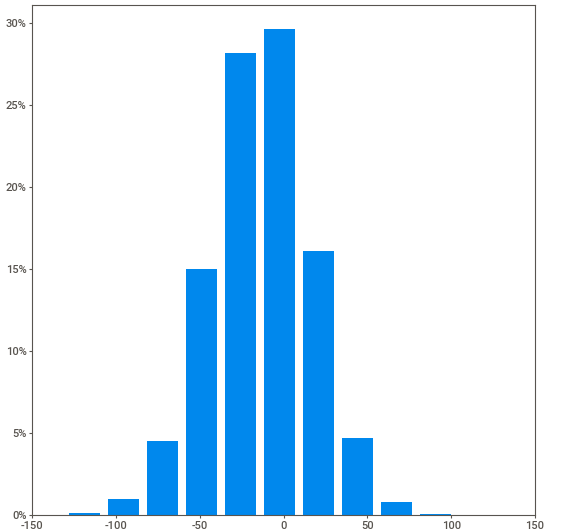
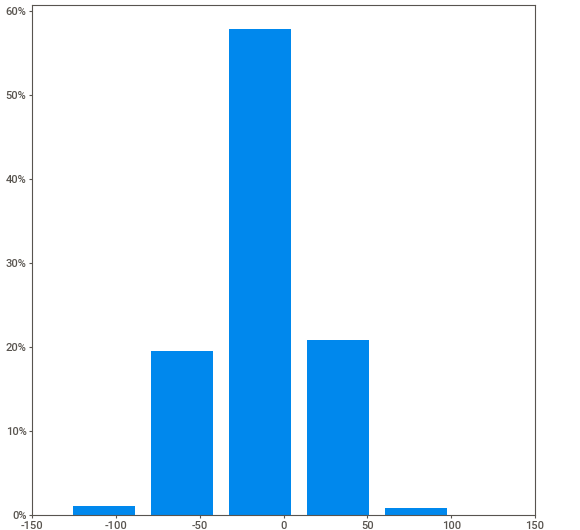
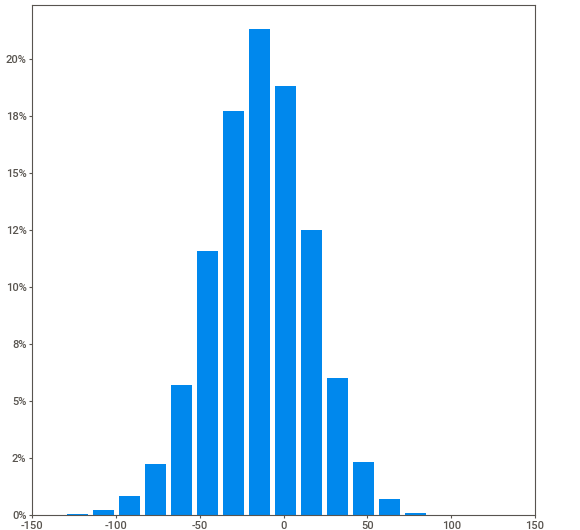
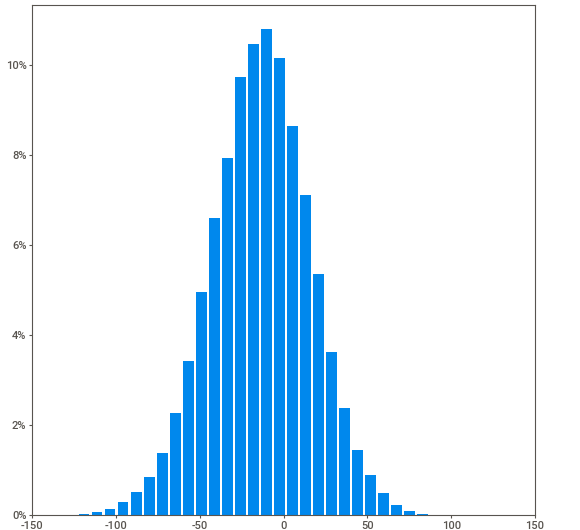
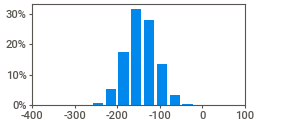
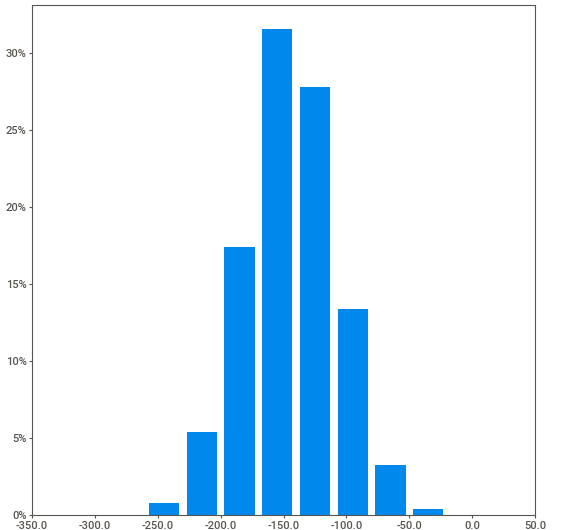
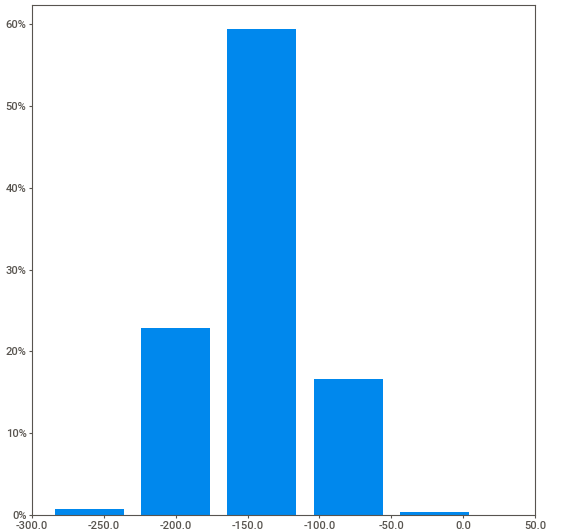
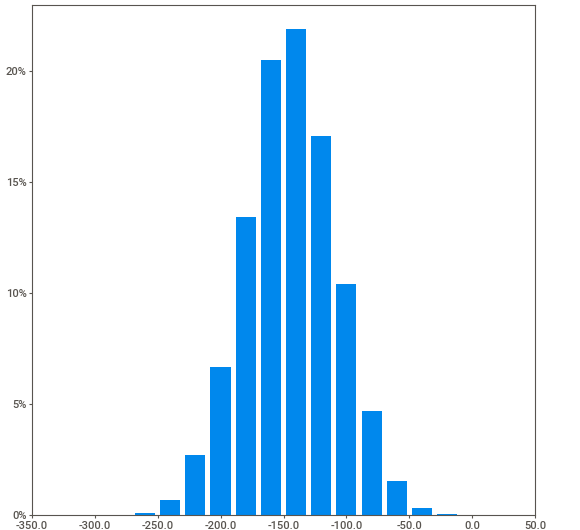
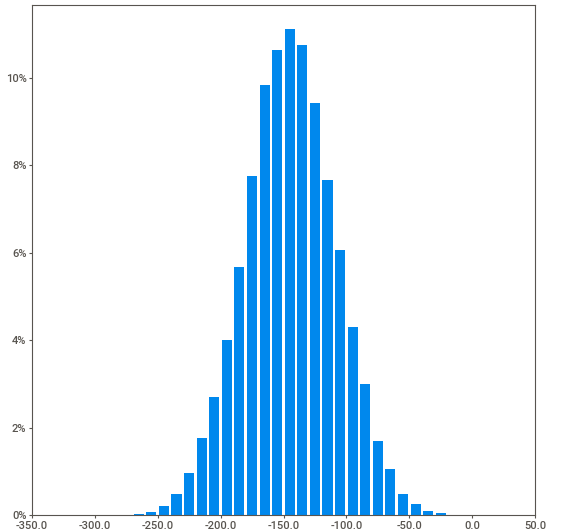
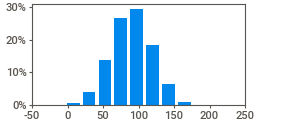
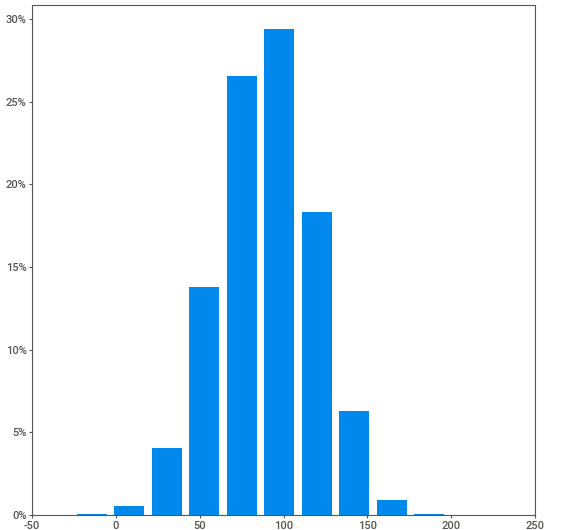
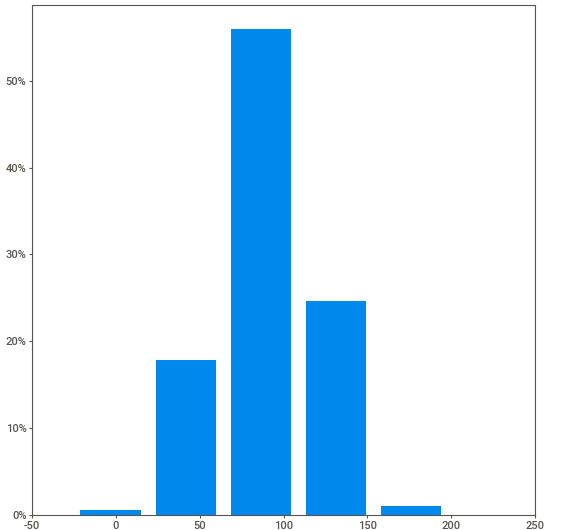
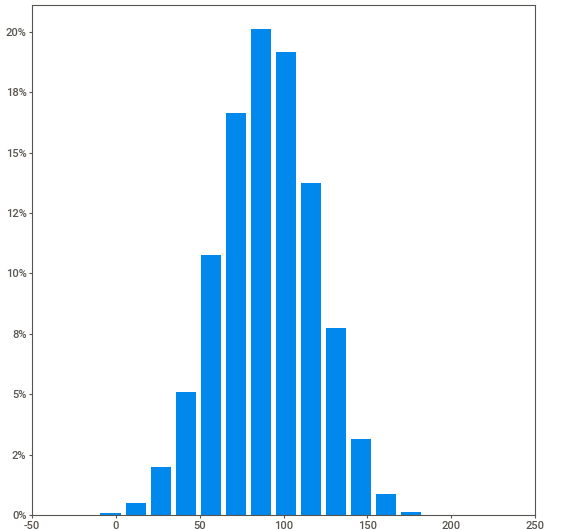
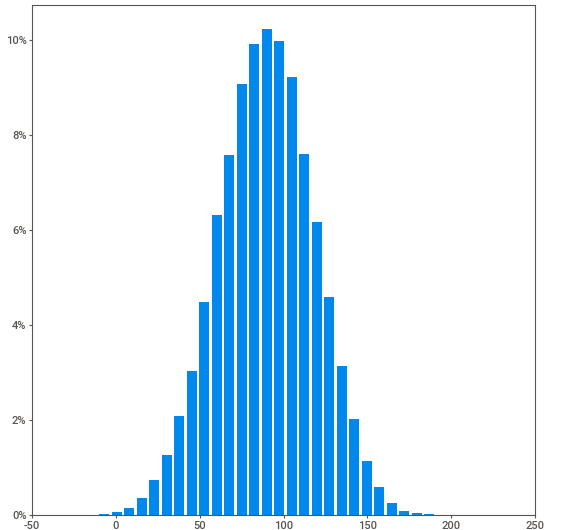
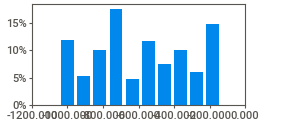
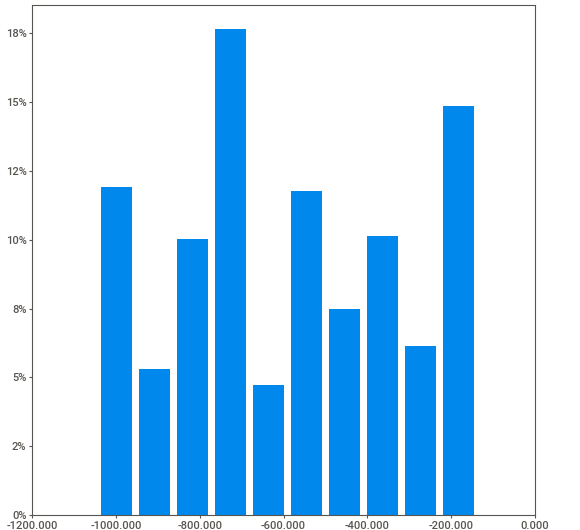
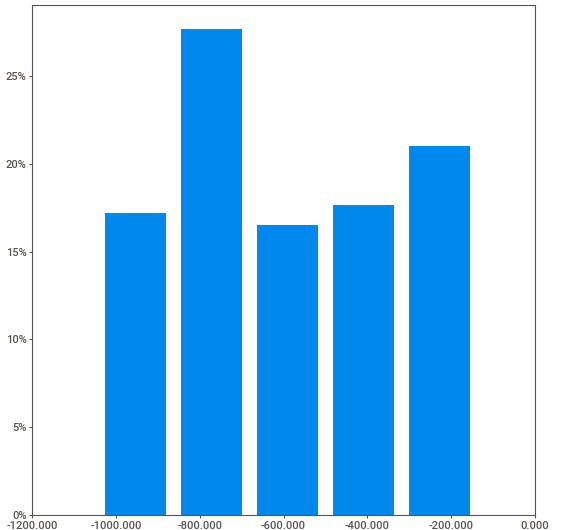
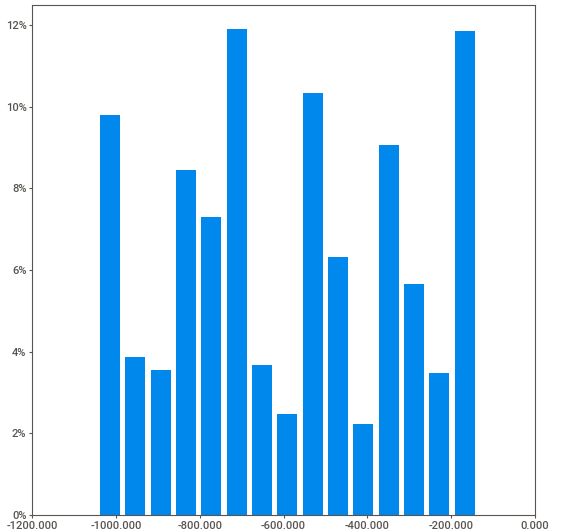
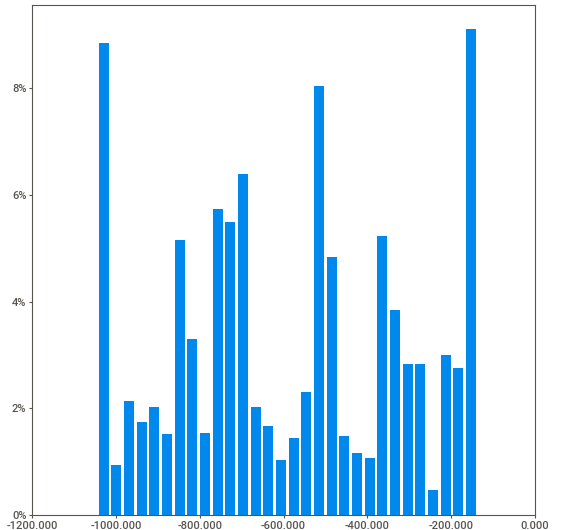
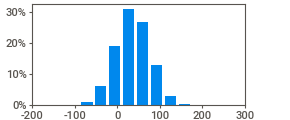
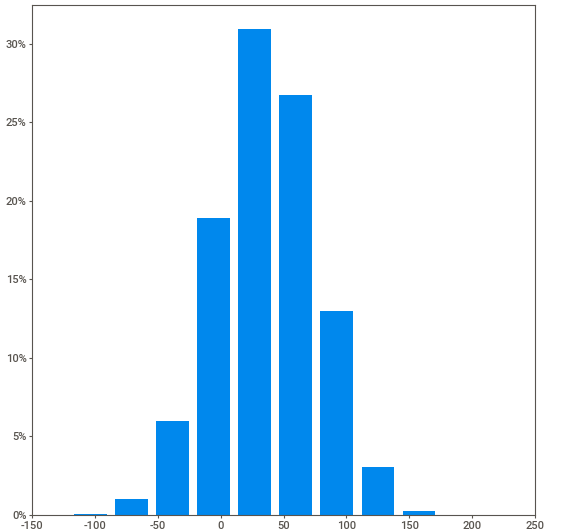
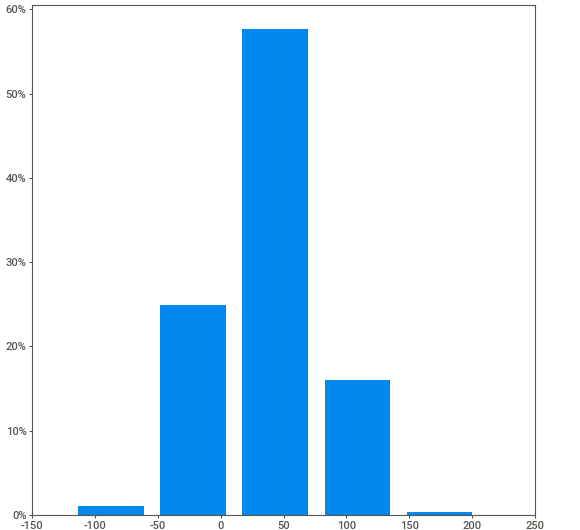
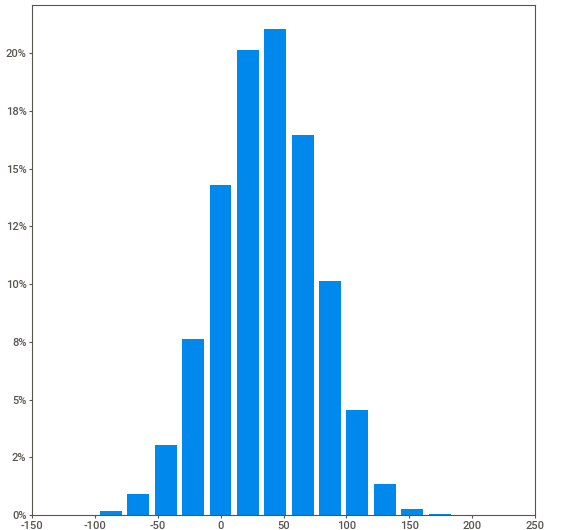
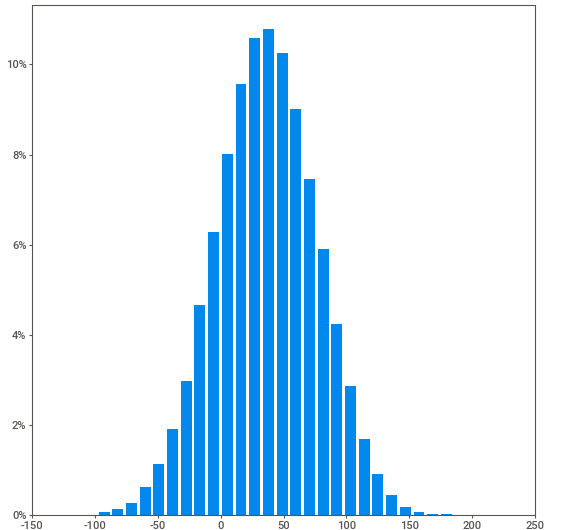
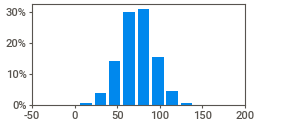
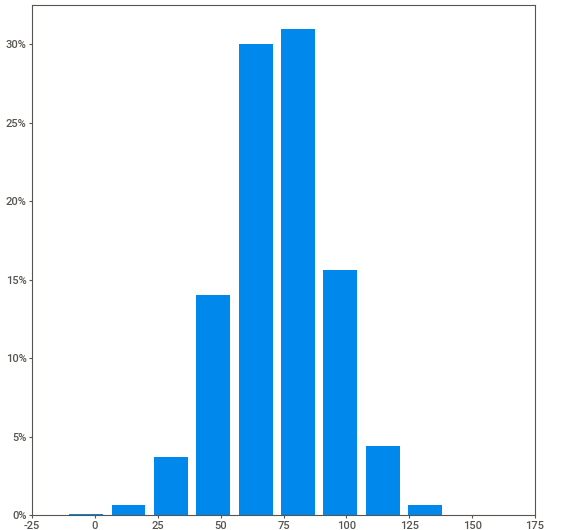
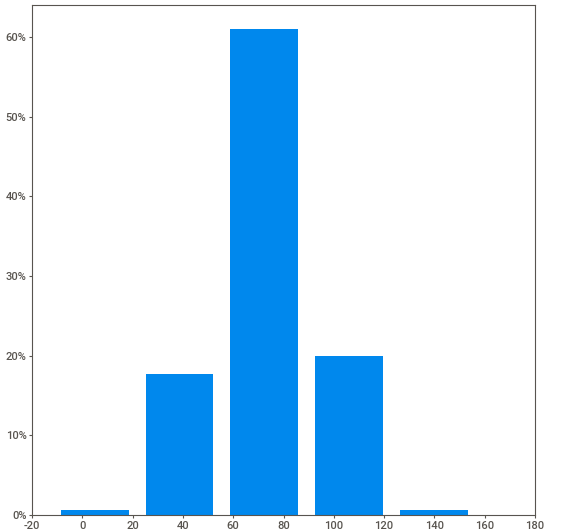
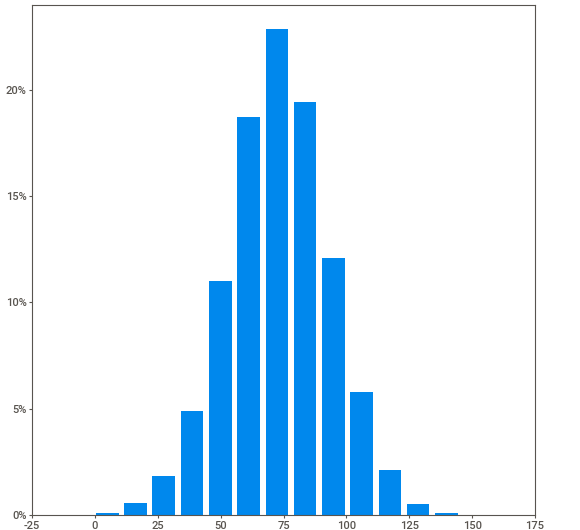
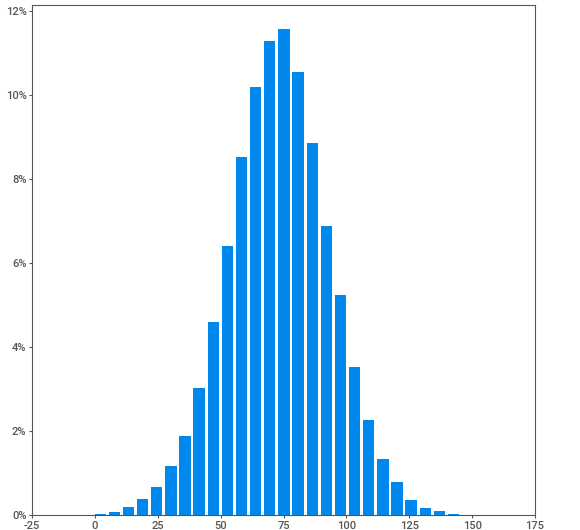
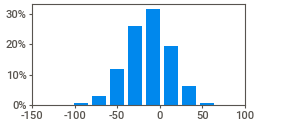
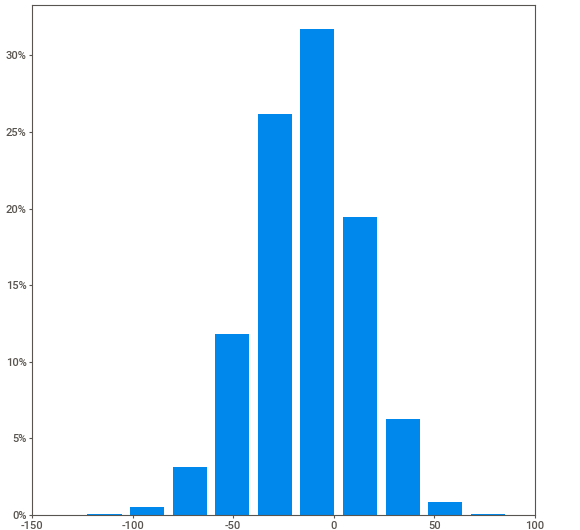
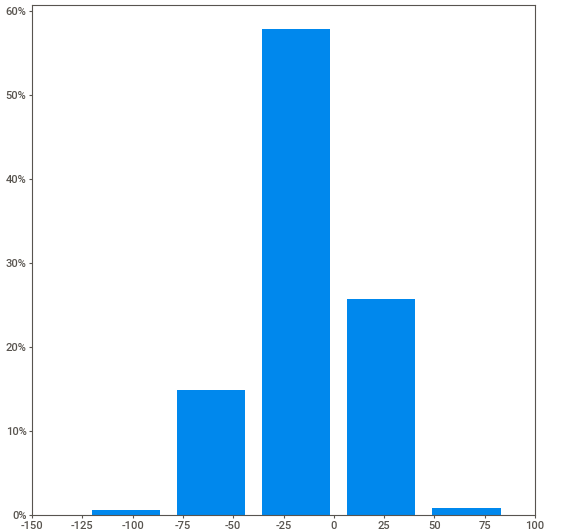
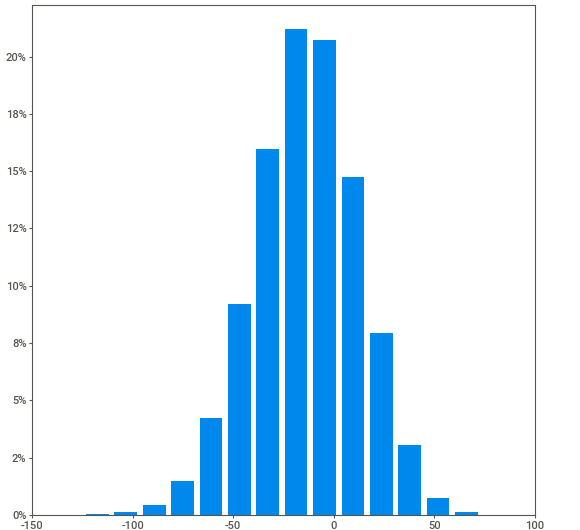
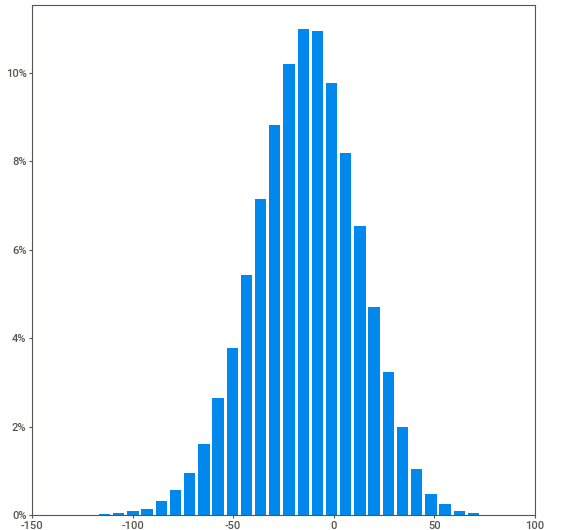
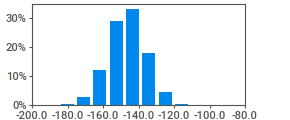
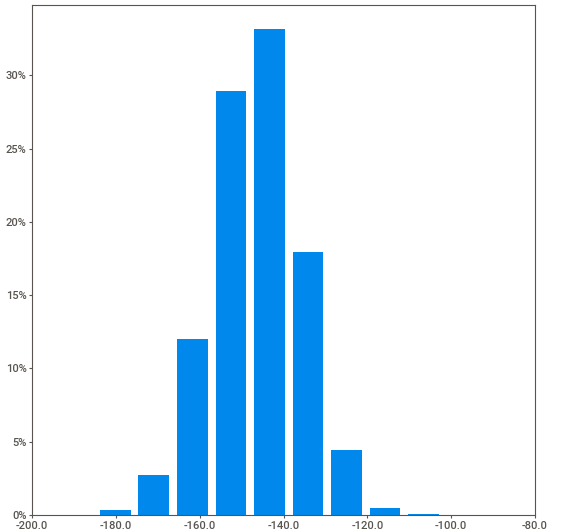
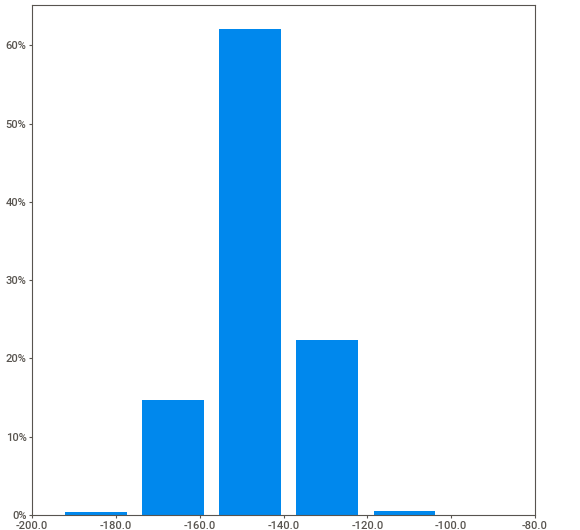
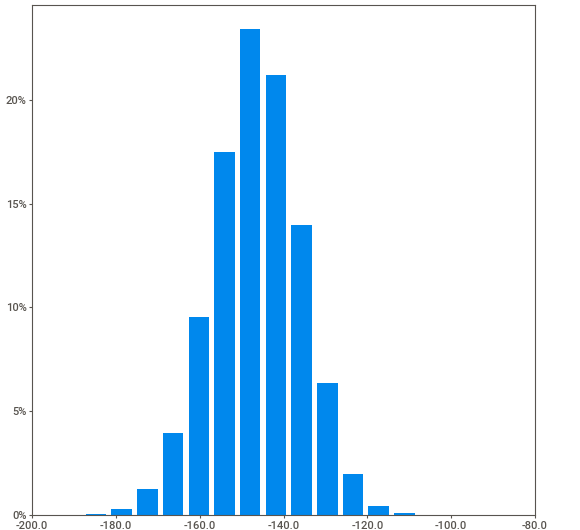
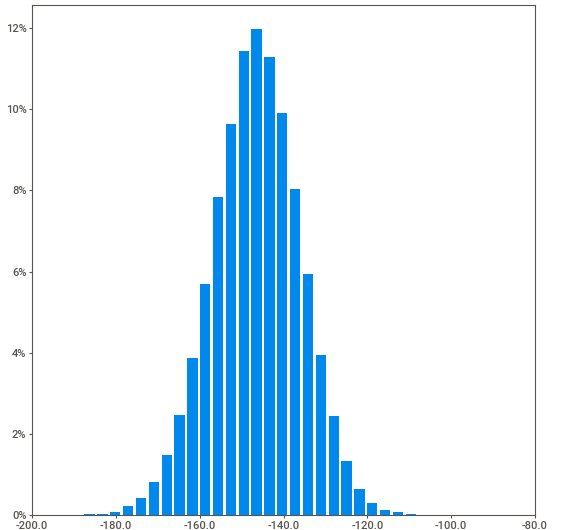
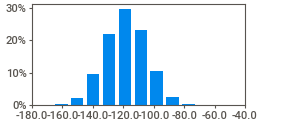
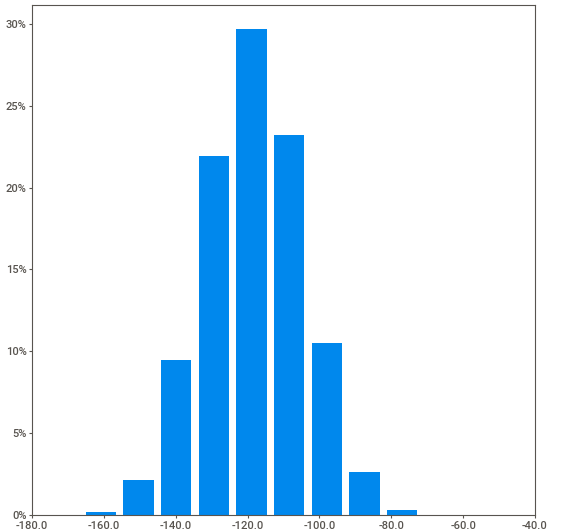
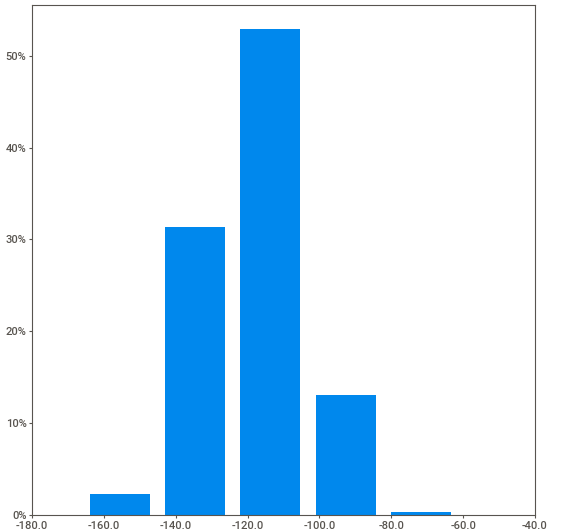
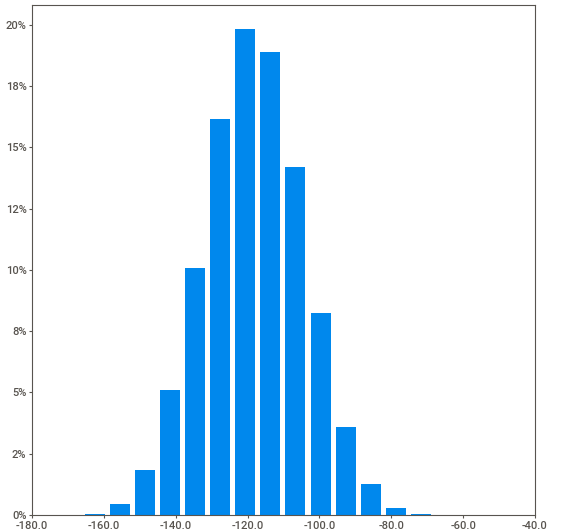
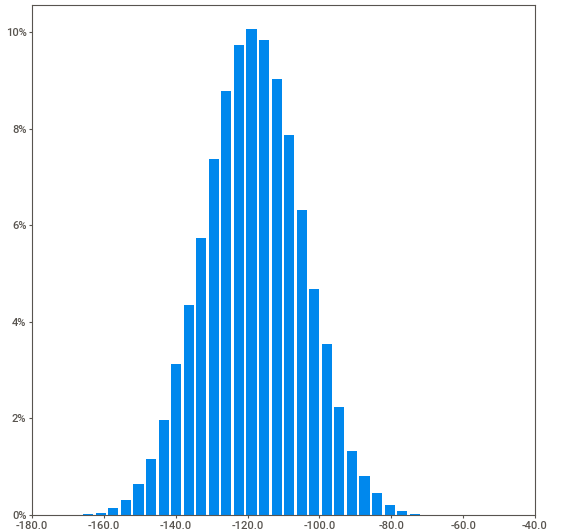
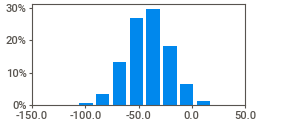
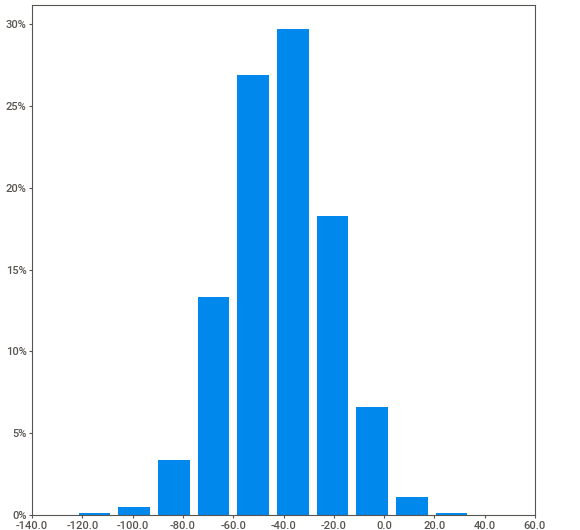
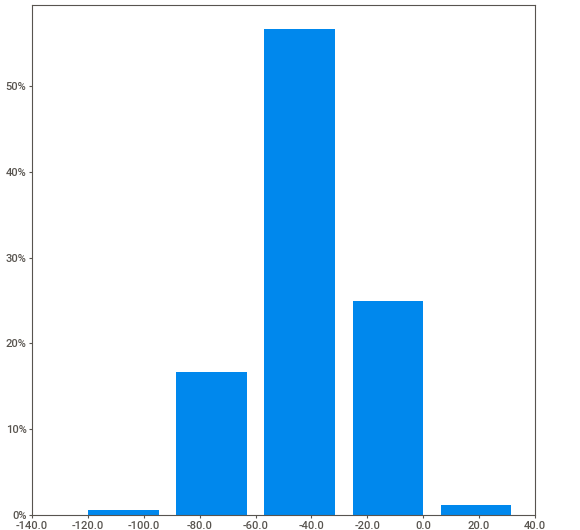
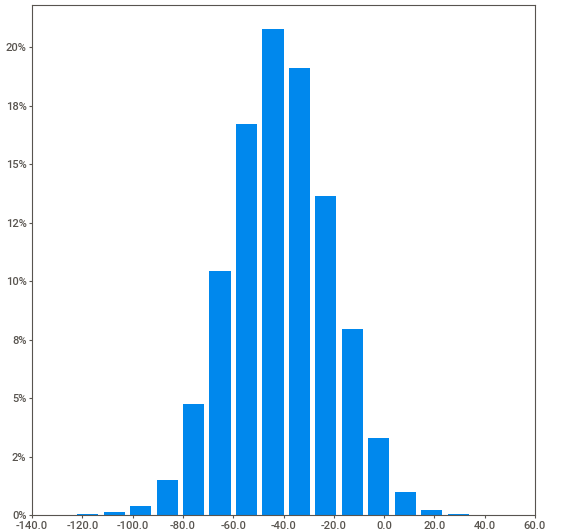
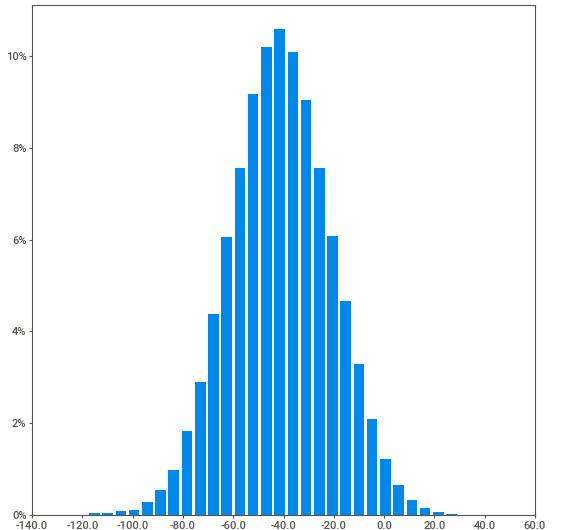
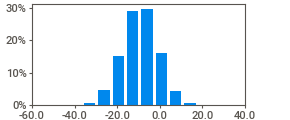
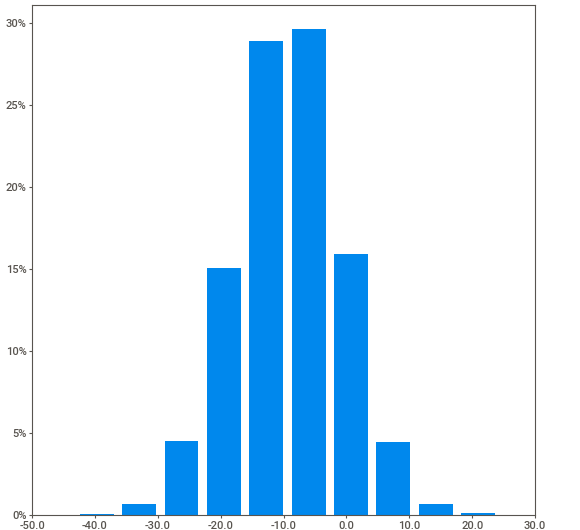
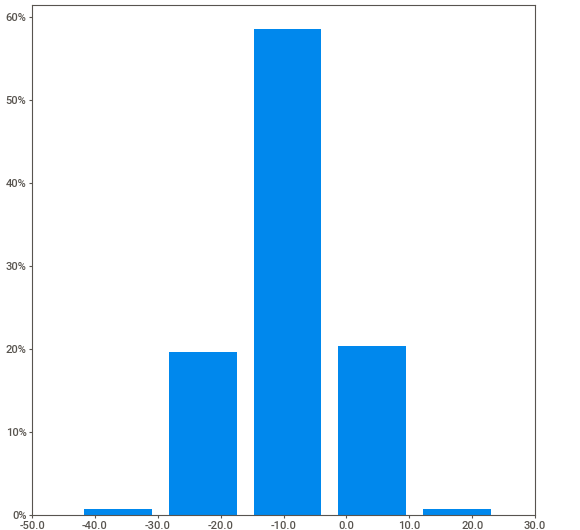
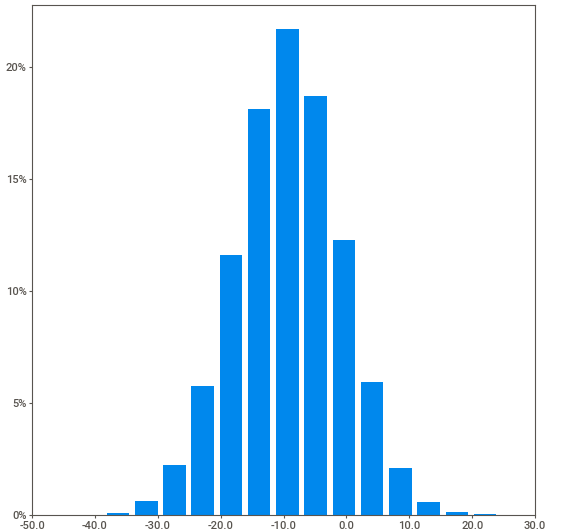
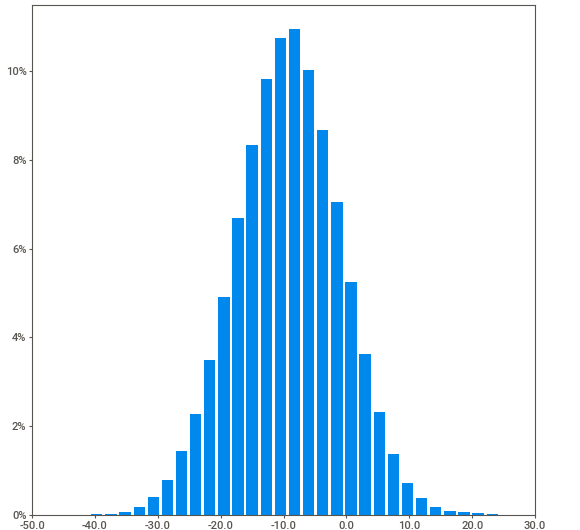
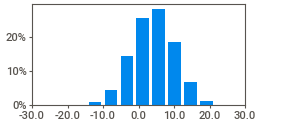
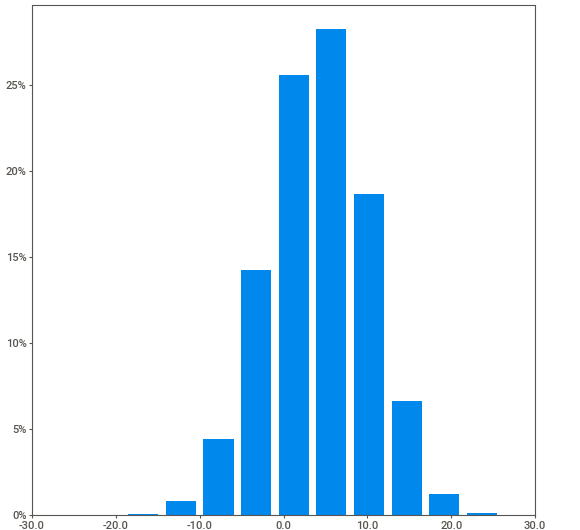
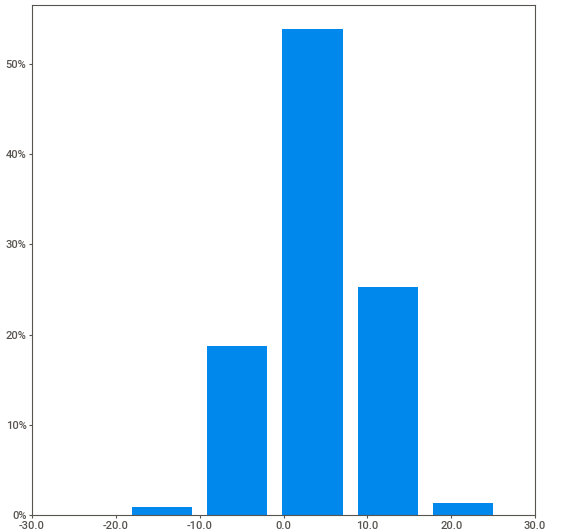
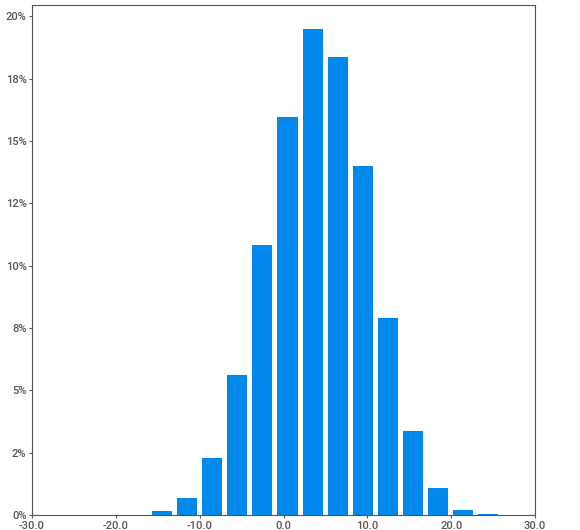
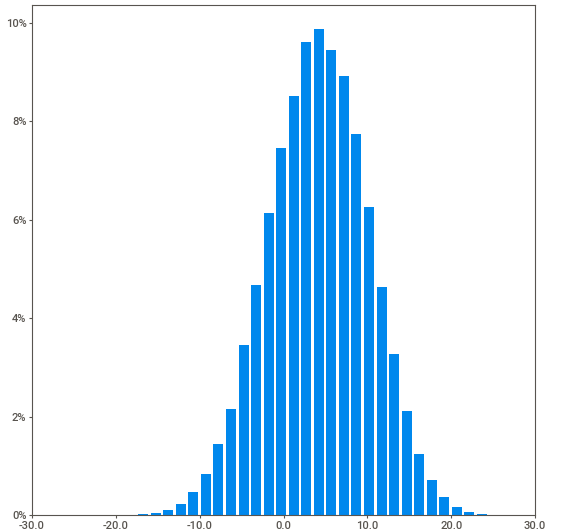
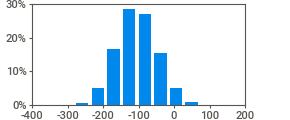
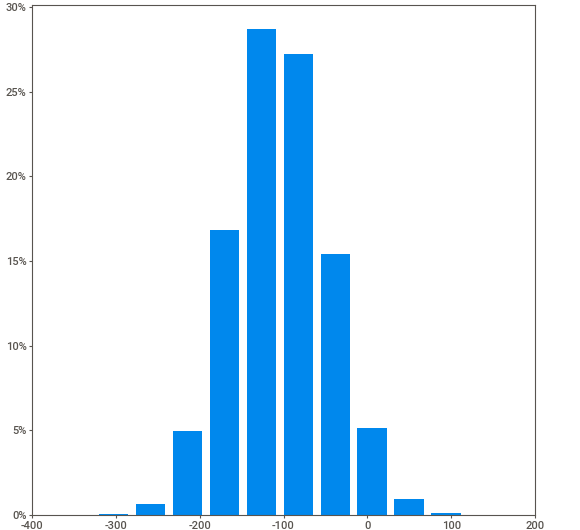
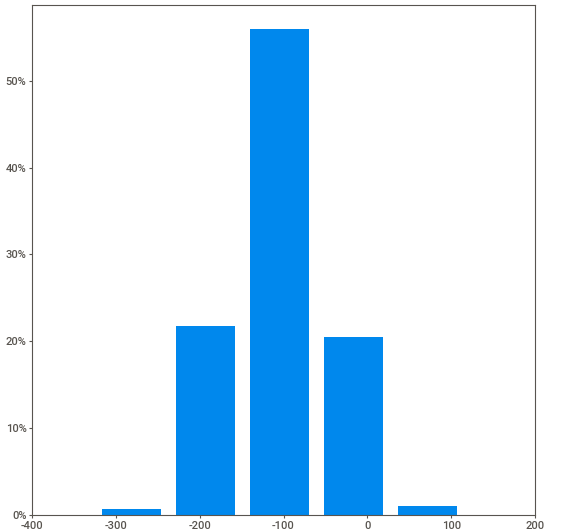
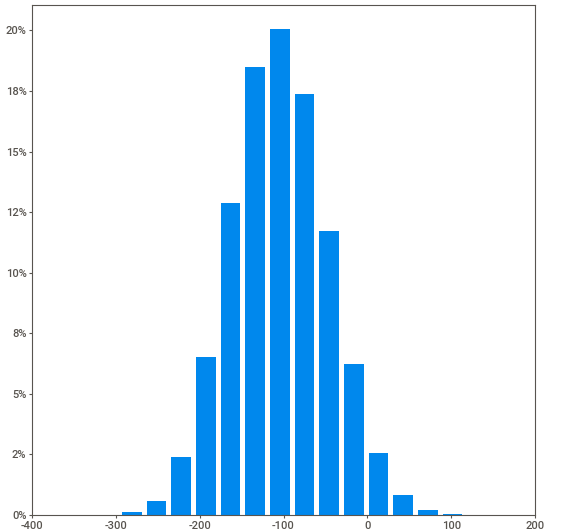
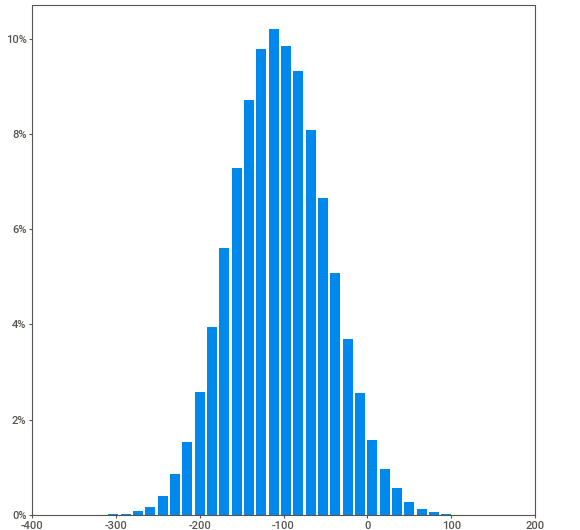
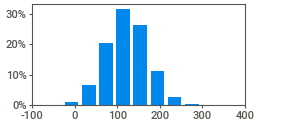
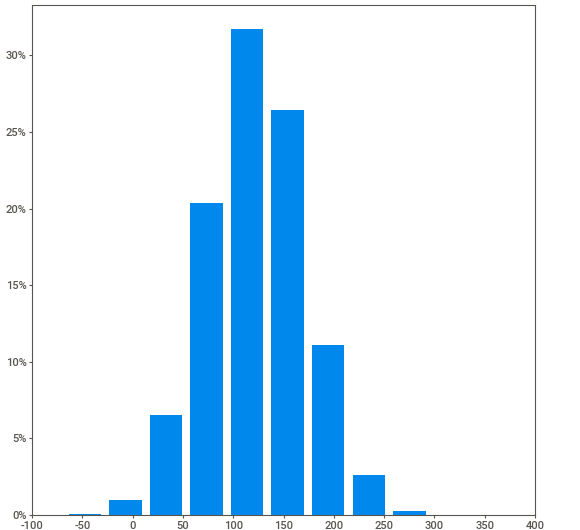
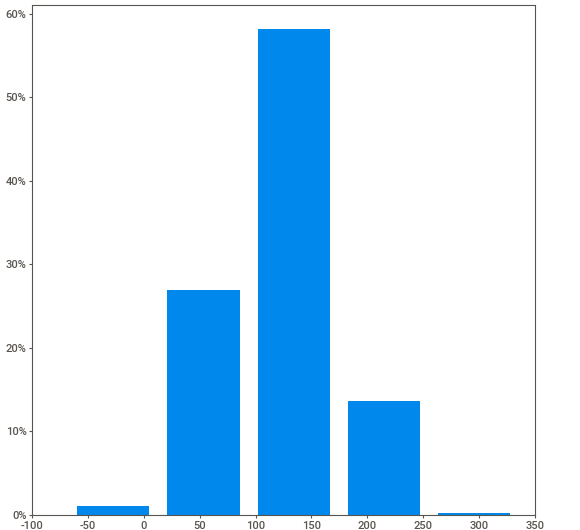
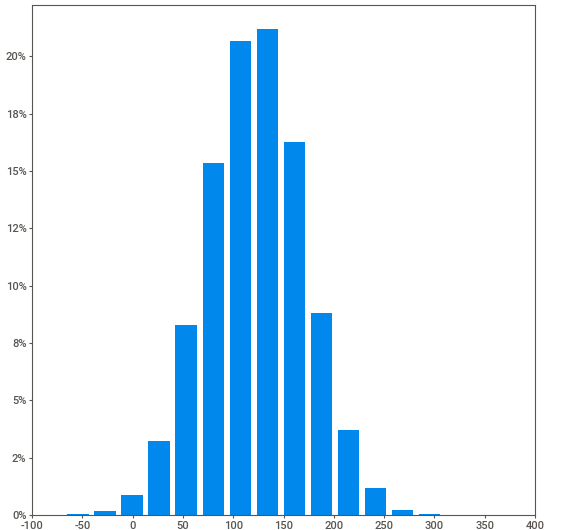
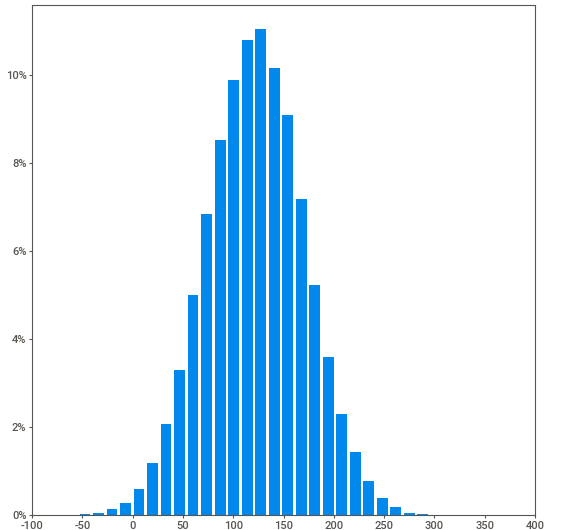
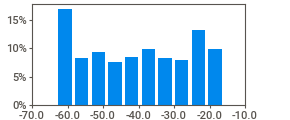
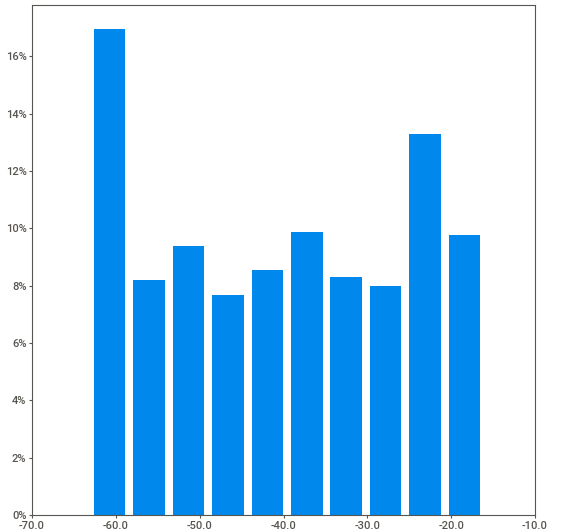
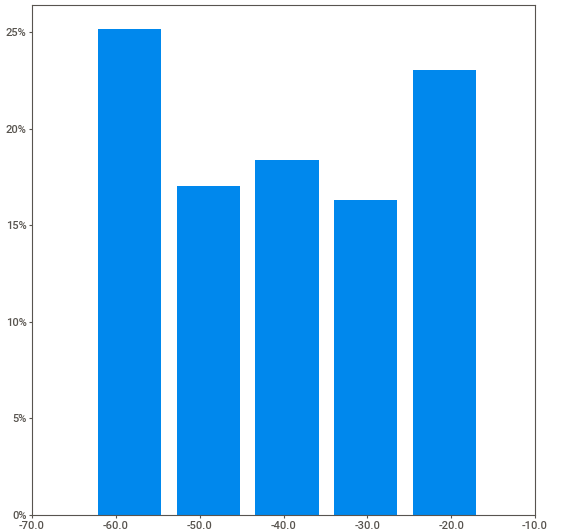
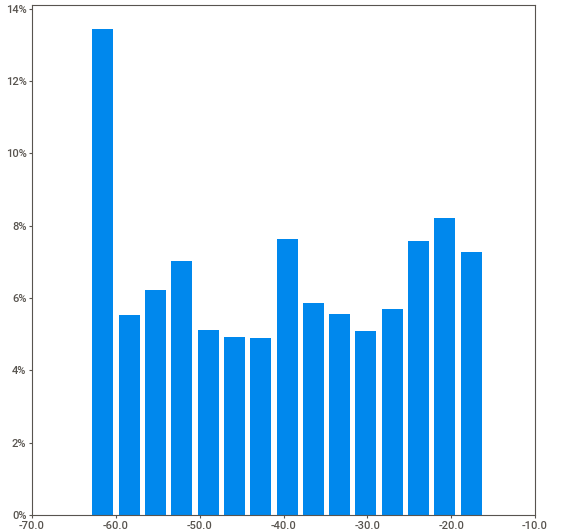
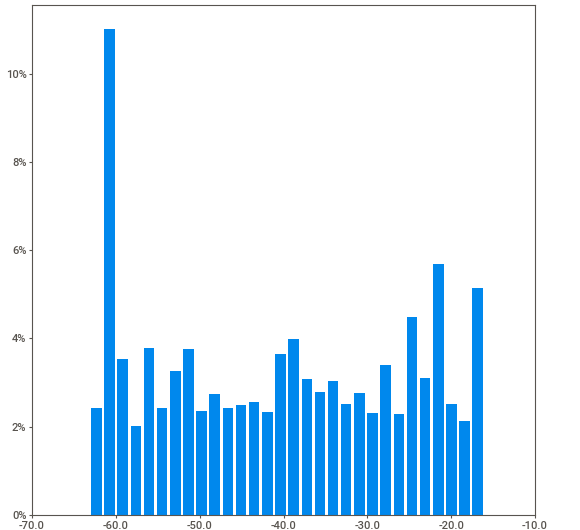
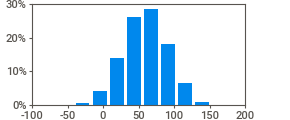
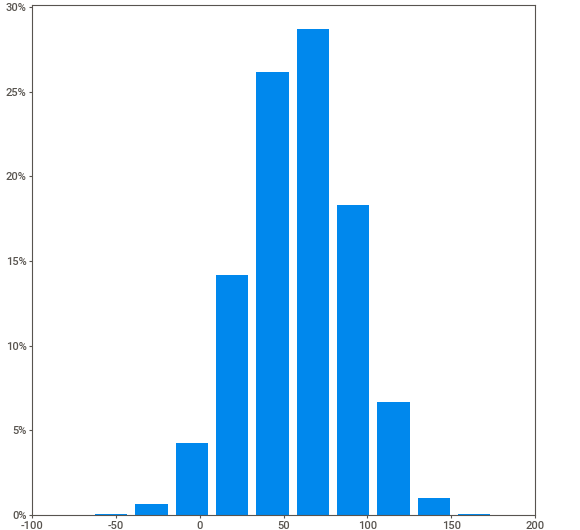
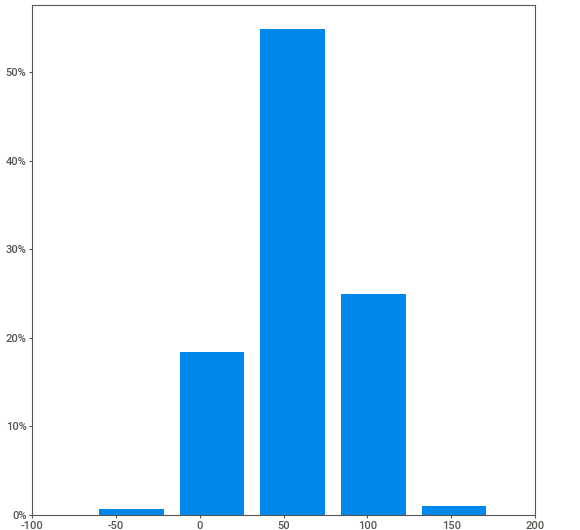
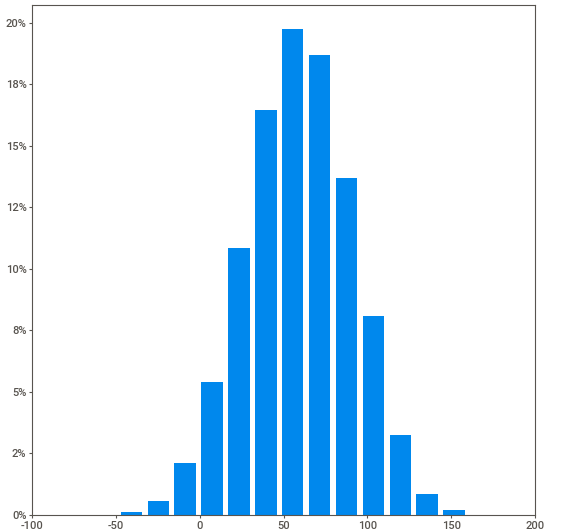
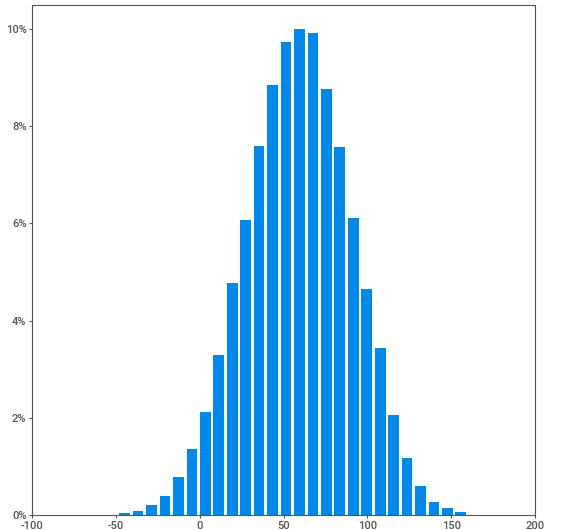
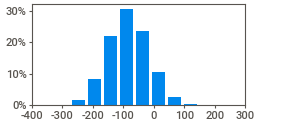
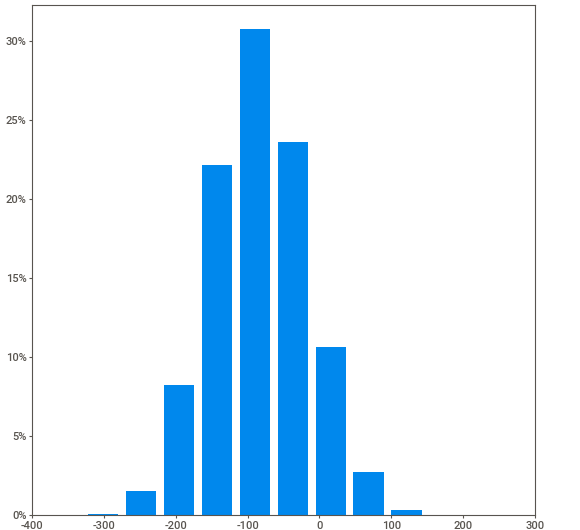
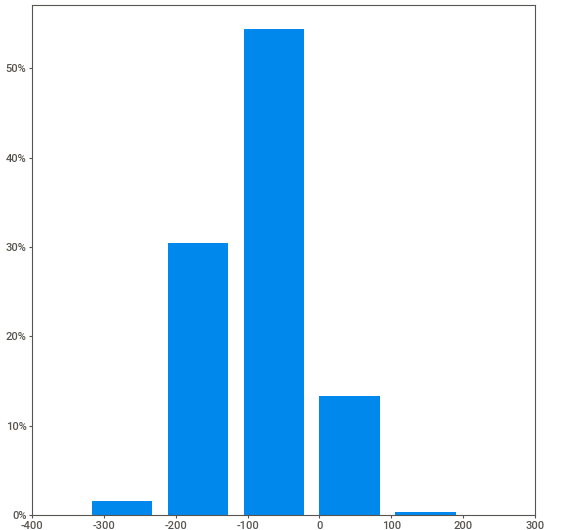
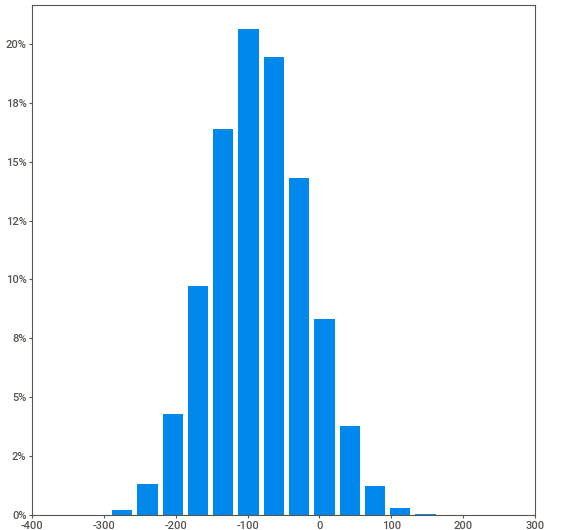
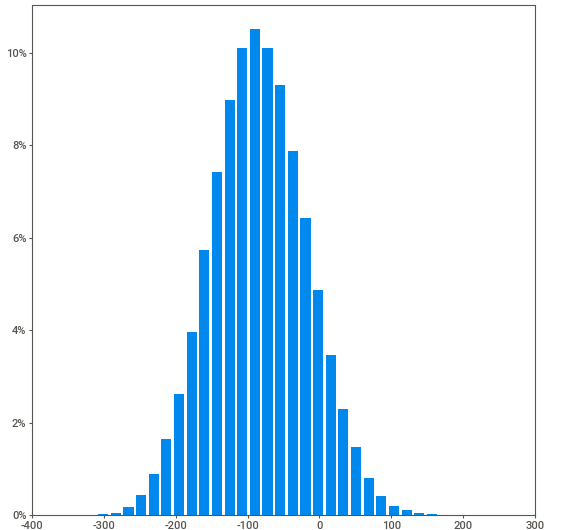
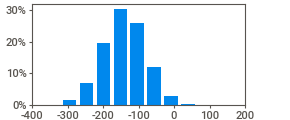
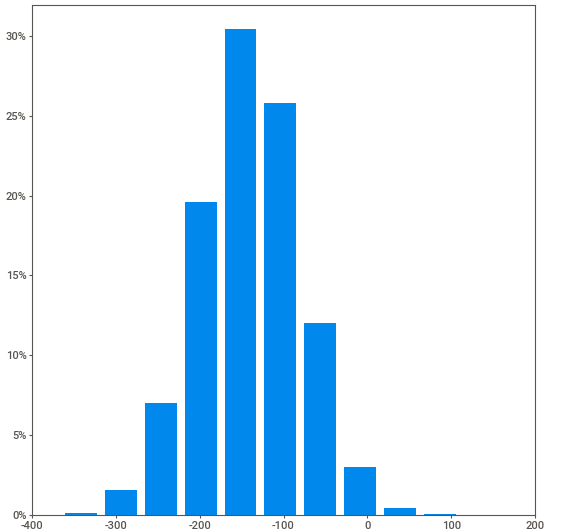
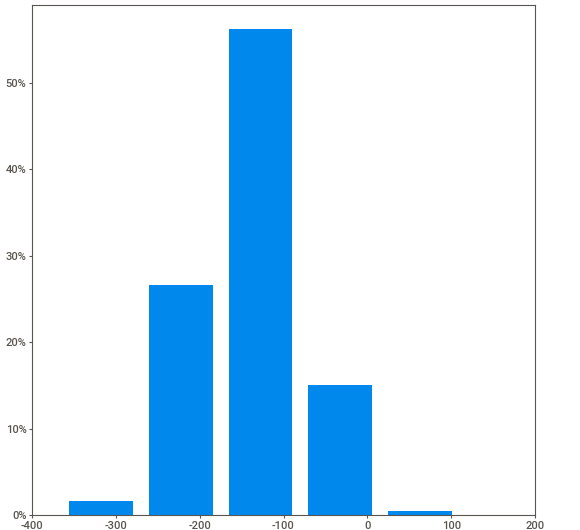
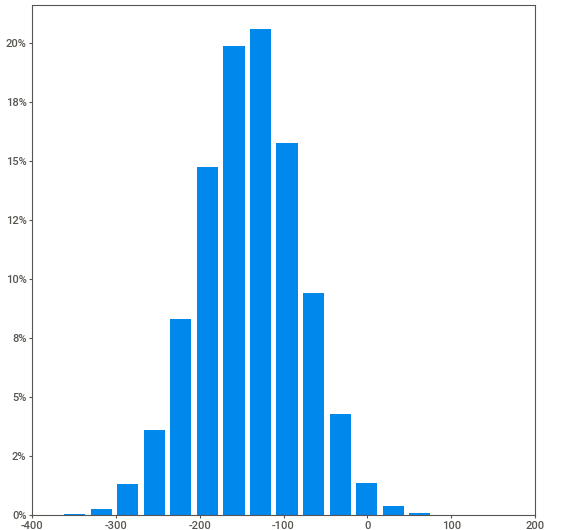
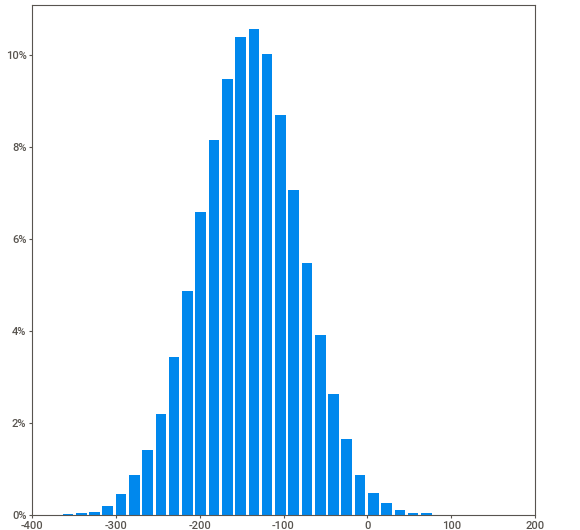
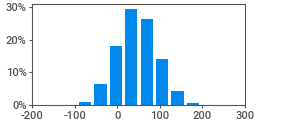
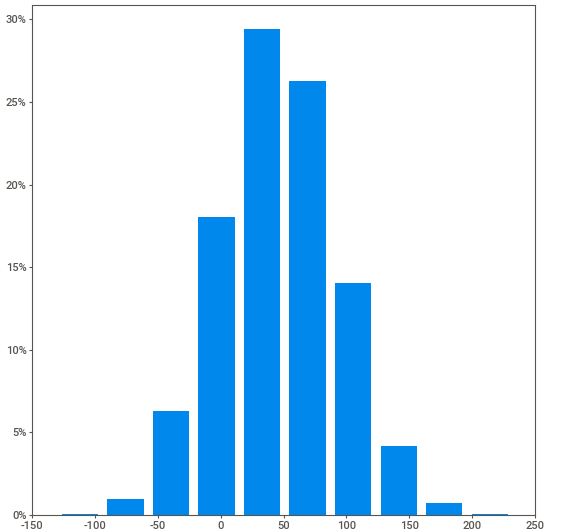
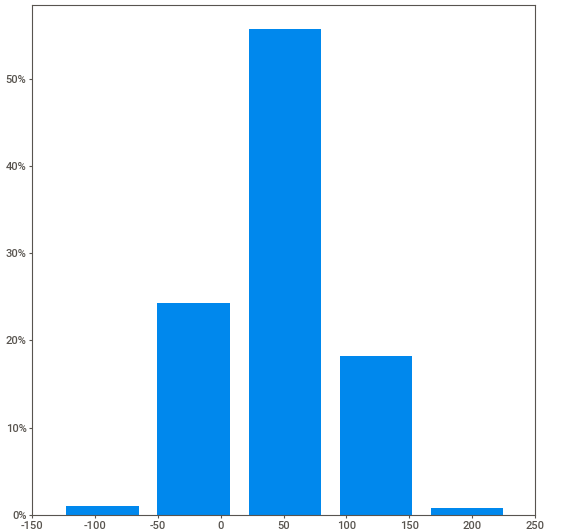
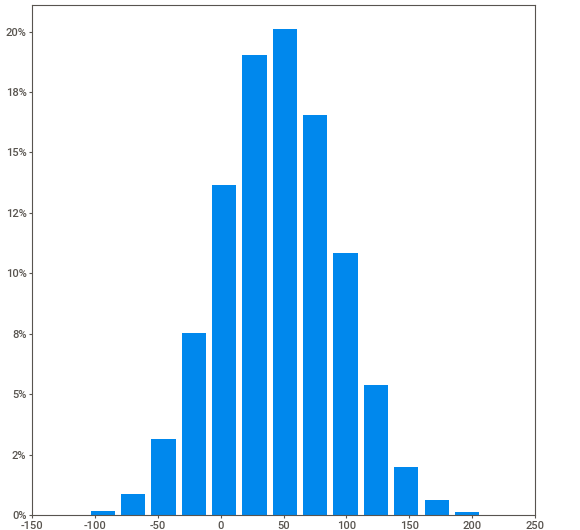
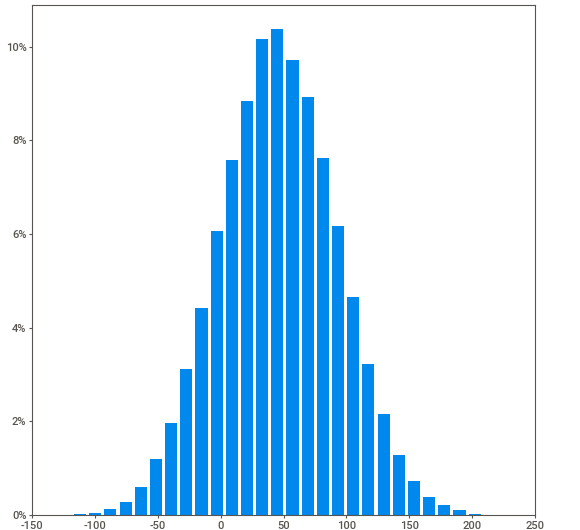
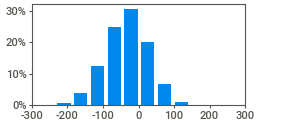
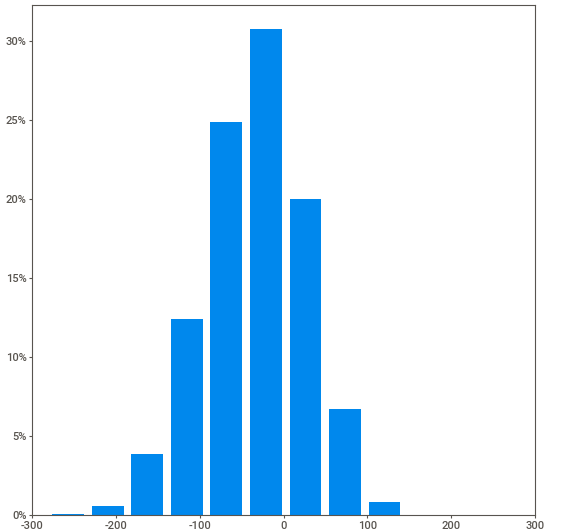
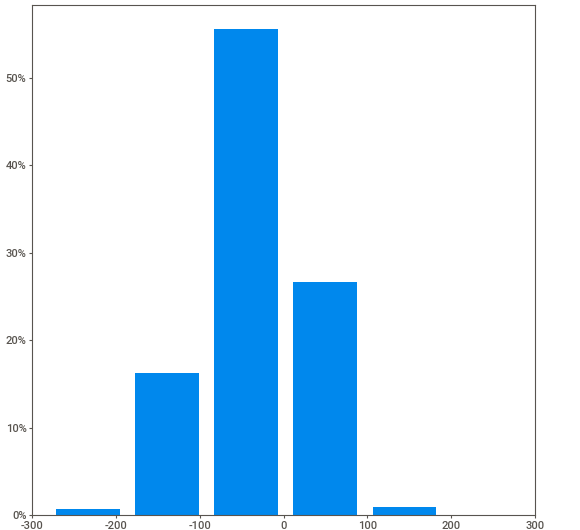
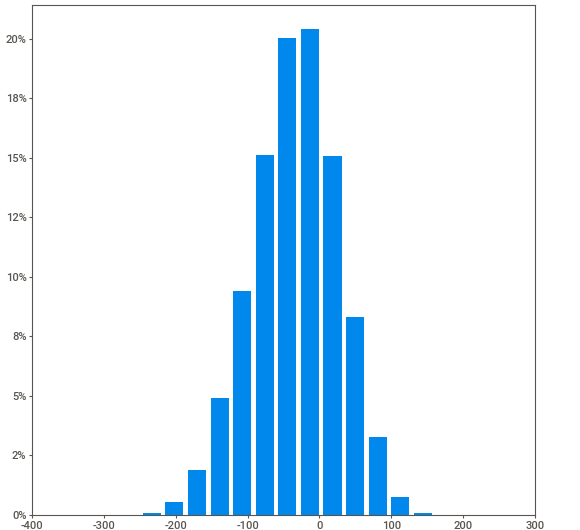
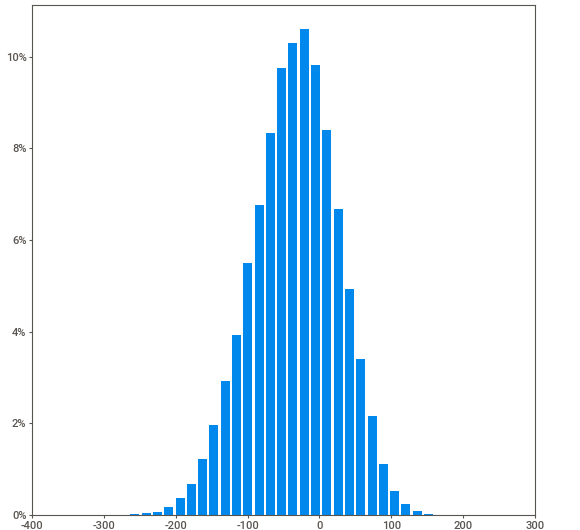
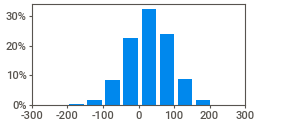
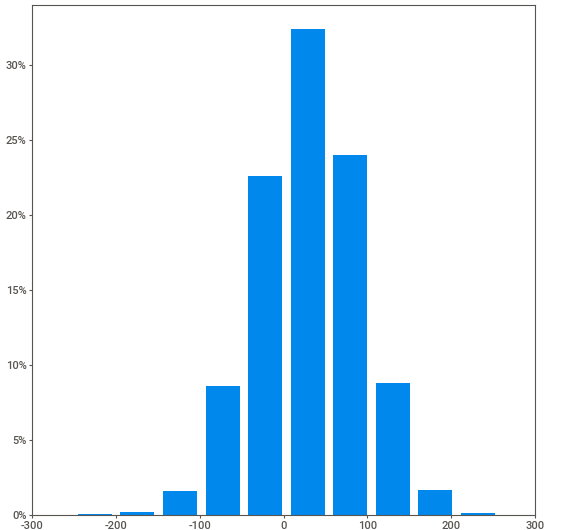
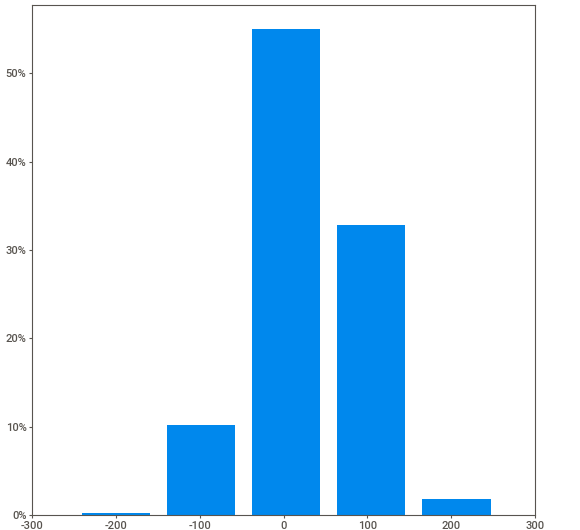
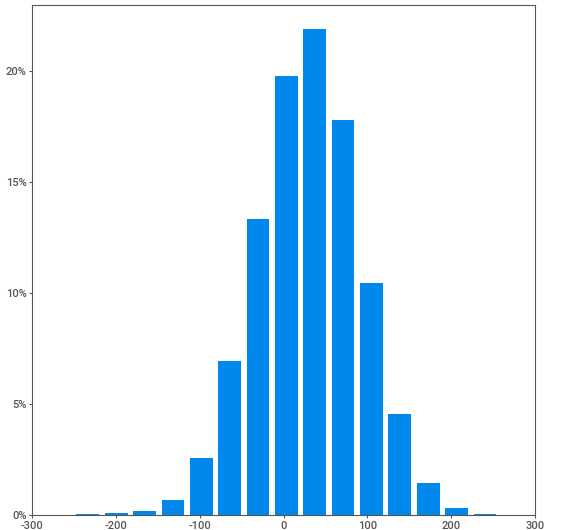
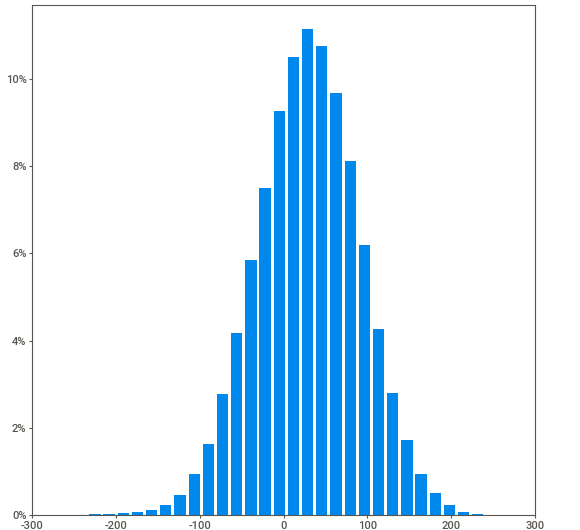
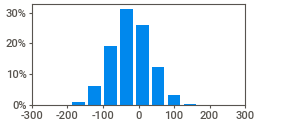
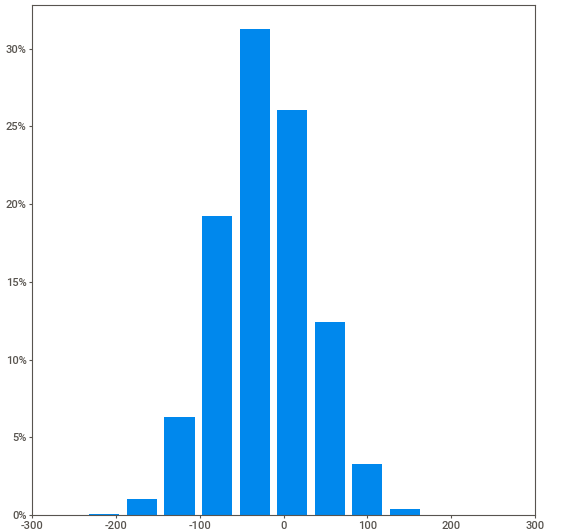
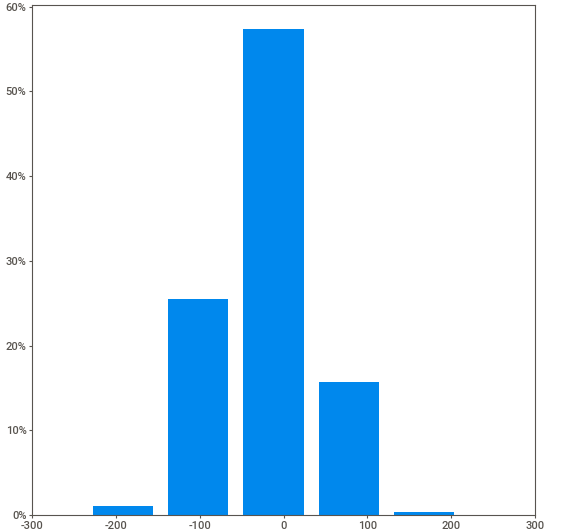
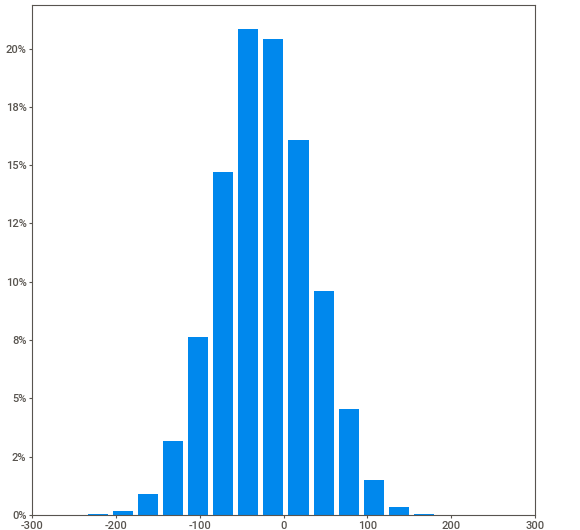
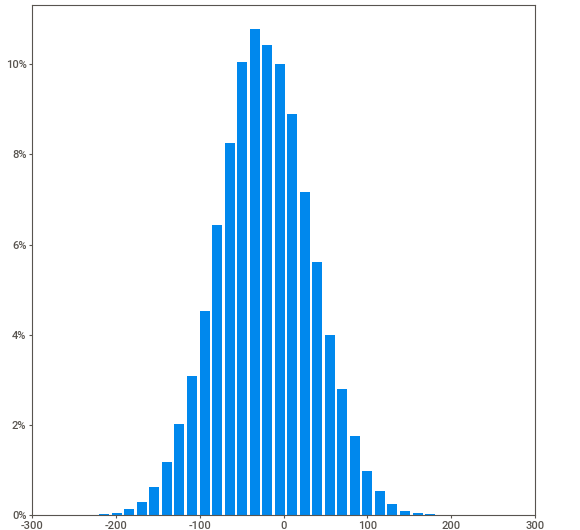
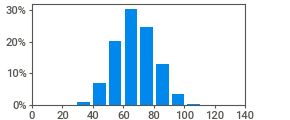
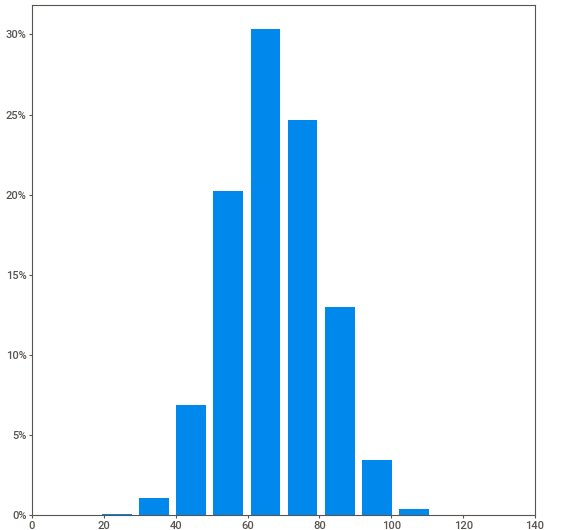
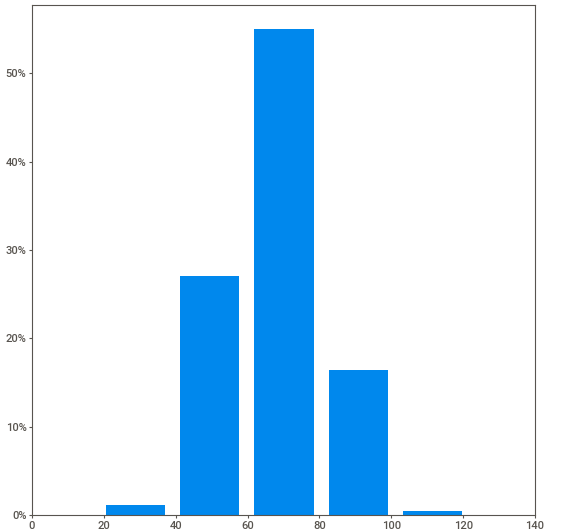
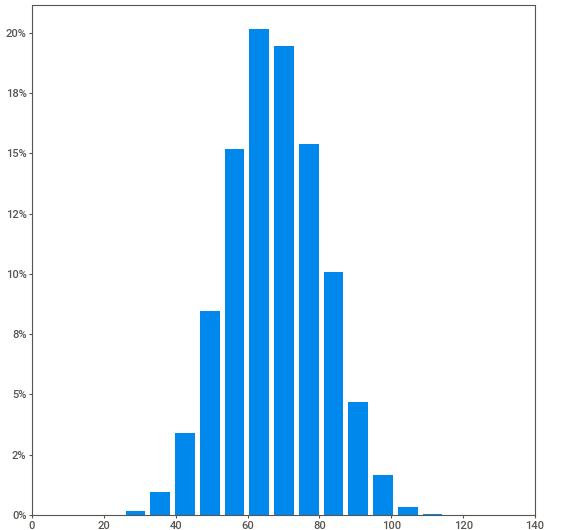
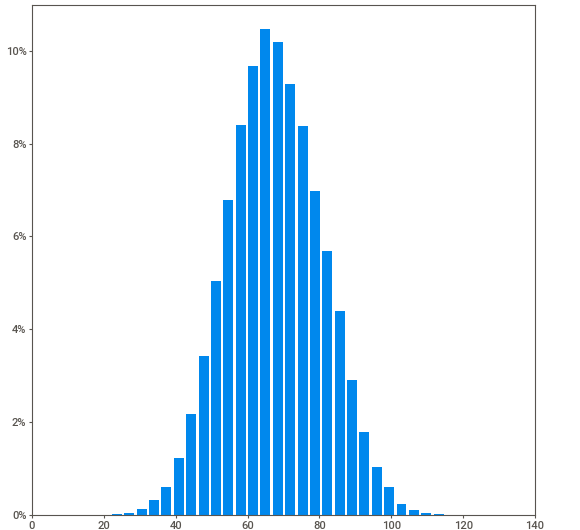
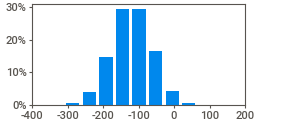
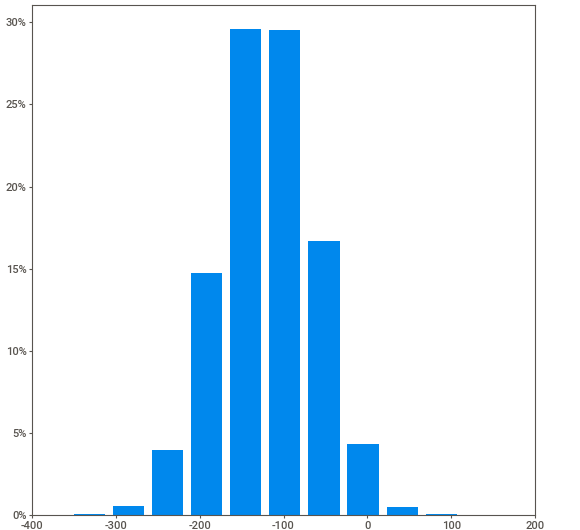
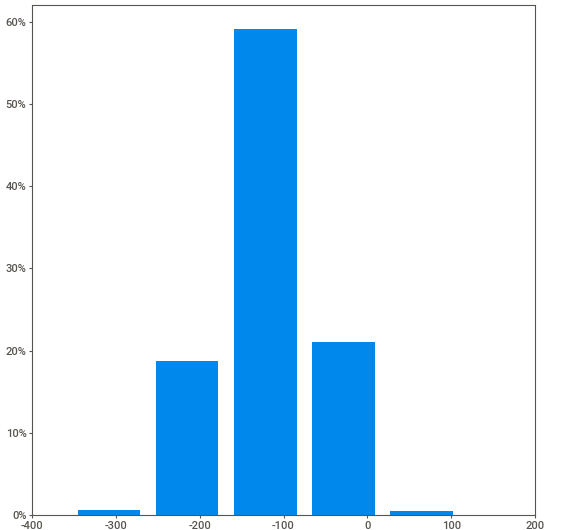
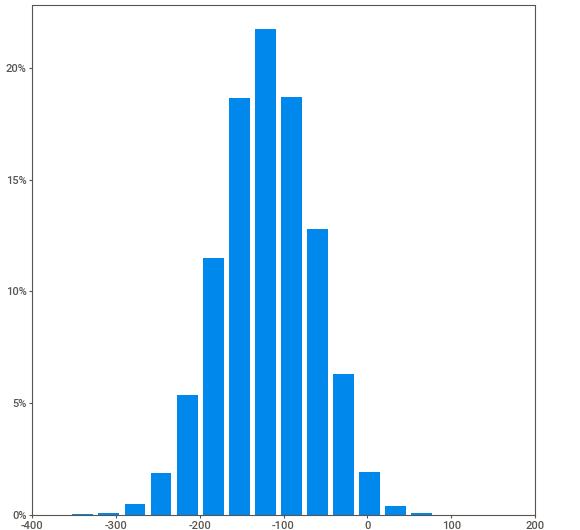
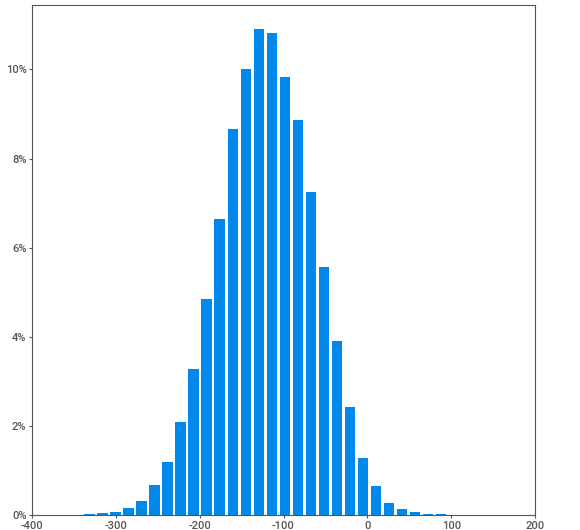
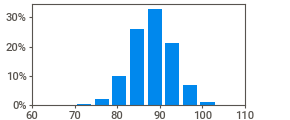
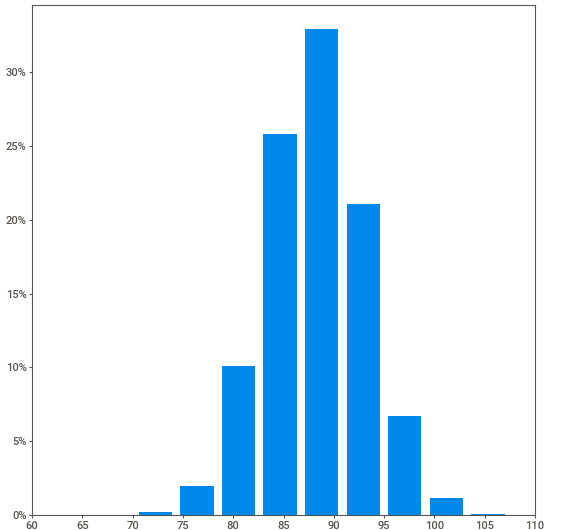
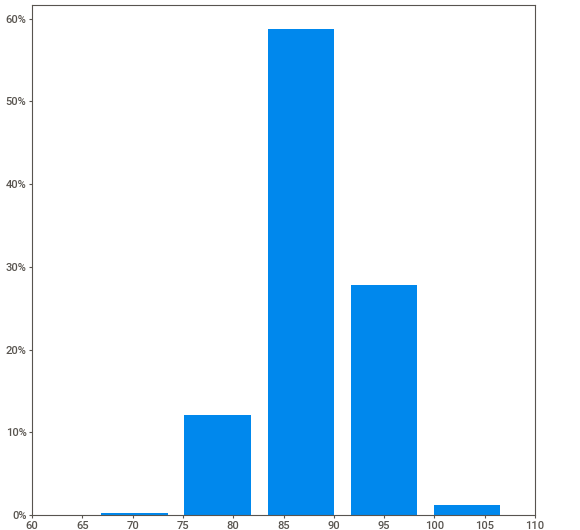
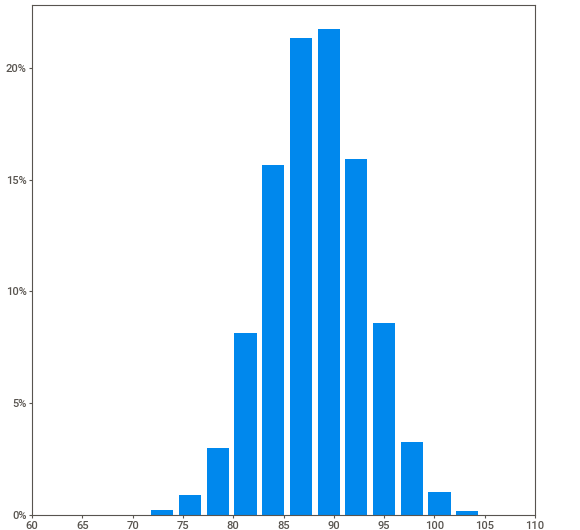
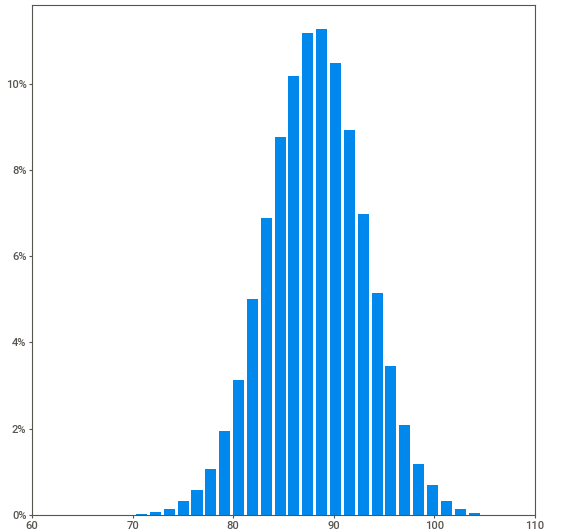
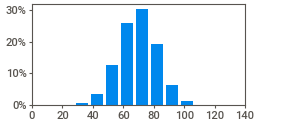
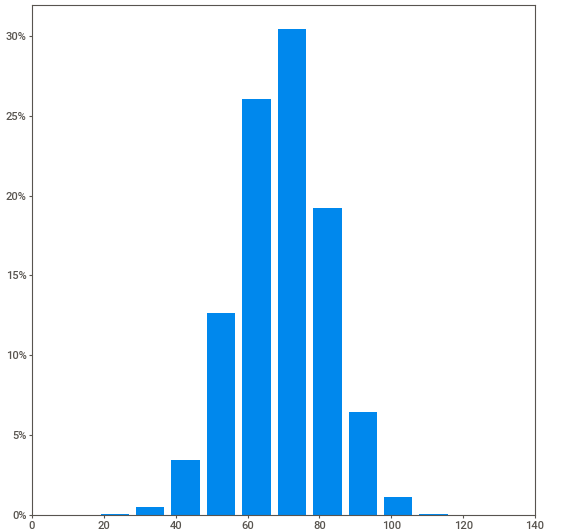
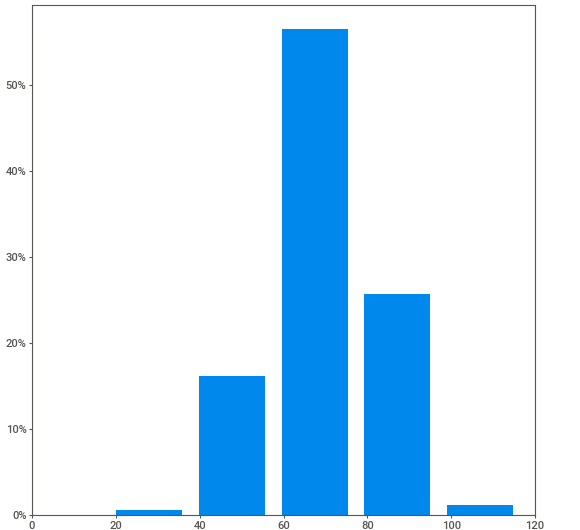
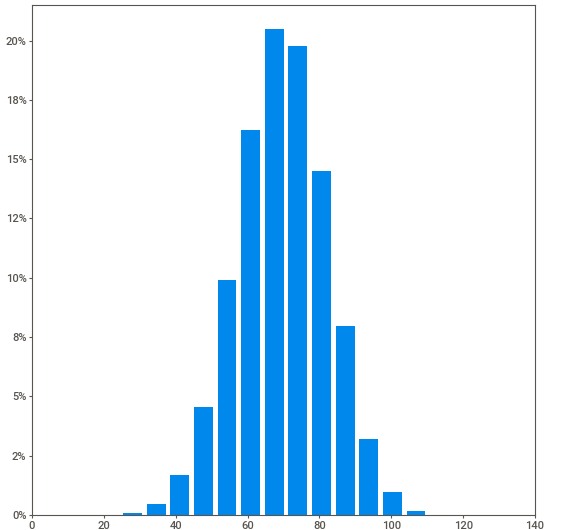
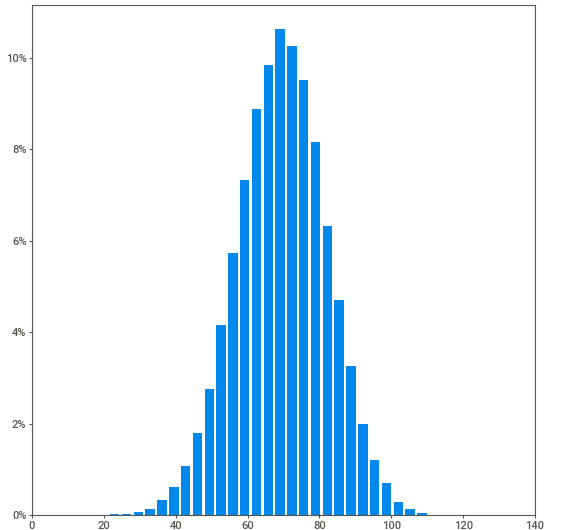
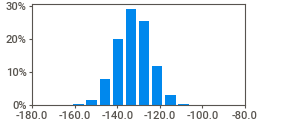
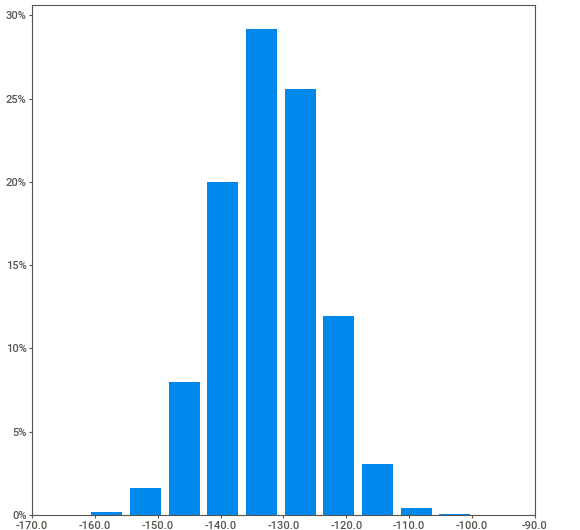
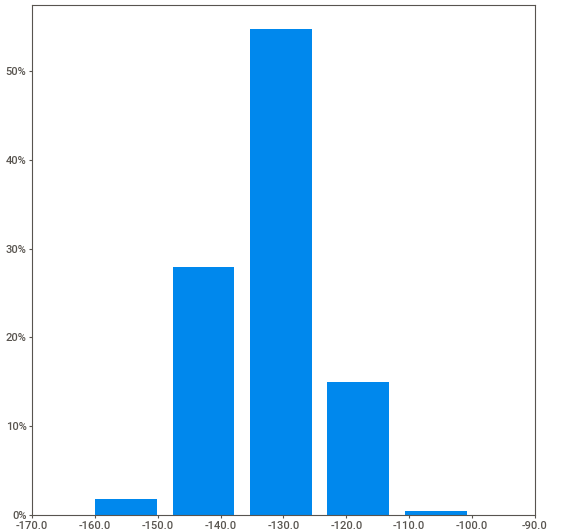
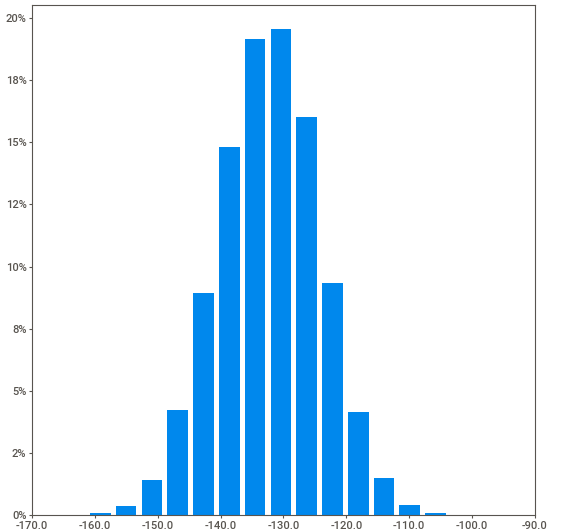
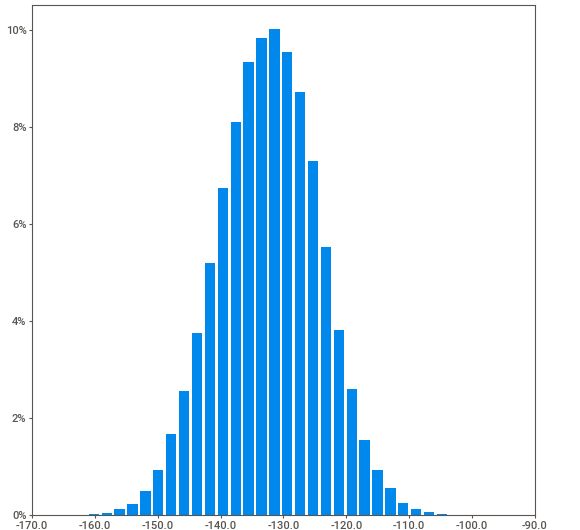
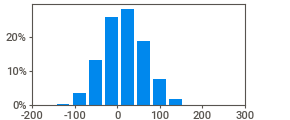
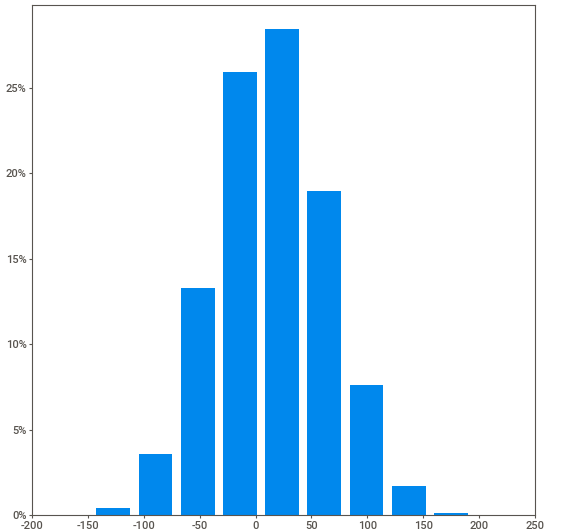
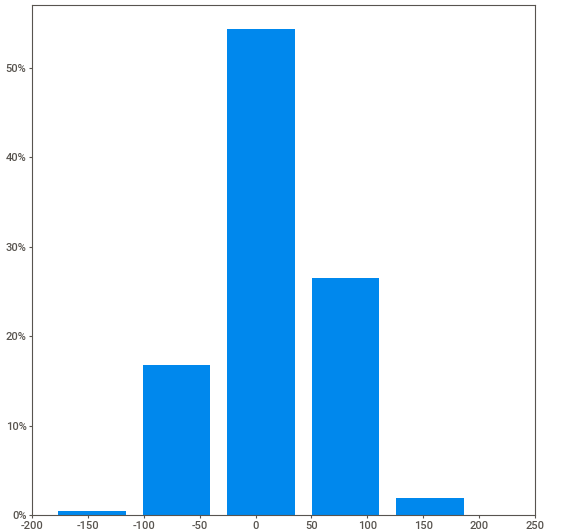
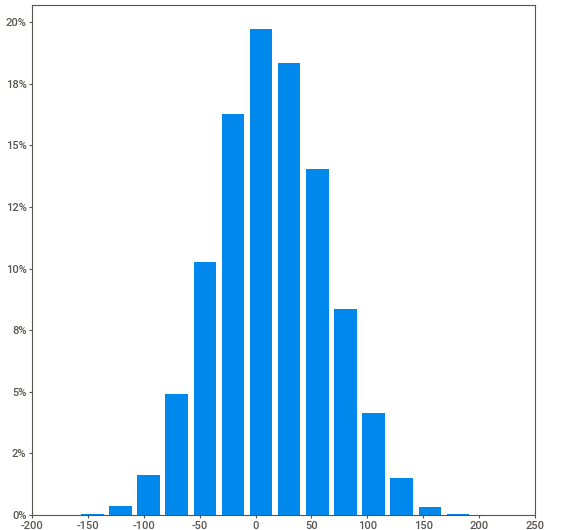
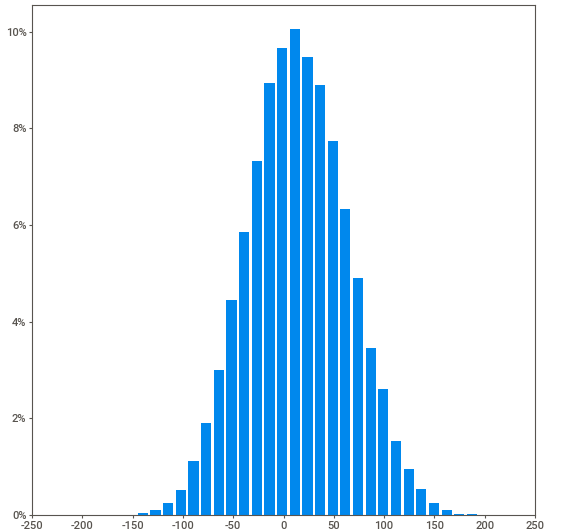
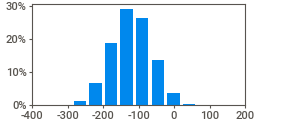
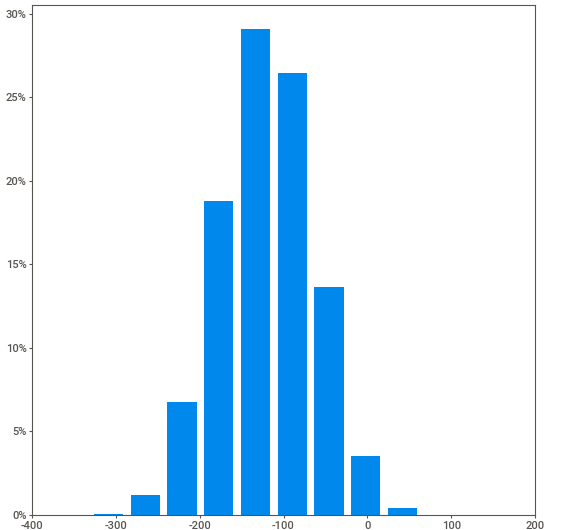
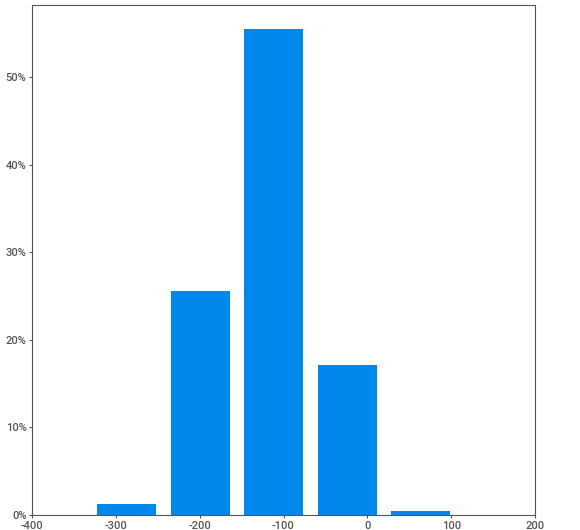
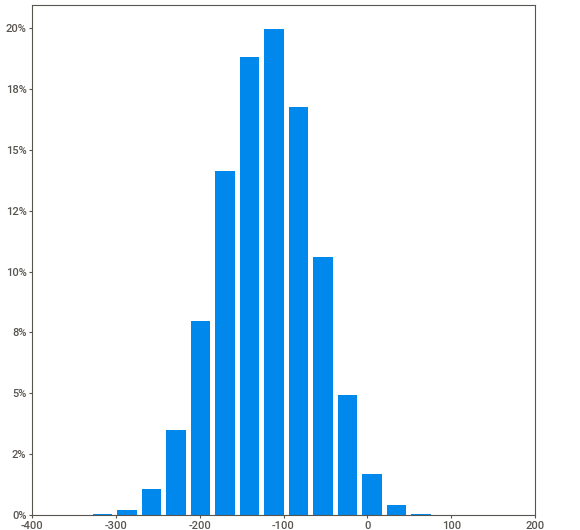
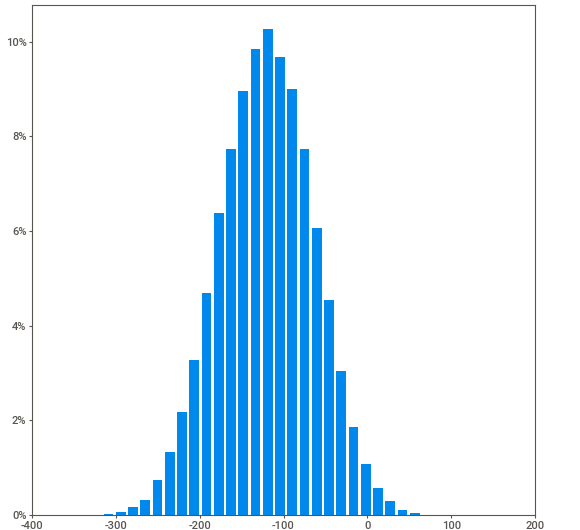
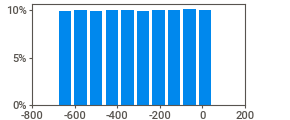
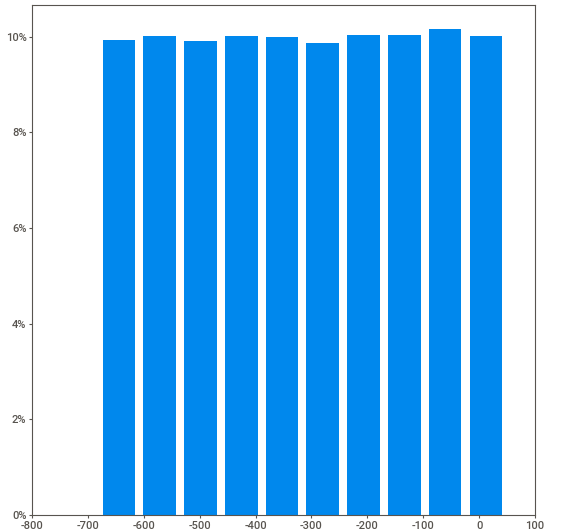
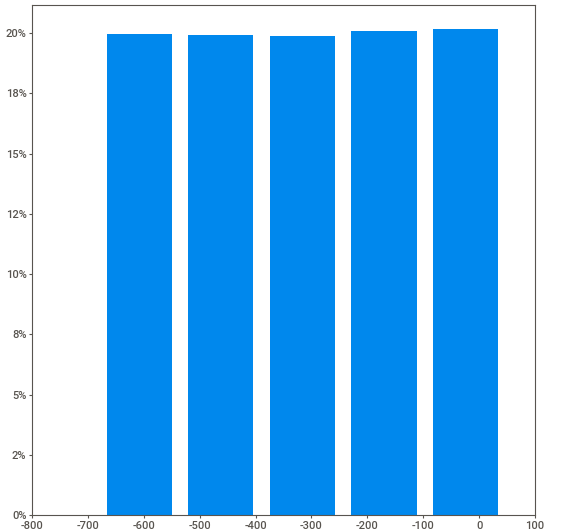
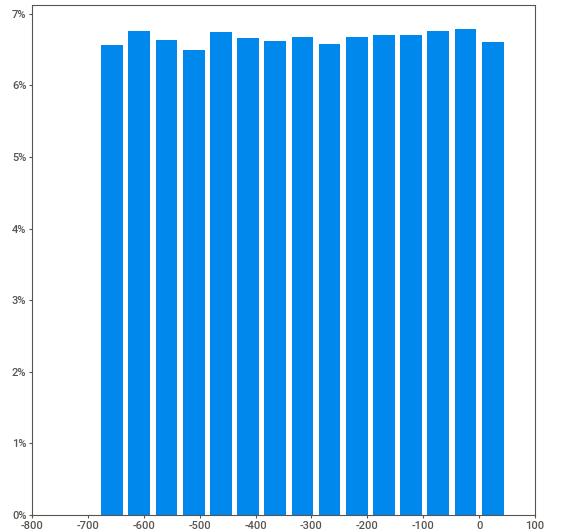
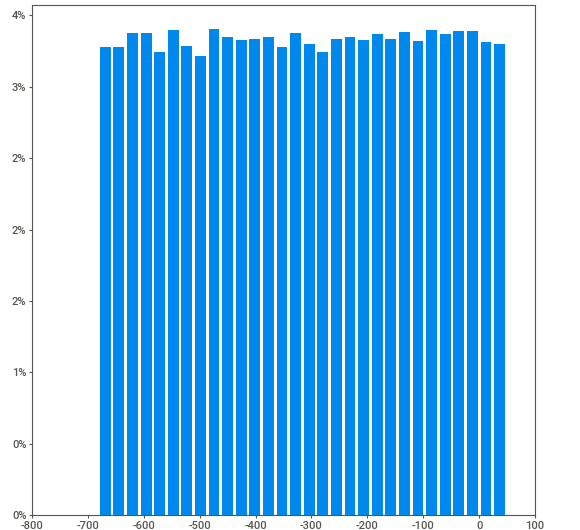
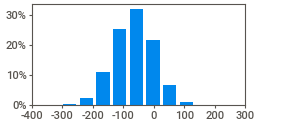
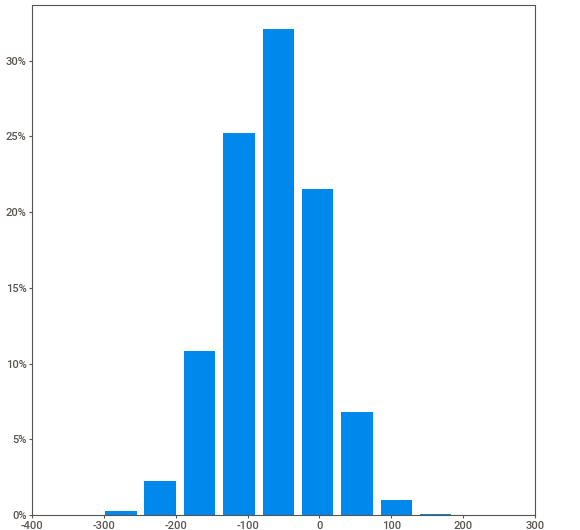
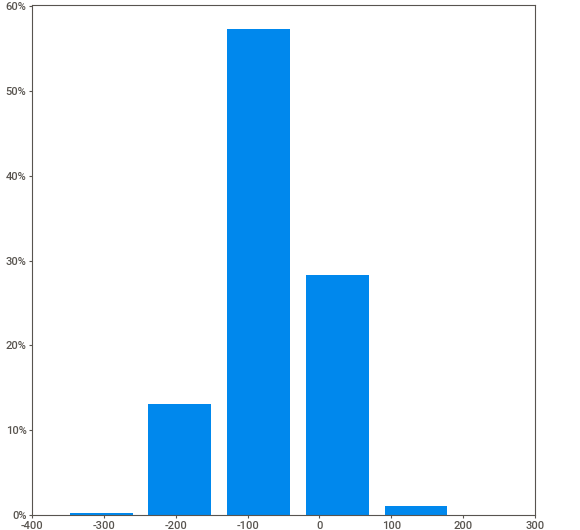
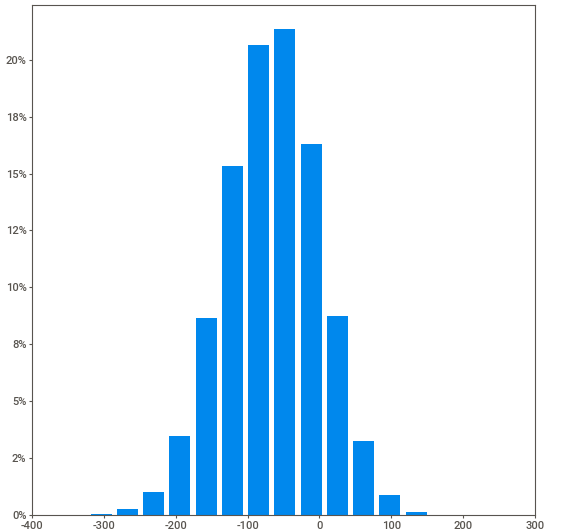
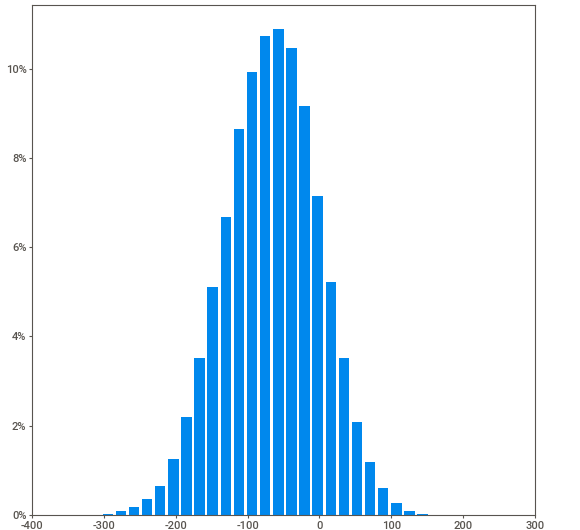
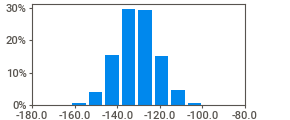
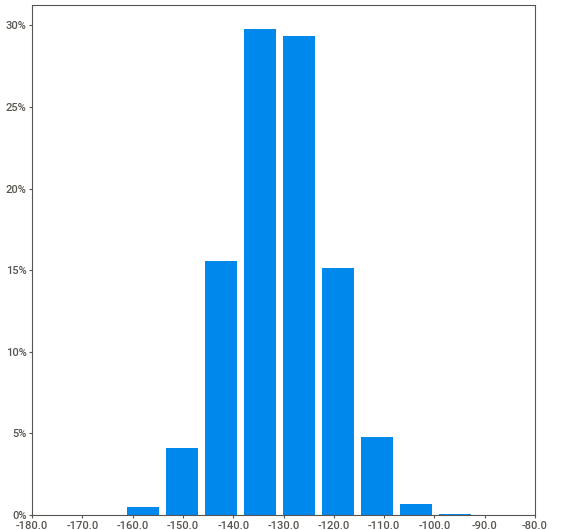
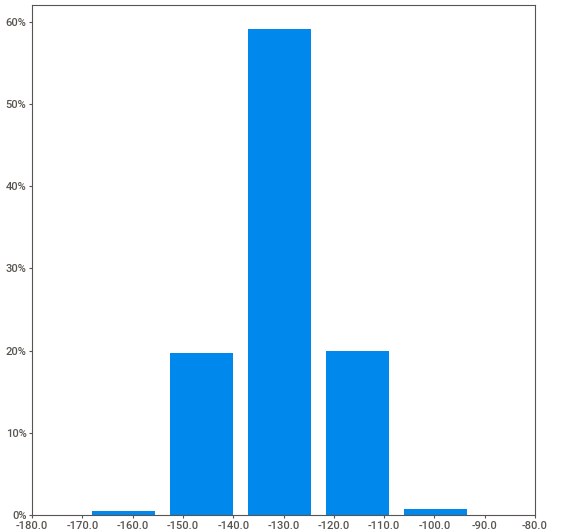
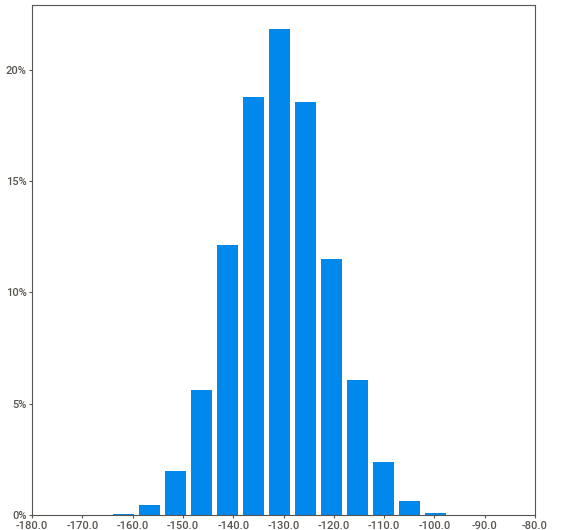
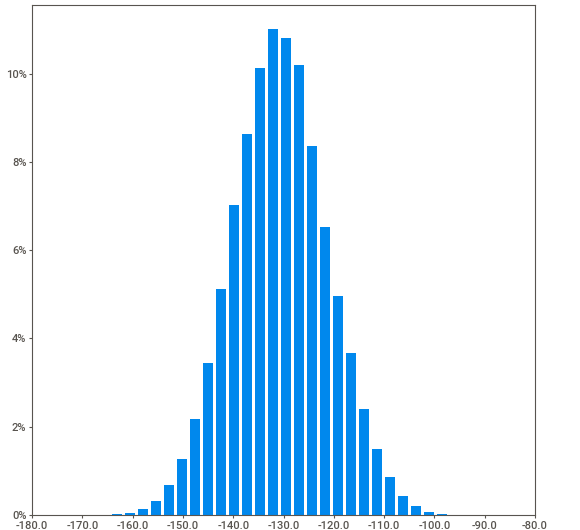
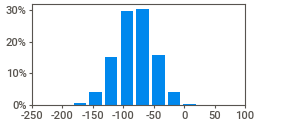
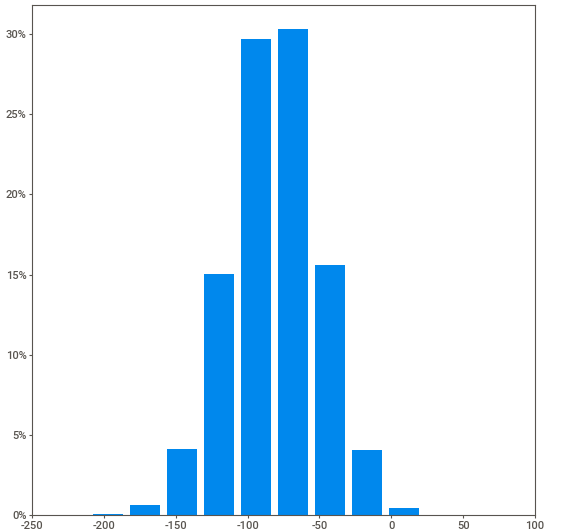
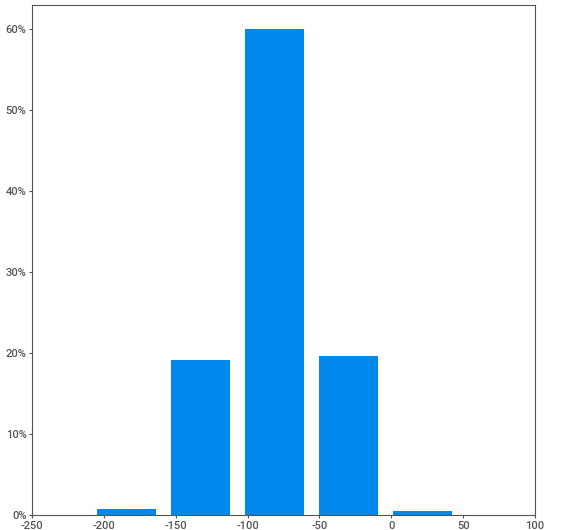
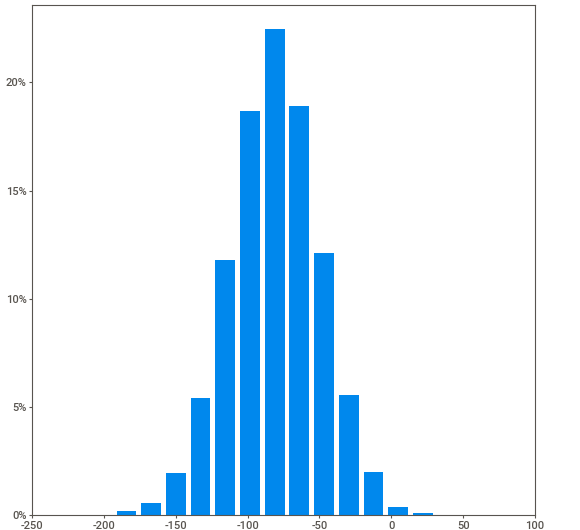
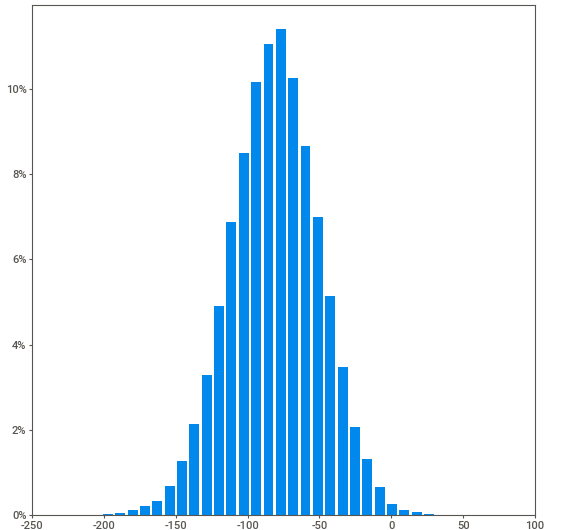
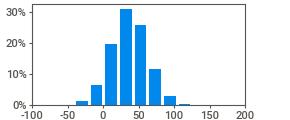
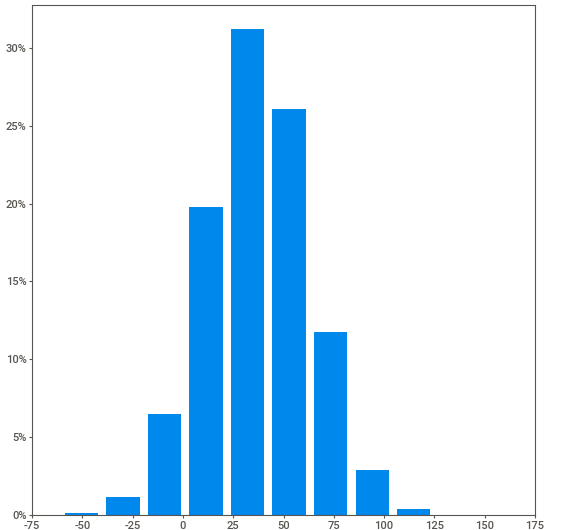
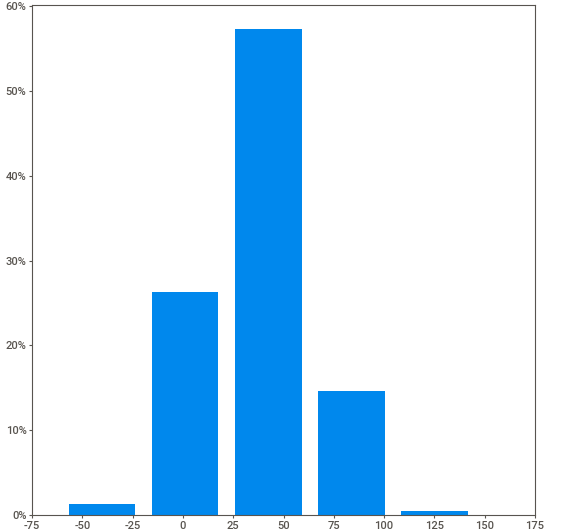
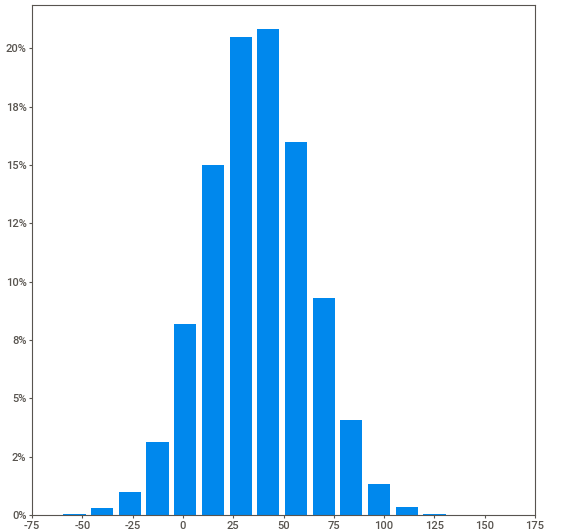
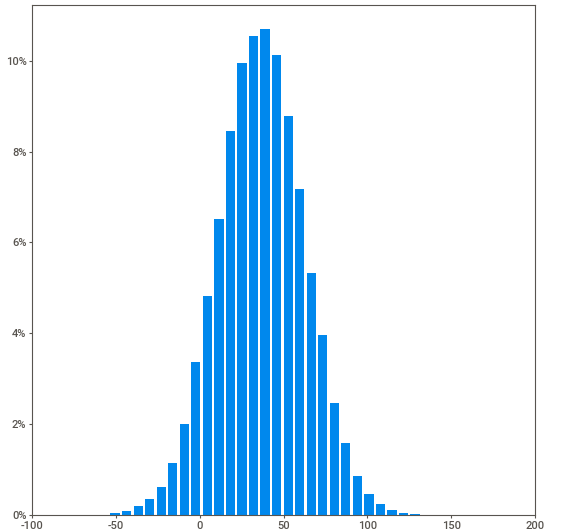
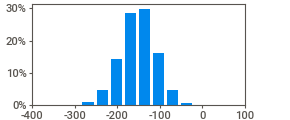
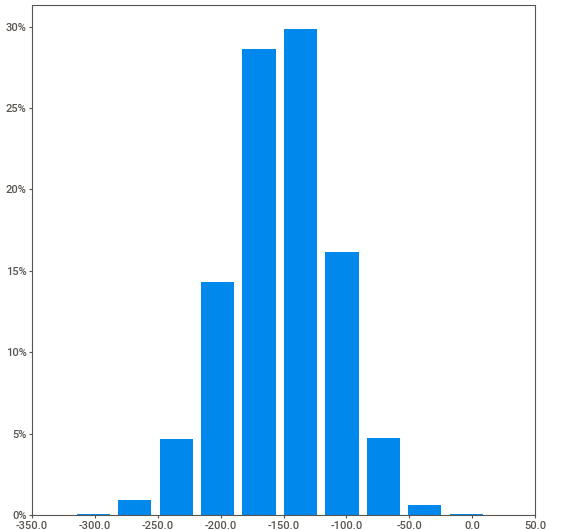
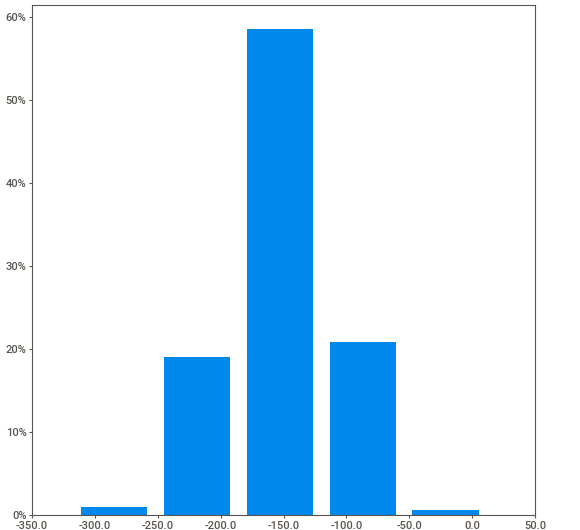
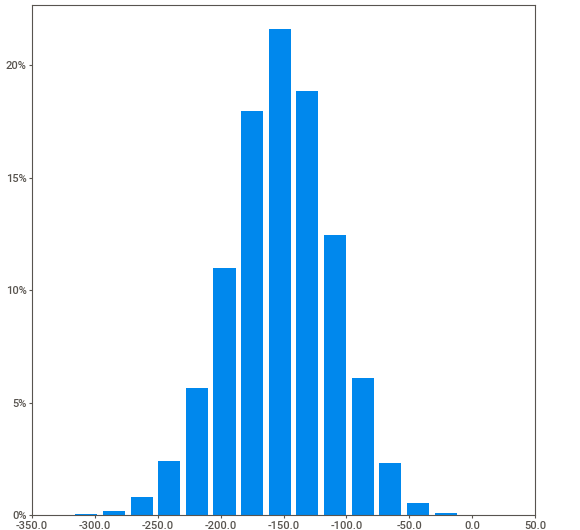
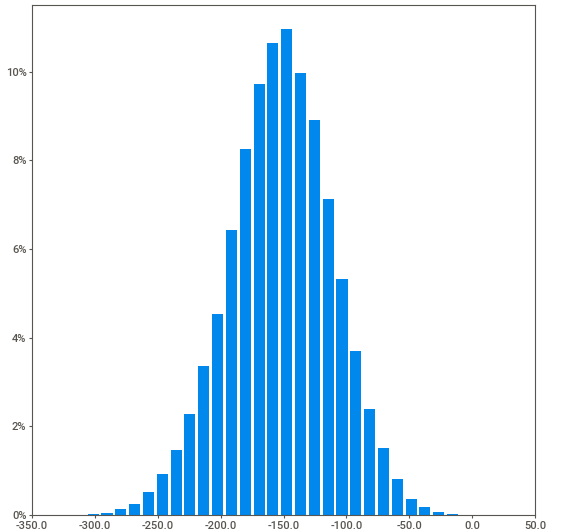
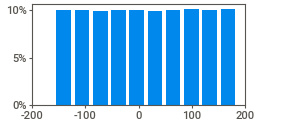
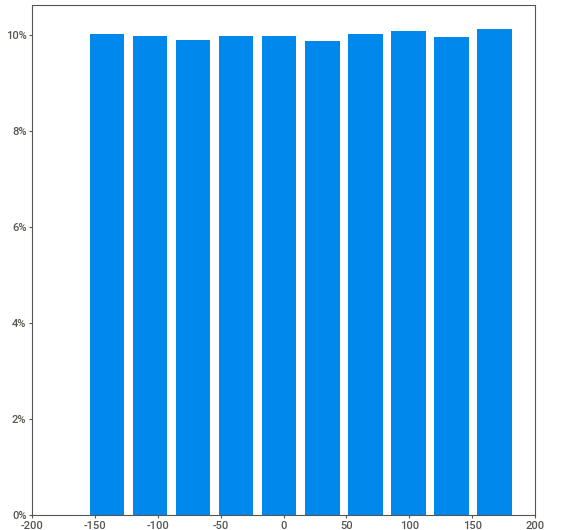
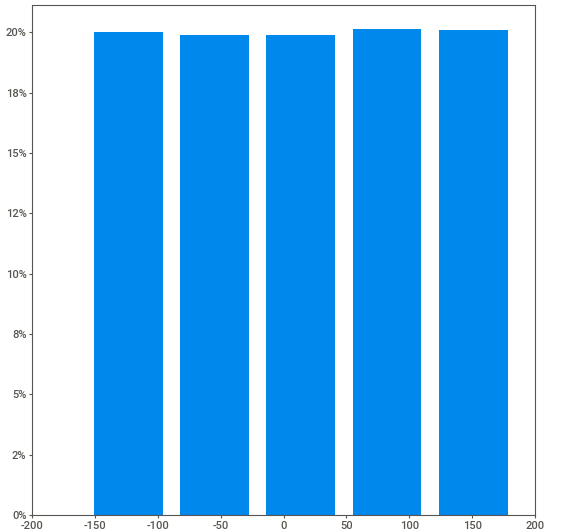
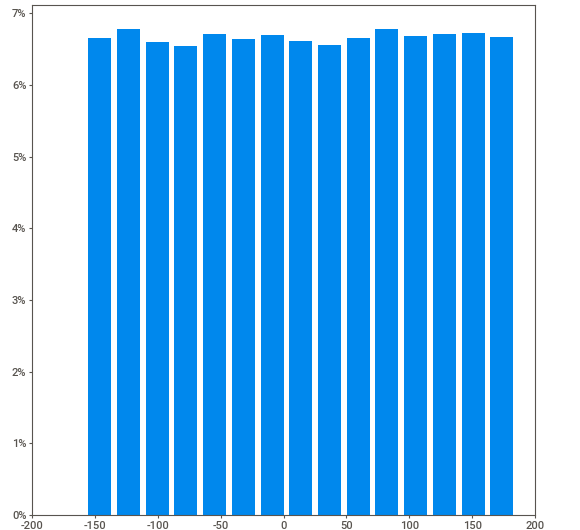
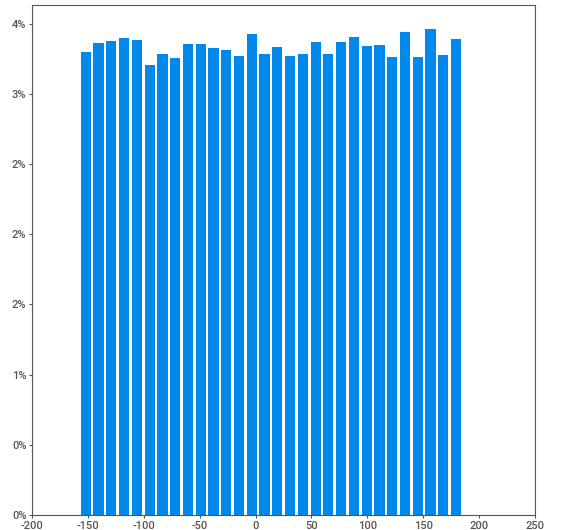
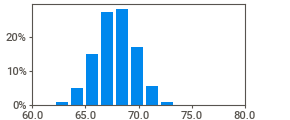
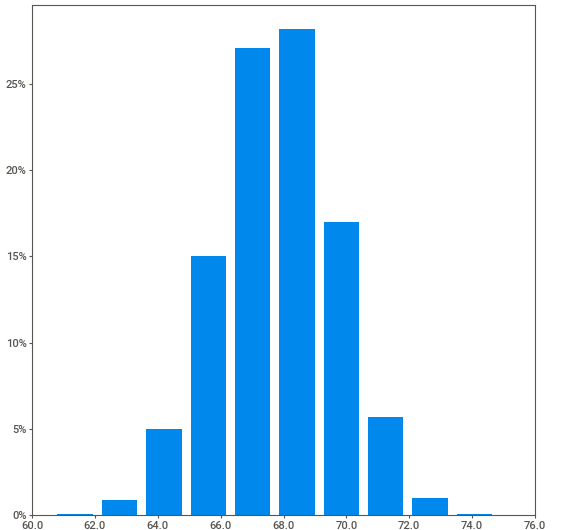
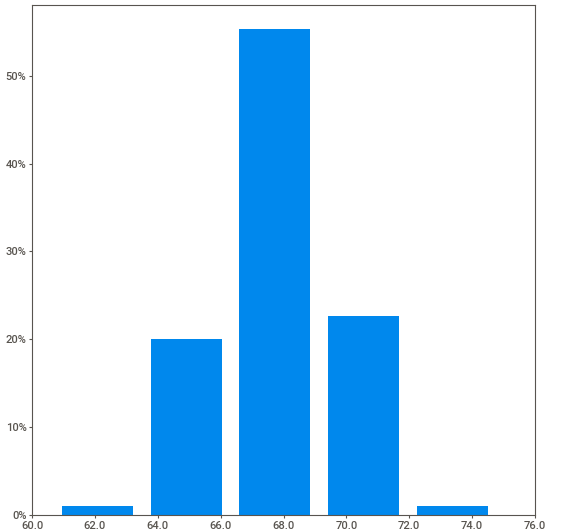
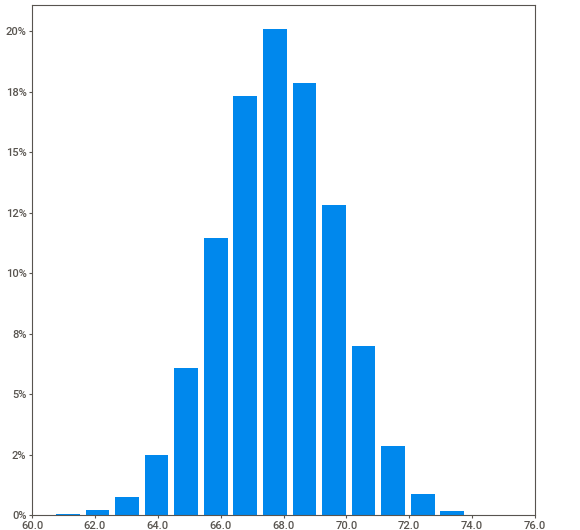
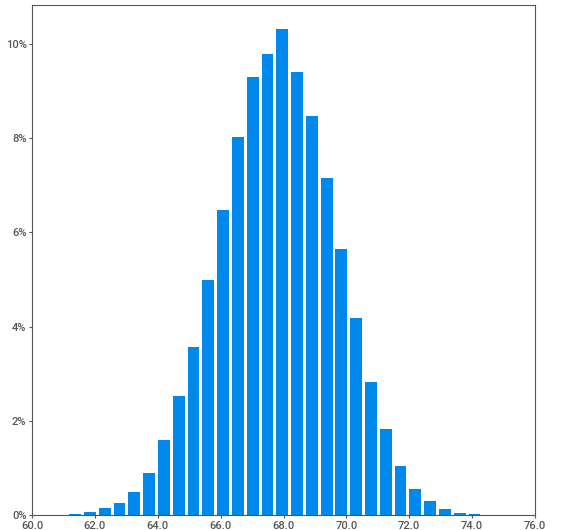
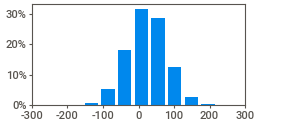
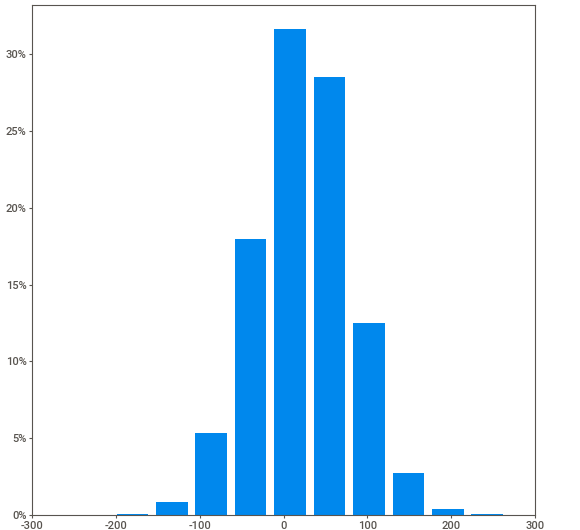
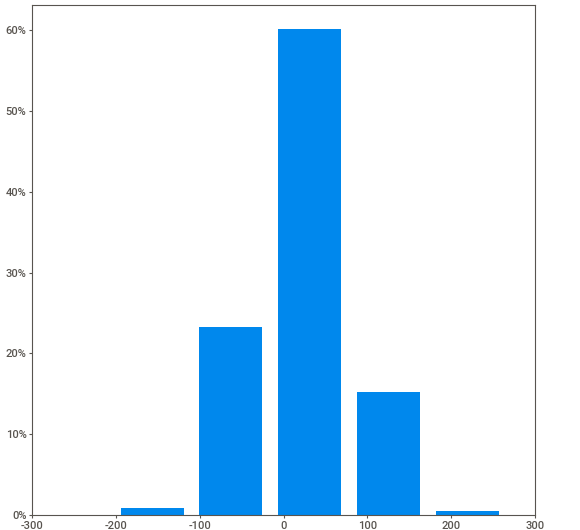
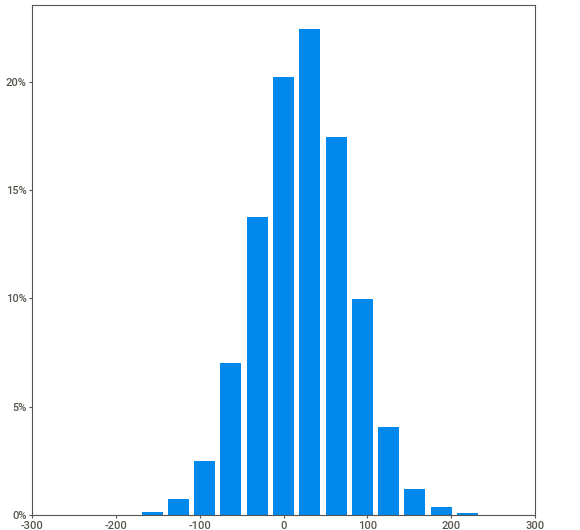
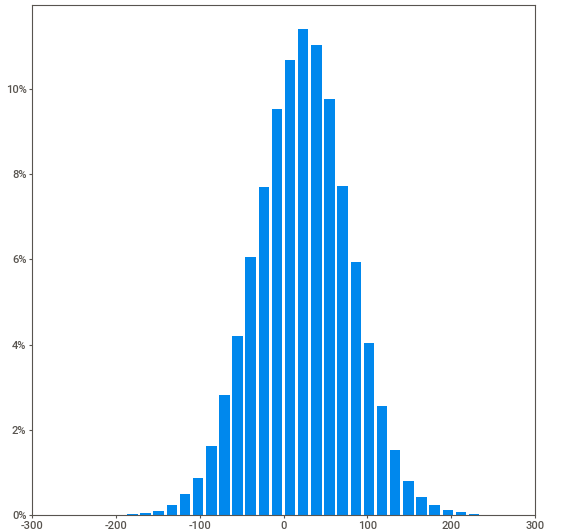
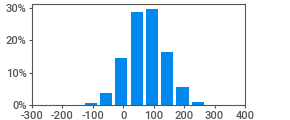
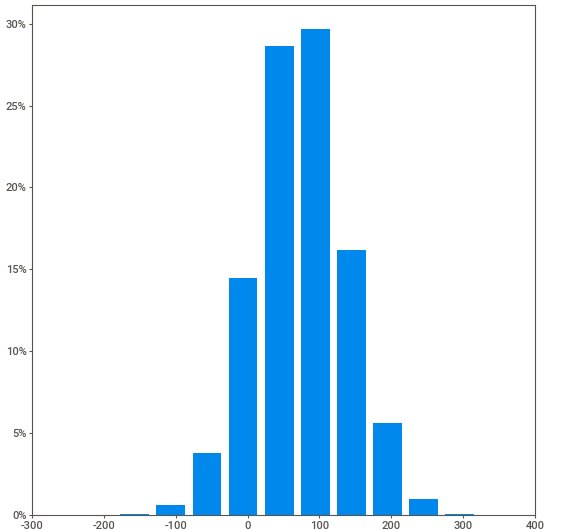
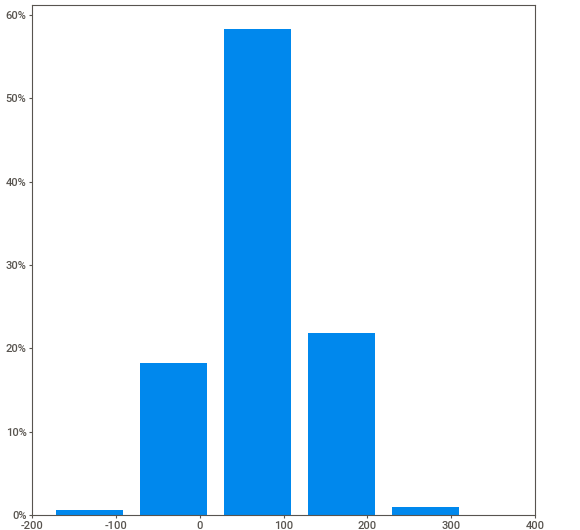
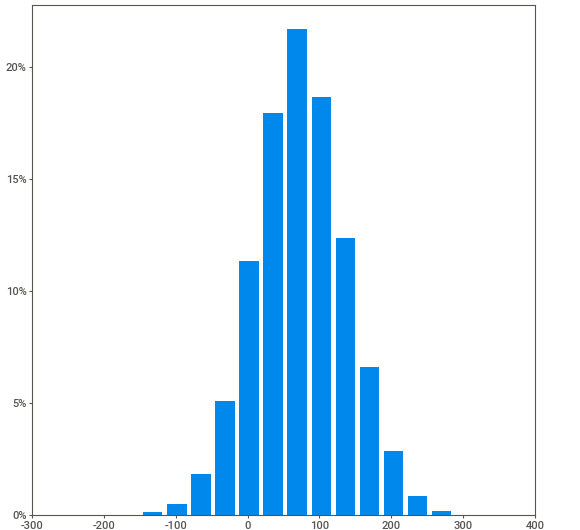
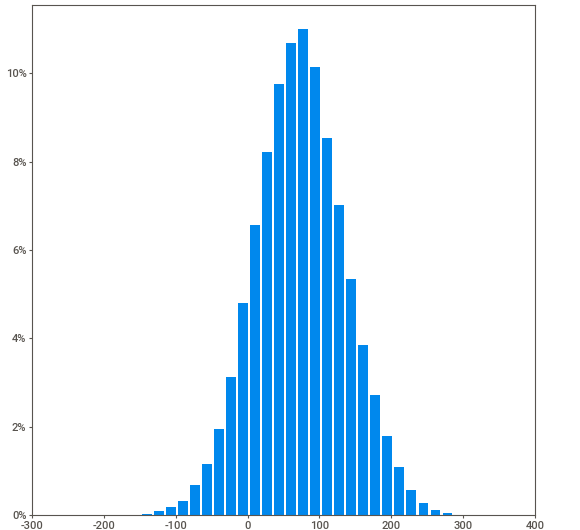
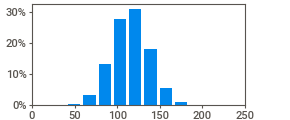
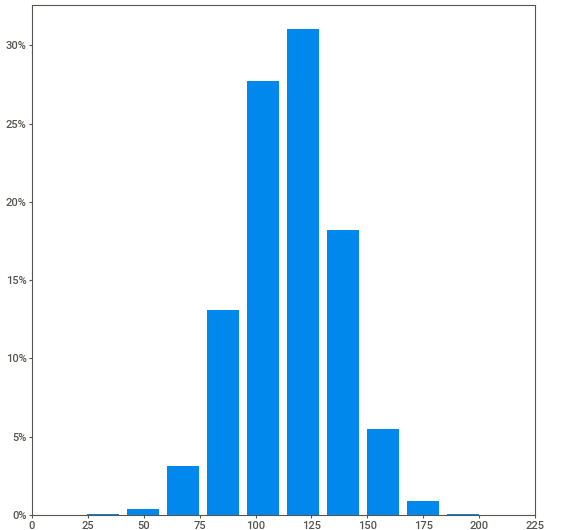
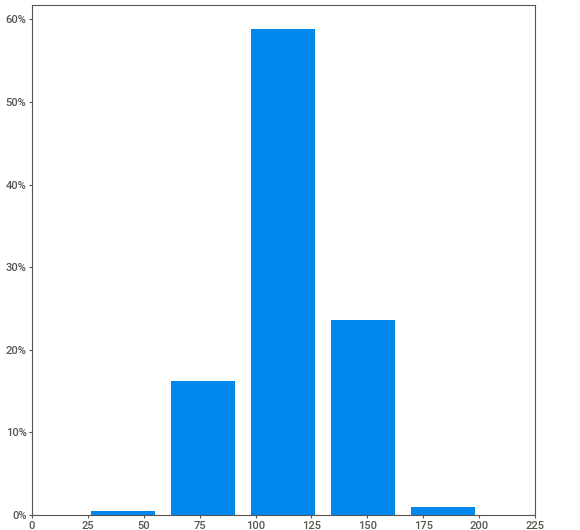
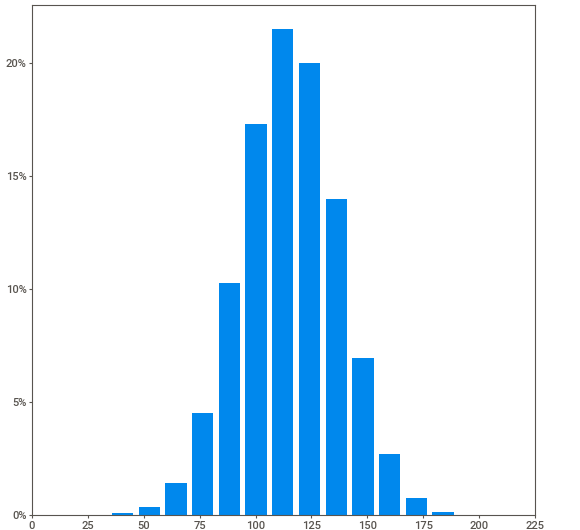
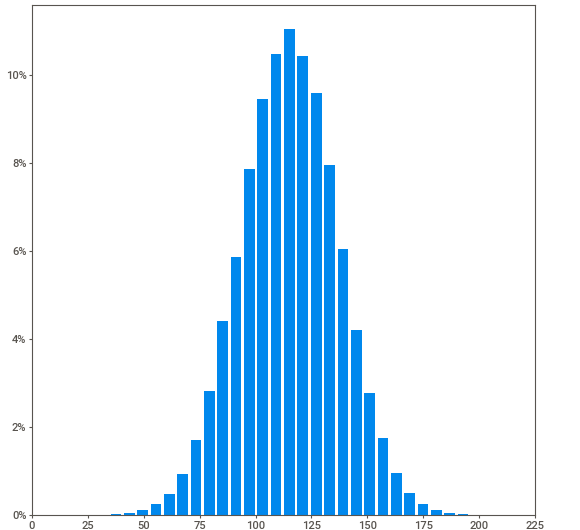
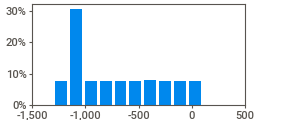
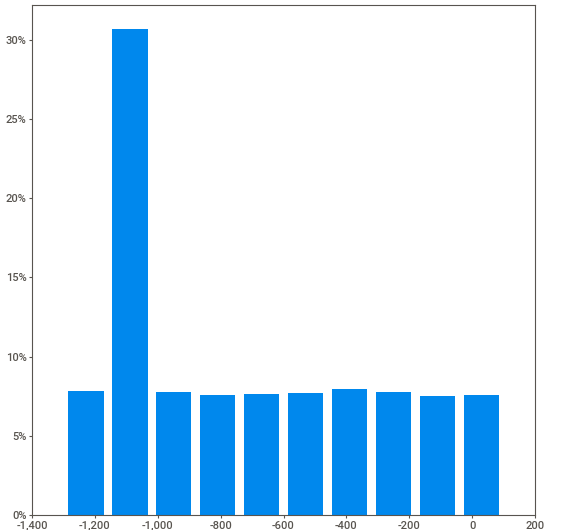
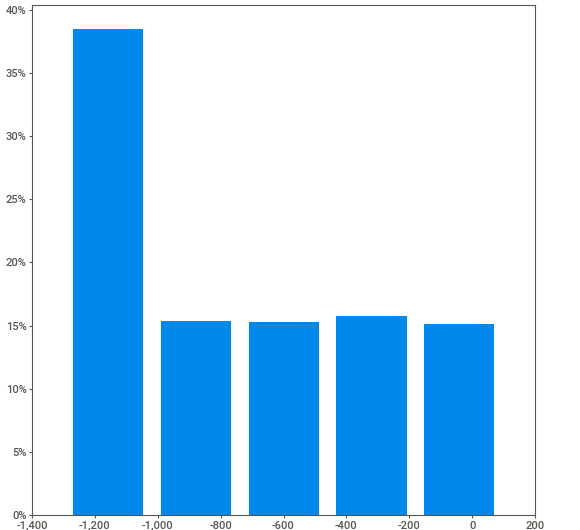
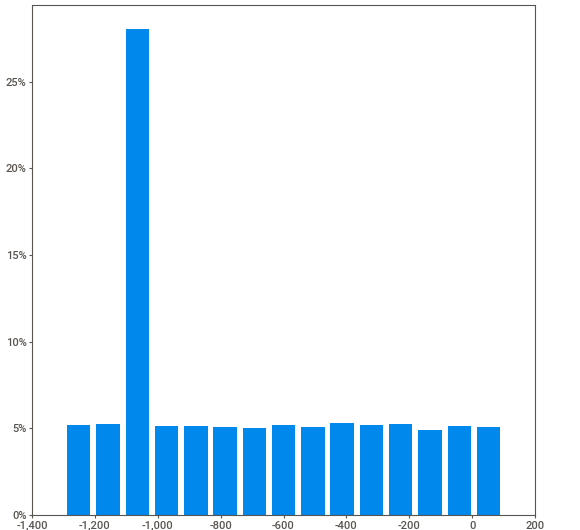
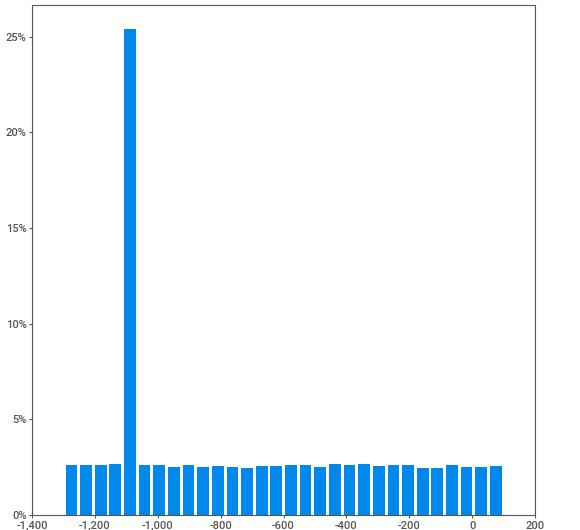
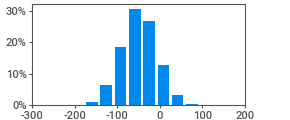
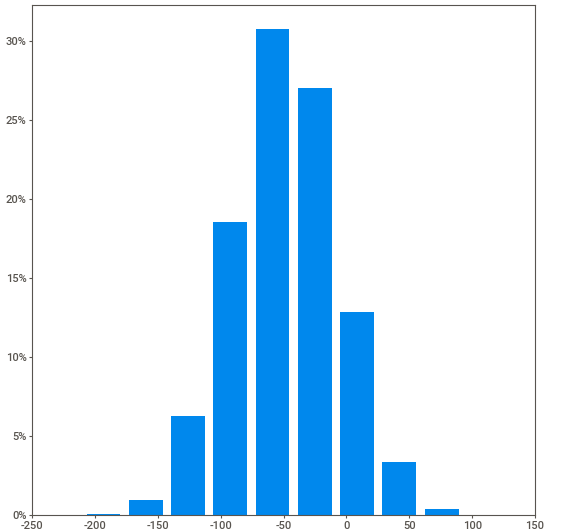
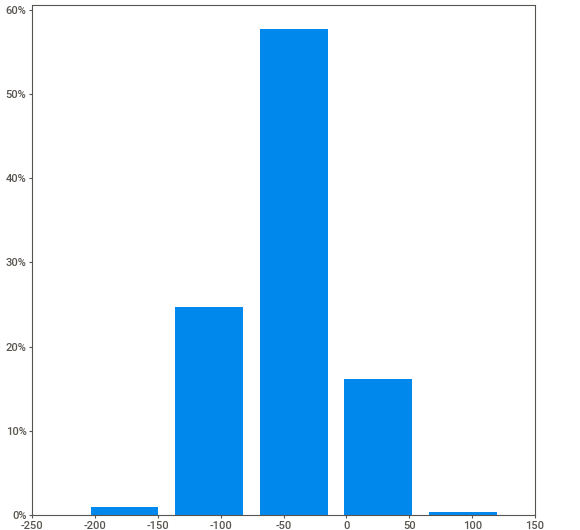
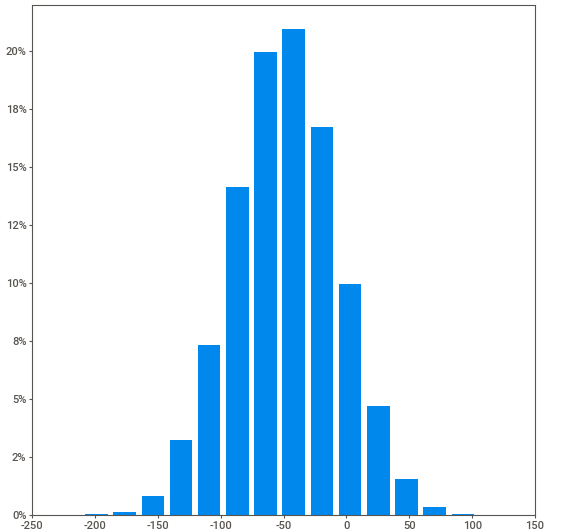
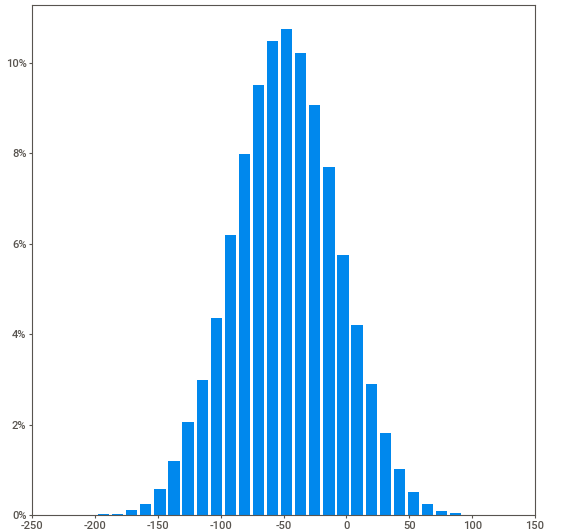
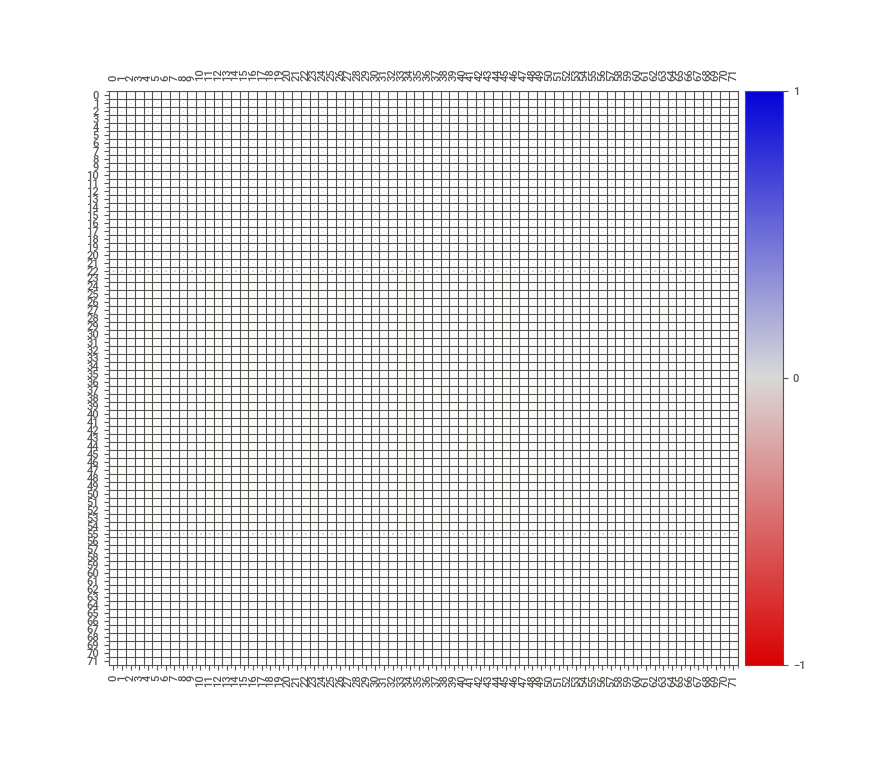
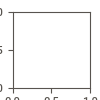

In [13]:
report = sv.analyze(df_train)
report.show_notebook(w=None, h=None, scale=0.9, layout='widescreen', filepath=None)

Видим, что большая часть признаков имеет нормальное распределение. За исключением 6, 21, 25, 33, 44, 59, 65, 70, в п.3 рассмотрим их влияние на метрику и решим, что с ними делать.

* Рассмотрим корреляцию признаков методами библиотеки `phik`.

interval columns not set, guessing: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71']


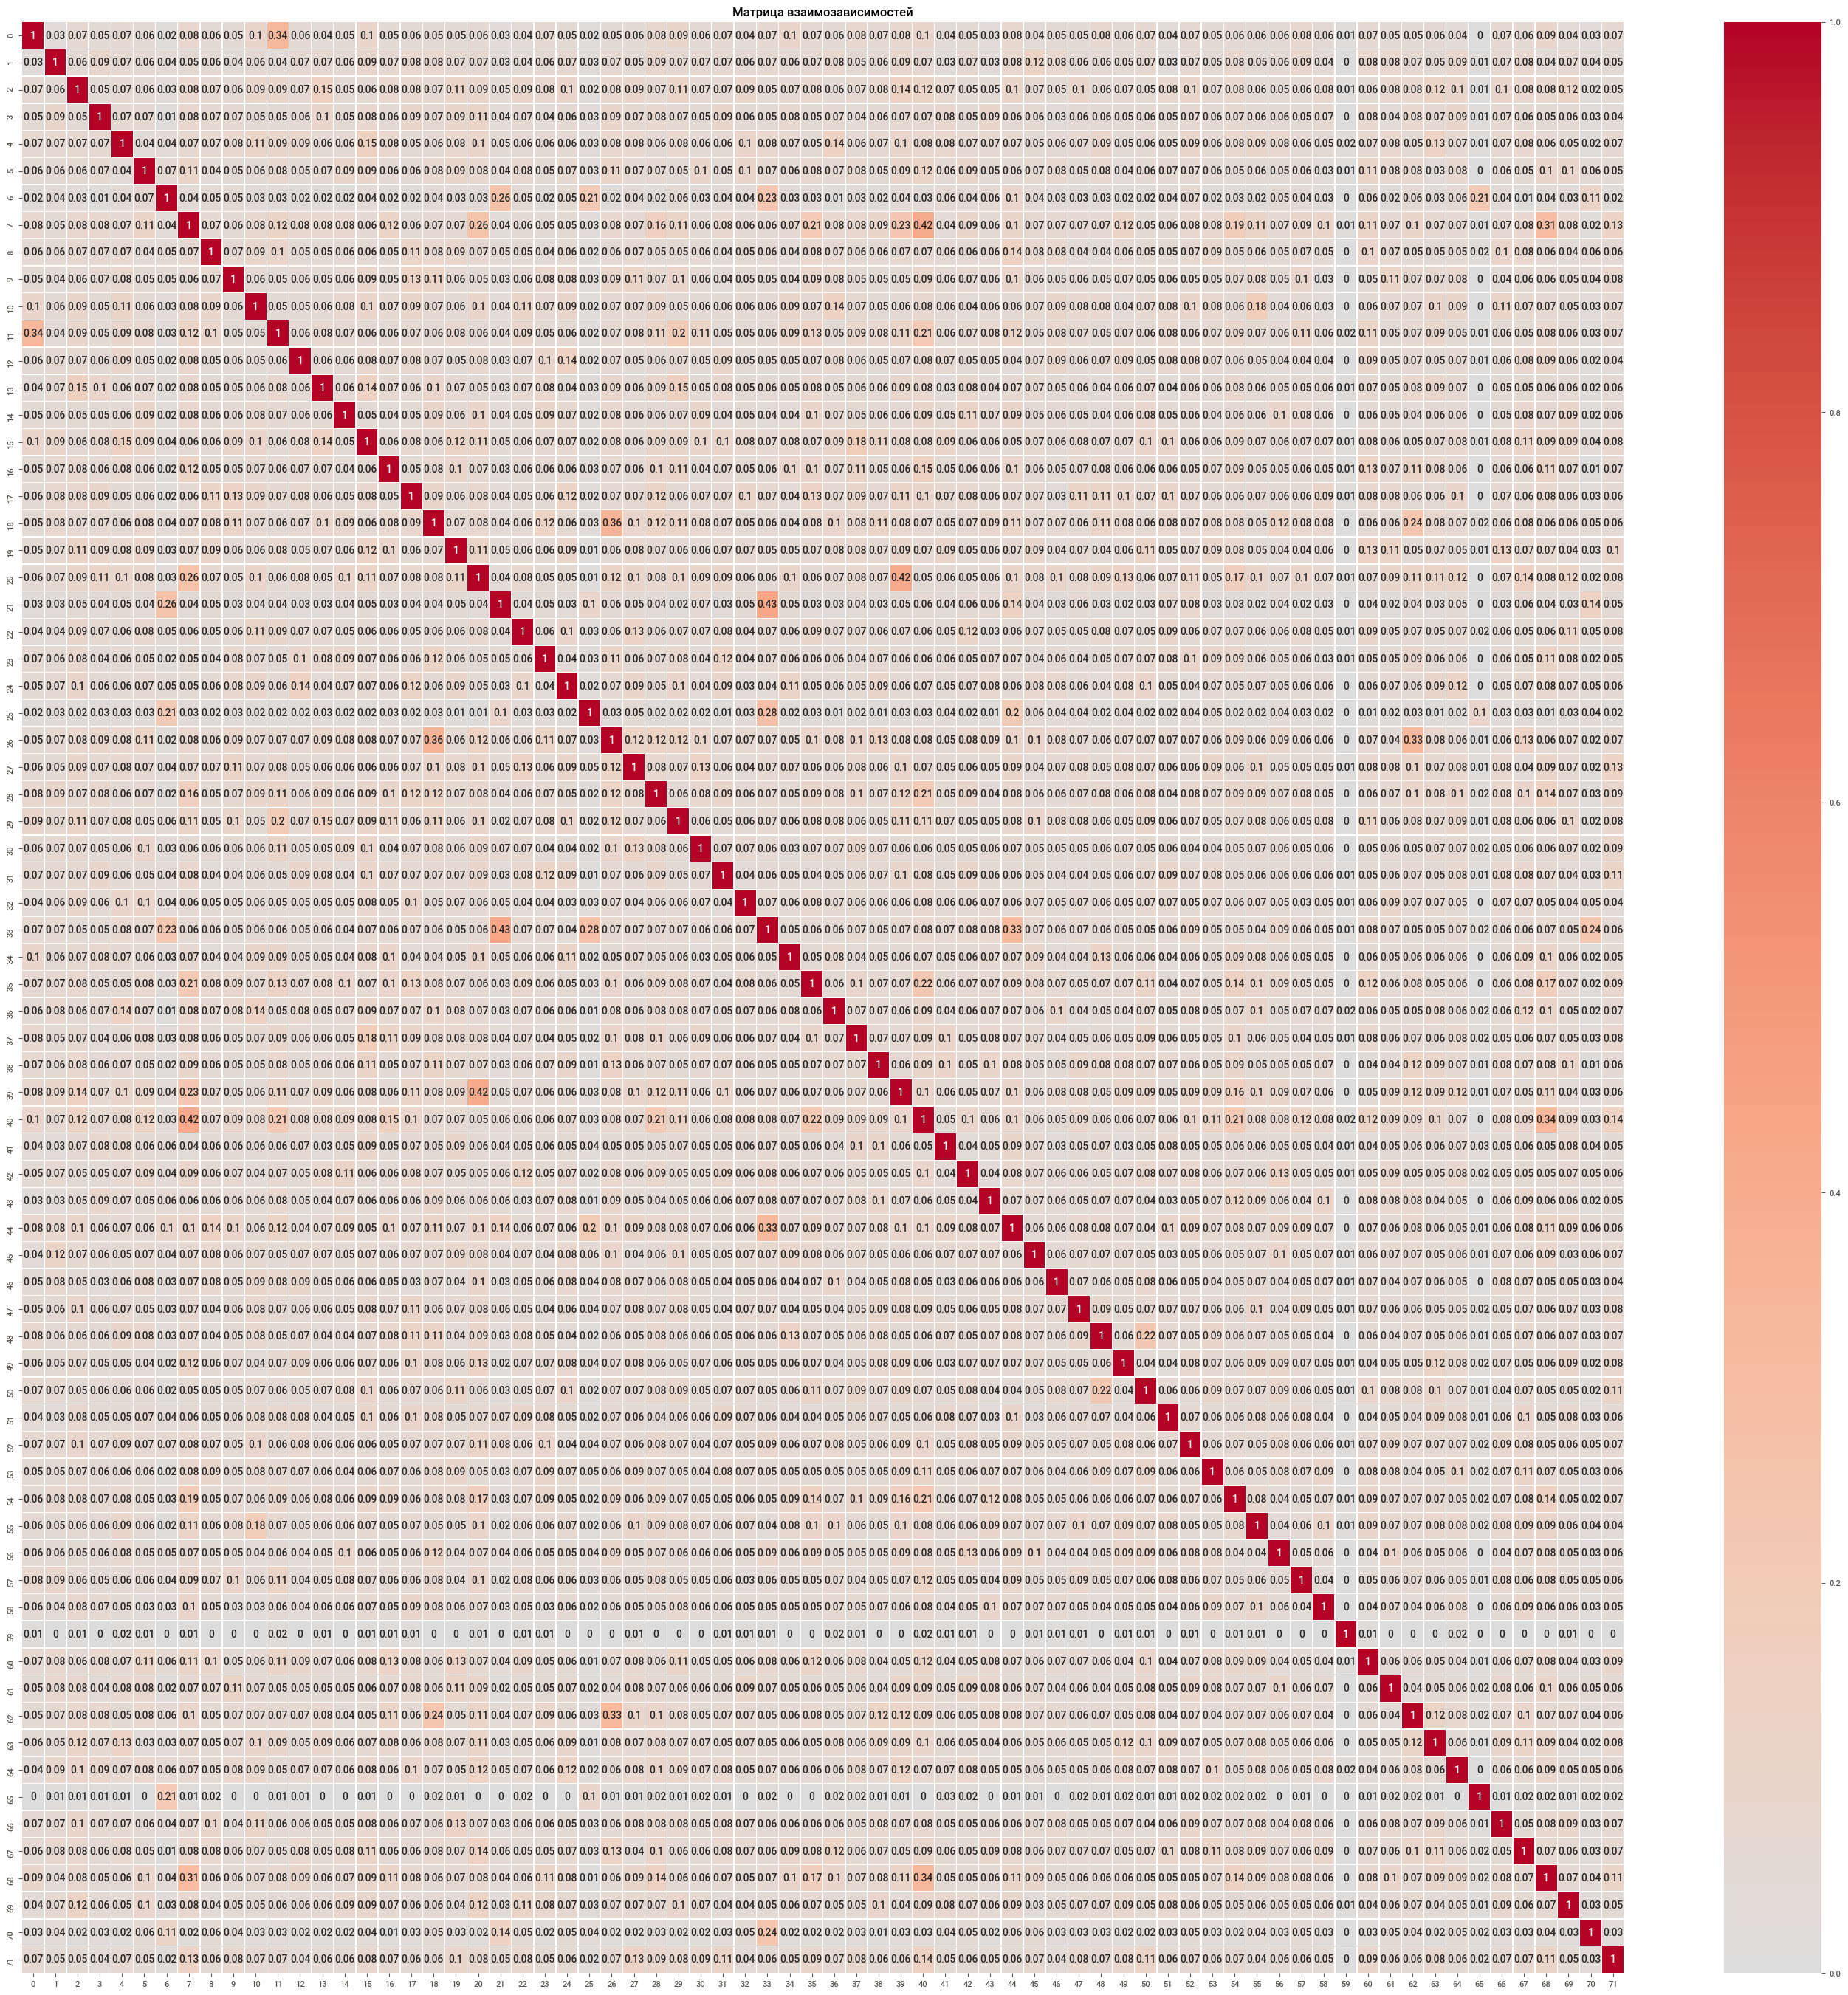

In [14]:
phik_overview = df_train.drop('Target', axis=1).phik_matrix()
plt.figure(figsize=(35, 35))
corr_matrix = phik_overview
corr_matrix = np.round(corr_matrix, 2)
sns.heatmap(corr_matrix, annot=True, linewidth= 0.3, cmap='coolwarm', center=0)
plt.title('Матрица взаимозависимостей')
plt.show()

Признаков с высокой корреляцией нет. На данном этапе сократить их количество не получится.

**Вывод по второму шагу:** исследовали загруженные данные. Заменили тип данных `float64` на `float32`, тем самым скоратив объем занимаемой памяти вдвое, к тому же, faiss работает именно с типом `float32`. Устранили выбросы, заменив их на средние значения. Обнаружили колонки, распределение в которых отличается от нормального. Провели исследование на корреляцию, высокоскоррелированных прзнаков не обнаружено.

## 3. Разработка алгоритма

* Создадим функцию для определения accuracy@5 при различных значениях параметров.

In [15]:
K = 5
def faiss_accuracy(df, df_eval, target,
                  n_clust=None,
                  index='ivf_flat',
                  metric='euclidean',
                  train_sample_size=None,
                  ef_search=32,
                  k_similar = K,
                  scaler=StandardScaler(),
                  SEED=99):
    
    scaler = scaler
    df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)
    df_eval = pd.DataFrame(scaler.transform(df_eval), columns=df_eval.columns, index=df_eval.index)
    
    dims = df.shape[1]
    base_index = {k: v for k, v in enumerate(df.index.to_list())}
    
    if index == 'ivf_flat':
        quantizer = faiss.IndexFlatL2(dims)
        df_arr = np.ascontiguousarray(df.values)
        df_eval_arr = np.ascontiguousarray(df_eval.values)
                        
        if metric == 'mahalanobis':
                
            # Вычислим матрицу ковариации.
            df_c = df - df.mean(0)
            cov = np.dot(df_c.T, df_c) / df_c.shape[0]

            # Преобразуем ковариационную матрицу.
            L = np.linalg.cholesky(cov)
            mahalanobis_transform = np.linalg.inv(L)

            # Функция преобразования данных.
            def inverse_cholesky_cov(df, mahalanobis_transform):
                df_trans = np.dot(df, mahalanobis_transform.T)
                return df_trans

            # Преобразуем данные.
            df_arr = inverse_cholesky_cov(df, mahalanobis_transform)
            df_eval_arr = inverse_cholesky_cov(df_eval, mahalanobis_transform)

            # Определим индекс.
            index = faiss.IndexIVFFlat(quantizer, dims, n_clust, faiss.METRIC_L2)
        
                
        elif metric == 'cosine':
            faiss.normalize_L2(df_arr)
            faiss.normalize_L2(df_eval_arr)
            index = faiss.IndexIVFFlat(quantizer, dims, n_clust, faiss.METRIC_INNER_PRODUCT)
            
            
        elif metric == 'mips':
            index = faiss.IndexIVFFlat(quantizer, dims, n_clust, faiss.METRIC_INNER_PRODUCT)
        
        elif metric == 'euclidean':
            index = faiss.IndexIVFFlat(quantizer, dims, n_clust)
            
        else:
            raise ValueError('Метрика не поддерживается или не существует')
    
    elif index == 'ivf_hnsw':
        df_arr = np.ascontiguousarray(df.values)
        df_eval_arr = np.ascontiguousarray(df_eval.values)
        index = faiss.index_factory(dims, (f'IVF{n_clust}_HNSW'+f'{ef_search}'+',Flat'))
        index.nprobe = 8
        
    start_faiss = perf_counter()
    
    index.train(df_arr[:train_sample_size, :])
    index.add(df_arr)
    
    vecs, idx = index.search(df_eval_arr.astype('float32'), k_similar)
    
    acc = 0
    for tar, el in zip(target.values.tolist(), idx):
        acc += int(tar in [base_index[r] for r in el])

    time = perf_counter() - start_faiss
    
    return (round((100 * acc / len(idx)), 3), round(time, 3))

* Базовая модель

Получим значение `accuracy@5` на базовой модели для дальнейшего исследования параметров.

In [16]:
acc, time = faiss_accuracy(df=df_base, df_eval=df_train_dt, target=target,
                  n_clust=250,
                  train_sample_size=int(df_base.shape[0] * 0.1)
                  )
print('acc@5 = ', acc)
print('время поиска, с: ', time)

acc@5 =  53.352
время поиска, с:  36.39


* Удаление признаков

Проверим, как удаление признаков сказывается на метрике.

In [17]:
drop_result = []
droped_columns = ['6', '21', '25', '33', '44', '59', '65', '70']

for column in droped_columns:
    df_base_d = df_base.drop(column, axis=1)
    df_train_dt_d = df_train_dt.drop(column, axis=1)
    
    acc, time = faiss_accuracy(df=df_base_d, df_eval=df_train_dt_d, target=target,
                  n_clust=250,
                  train_sample_size=int(df_base.shape[0] * 0.1)
                  )
    
    drop_result.append([column, acc, time])

In [18]:
pd.DataFrame(drop_result, columns=['Удаленный признак', 'acc@5', 'Сремя поиска, с'])

Удаленный признак   acc@5  Сремя поиска, с
0                 6  53.148           35.437
1                21  54.459           37.784
2                25  54.864           36.740
3                33  55.243           34.512
4                44  53.436           35.268
5                59  54.136           36.073
6                65  53.795           35.565
7                70  53.263           34.867

Удаление признаков 6 и 70 ведёт к ухудшению метрики, их необходимо сохранить, от остальных избавимся.

In [19]:
columns_to_drop = ['21', '25', '33', '44', '59', '65']
df_base = df_base.drop(columns_to_drop, axis=1)
df_train_dt = df_train_dt.drop(columns_to_drop, axis=1)
df_valid = df_valid.drop(columns_to_drop, axis=1)

* Используем метод локтя и коэффициент силуэта для определения оптимального числа кластеров

In [20]:
df_base_sample = df_base.sample(70000, random_state=99)
max_k = 550
range_params = range(50, max_k, 50)
wcss = []
silhouette_scores = []

for i in range_params:
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 99).fit(df_base_sample)
    preds = kmeans.predict(df_base_sample)
    silhouette_avg = silhouette_score(df_base_sample, preds)
    silhouette_scores.append(silhouette_avg)
    wcss.append(kmeans.inertia_)

C:\Users\User\practicum\practicum_env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\User\practicum\practicum_env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\User\practicum\practicum_env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\User\practicum\practicum_env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` wi

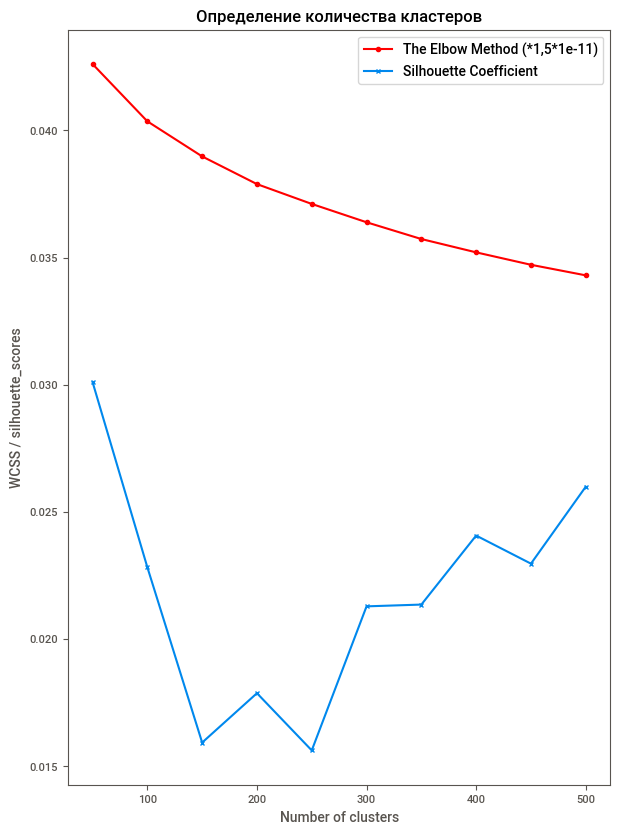

In [21]:
plt.figure(figsize=(7,10))
# делим каждый элемент wcss на 1,5*10^11 для масштабирования графика
plt.plot(range_params, [(i / (1.5 * 10 ** 11)) for i in wcss], marker='o', color='red')
plt.plot(range_params, silhouette_scores, marker='x')
plt.title('Определение количества кластеров')
plt.legend(['The Elbow Method (*1,5*1e-11)', 'Silhouette Coefficient'])
plt.xlabel('Number of clusters')
plt.ylabel('WCSS / silhouette_scores')
plt.show()

Однозначно определить лучшее количество кластеров трудно, возьмем значения `50`, `200`, `300` и `500`, т.к. после этих значений график локтя стремится к асимптоте, а на графике силуэта виднеются пики.

* Масштабирование

Рассмотрим, как тот или иной метод масштабирования сказывается на метрике и времени выполнения.

In [22]:
scalers_result = []
scalers = [StandardScaler(), RobustScaler(), MinMaxScaler()]

for scaler in scalers: 
    acc, time = faiss_accuracy(df=df_base, df_eval=df_train_dt, target=target,
                  n_clust=250,
                  train_sample_size=int(df_base.shape[0] * 0.1),
                  scaler=scaler
                  )
    
    scalers_result.append([scaler, acc, time])

In [23]:
pd.DataFrame(scalers_result, columns=['Скейлер', 'acc@5', 'Сремя поиска, с'])

Скейлер   acc@5  Сремя поиска, с
0  StandardScaler()  60.424         5167.920
1    RobustScaler()  60.444           33.954
2    MinMaxScaler()  55.247           31.114

`RobustScaler()` показывает лучшее значение метрики, но и наибольшее время поиска. тем не менее остановимся на нём.

In [24]:
%%time
metrics_results = []

for index, n_clust, metric in product(
    ['ivf_flat', 'ivf_hnsw'],
    [50, 200, 300, 500],
    ['mahalanobis', 'cosine', 'mips', 'euclidean']
    ):

    acc, time = faiss_accuracy(df=df_base, df_eval=df_train_dt, target=target,
                  n_clust=n_clust,
                  metric=metric,
                  train_sample_size=int(df_base.shape[0] * 0.1),
                  scaler=RobustScaler()
                  )
    metrics_results.append([index, n_clust, metric, acc, time])
    


Wall time: 28min 27s


In [25]:
columns = ['Индекс', 'Количество кластеров', 'Метрика', 'accuracy@5', 'Время поиска, сек.']
df_metrics_results = pd.DataFrame(metrics_results, columns=columns)
df_metrics_results.sort_values('accuracy@5', ascending=False)

Индекс  Количество кластеров      Метрика  accuracy@5  \
0   ivf_flat                    50  mahalanobis      61.082   
16  ivf_hnsw                    50  mahalanobis      61.082   
19  ivf_hnsw                    50    euclidean      61.028   
3   ivf_flat                    50    euclidean      61.028   
5   ivf_flat                   200       cosine      60.901   
21  ivf_hnsw                   200       cosine      60.901   
17  ivf_hnsw                    50       cosine      60.851   
1   ivf_flat                    50       cosine      60.851   
7   ivf_flat                   200    euclidean      60.809   
23  ivf_hnsw                   200    euclidean      60.809   
9   ivf_flat                   300       cosine      60.706   
25  ivf_hnsw                   300       cosine      60.706   
4   ivf_flat                   200  mahalanobis      60.485   
20  ivf_hnsw                   200  mahalanobis      60.485   
29  ivf_hnsw                   500       cosine      60.456   
13  ivf_flat                   500       cosine      60.456   
27  ivf_hnsw                   300    euclidean      60.181   
11  ivf_flat                   300    euclidean      60.181   
31  ivf_hnsw                   500    euclidean      60.084   
15  ivf_flat                   500    euclidean      60.084   
24  ivf_hnsw                   300  mahalanobis      60.060   
8   ivf_flat                   300  mahalanobis      60.060   
12  ivf_flat                   500  mahalanobis      59.517   
28  ivf_hnsw                   500  mahalanobis      59.517   
18  ivf_hnsw                    50         mips      57.330   
2   ivf_flat                    50         mips      57.330   
22  ivf_hnsw                   200         mips      56.882   
6   ivf_flat                   200         mips      56.882   
10  ivf_flat                   300         mips      56.646   
26  ivf_hnsw                   300         mips      56.646   
14  ivf_flat                   500         mips      56.468   
30  ivf_hnsw                   500         mips      56.468   

    Время поиска, сек.  
0              109.548  
16             103.739  
19             103.455  
3              104.118  
5               31.790  
21              32.337  
17              97.150  
1               98.259  
7               31.318  
23              31.350  
9               24.483  
25              24.034  
4               31.545  
20              31.796  
29              20.632  
13              20.953  
27              22.742  
11              23.567  
31              20.071  
15              20.569  
24              24.766  
8               23.643  
12              19.992  
28              21.062  
18              96.908  
2               98.288  
22              31.106  
6               31.563  
10              24.334  
26              24.684  
14              20.286  
30              20.921

Лучшее значение сочетания `accuracy@5` и `Время поиска, сек` показал следующий набор параметров: индекс - ivf_hnsw, количество кластеров - 50, метрика - mahalanobis. Используем данные параметры для расчета `accuracy@5` на валидационной выборке.

## 4. Оценка качества матчинга метрикой accuracy@5 на валидационной выборке.

In [26]:
acc, time = faiss_accuracy(df=df_base, df_eval=df_valid, target=df_valid_answer['Expected'],
                  n_clust=50,
                  index='ivf_hnsw',
                  metric='mahalanobis',
                  train_sample_size=int(df_base.shape[0] * 0.1),
                  scaler=RobustScaler()
                  )
acc, time

(69.53, 890.19)

На валидационной выборке получили значение `accuracy@5` равное 69,53 при времени работы 890,19 секунд.

## 5. Общий вывод

**Вывод:** открыли и изучили таблицы с данными.

Для работы представлены четыре таблицы:
- base.csv содержит 72 обезличенных признака типа float64 и 2918139 строк.
- train.csv содержит 72 обезличенных признака типа float64 и размеченный целевой признак типа object; и 100000 строк. На ней будем производить тренировку алгоритма.
- validation.csv содержит 72 обезличенных признака типа float64; и 100000 строк. Для данной выборки мы будем искать соответствия в base.csv.
- validation_answer.csv содержит ожидаемое значение матчинга типа object; и 100000 строк. Данная таблица необходима для оценки метрики.

Заменили тип данных `float64` на `float32`, тем самым скоратив объем занимаемой памяти вдвое, к тому же, faiss работает именно с типом `float32`. Устранили выбросы, заменив их на средние значения. Обнаружили колонки, распределение в которых отличается от нормального, избавились от тех, которые ухудшают метрику. Провели исследование на корреляцию, высокоскоррелированных прзнаков не обнаружено.

Определили оптимальное количество кластеров при помощи метода локтя и коэффициента силуэта. 

Разработали алгоритм, который для всех товаров из validation.csv предложит несколько вариантов наиболее похожих товаров из base.csv. При оптимальных гиперпараметрах: индекс - ivf_hnsw, количество кластеров - 50, метрика - mahalanobis, скейлер - RobustScaler() - получили точность предсказания в 69,53 при времени работы 890,19.